# DEMO

In [8]:
from qutip import *
import numpy as np 
import matplotlib.pyplot as plt
import math
from skimage.feature import peak_local_max
import pickle
import os
import glob
import heapq

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

saveDir = 'peaks'

##  plot peaks

In [9]:
def routine(E_i,wd_i):
    
    print('running param set {} {}'.format(E_i, wd_i))
    
    # Define all the variables 
    kappa = 0.0012 # 0.0012 
    gJC = 0.3347 # 0.3347
    wc = 10.5665 # Cavity frequency/detuning 10.5665
    w0 = 8.1831 # Qubit frequency 8.1831
    gamma=0.0001 # 0.0001
    Emax =0.01 # 0.01
    EN=1
    #E = 0.01 #0.01(original) # Epsilon
    E = E_i
    N = 50 #50
    nloop = 1

    #wd = 10.6005 # Driving frequency (10.6005 original)
    wd = wd_i
    wlist = np.linspace(wd, wd,nloop)

    # Identity operators are defined for the space of the light field and the space of the atom

    ida = identity(N)
    idatom = identity(2)

    # Define cavity field and atomic operators

    a  = tensor(destroy(N),idatom)
    sm = tensor(ida,sigmam())

    # Hamiltonian # Reminder check hamiltonian from caltech paper

    H1= 1*gJC*(a.dag()*sm + sm.dag()*a) + 1*E*(a+a.dag())

    # Collapse Operators

    C1    = math.sqrt(kappa)*a
    C2    = math.sqrt(gamma)*sm

    C1dC1 = C1.dag()*C1
    C2dC2 = C2.dag()*C2

    # Calculate the Liouvillian

    L1 = spre(C1)*spost(C1.dag())-0.5*spre(C1dC1)-0.5*spost(C1dC1)
    L2 = spre(C2)*spost(C2.dag())-0.5*spre(C2dC2)-0.5*spost(C2dC2)
    L12  = L1+L2

    gQ=math.sqrt(4)
    xvec=  np.arange(-10,10.01,0.025) # 0.025
    yvec = np.arange(-10,10.01,0.025) 

    #print("epsilon", E)
    #print("and drive frequency", wd)
    #print("kappa", kappa)
    k=0
    while k < nloop :
        wl = wlist[k]    
        H = (w0-wl)*(sm.dag()*sm) + (wc-wl)*(a.dag()*a) + H1    
        LH = -complex(0,1) * (spre(H) - spost(H))
        L_final = LH + L12

        # Steady States

        rhoss = steadystate(L_final)
        rhosscav=ptrace(rhoss,0)
        rhocavsq=rhosscav*rhosscav
        k += 1

        #subplot(ceil(sqrt(nloop)), 
        #ceil(sqrt(nloop)), k)
    plt.rcParams['figure.figsize'] = (20.0, 16.0)
    fig, ax = plt.subplots()
    Q3 = qfunc(rhosscav,xvec,yvec,gQ)
    c = ax.contourf(xvec, yvec, np.real(Q3), 500, cmap=plt.cm.get_cmap('winter'))
    

#         ax.set_xlim([-3.5, 6]) # -3.5 to 6
#         ax.set_ylim([-4, 3])
    plt.colorbar(c, ax=ax)
    plt.xlabel('x')
    plt.ylabel('y')
    


        #contour(xvec,yvec,real(Q3), 500)
        #plt.plot(xvec,yvec)
        #plt.show()
        #print(rhosscav)
        #print(rhoss)
    
    coordinates = peak_local_max(Q3)    
    for coord in coordinates:
        print('peak coords:{}'.format(coord))        
        coordHeight = Q3[coord[0], coord[1]]
        print('peak height:{}'.format(coordHeight))
        plt.plot(xvec[coord[1]], yvec[coord[0]], 'o', label='{}: {}'.format(coord, coordHeight))        
    plt.legend()
    plt.show()
    #print (Q3[coordinates])
    
#     newKey = len(savedInfo.keys()) + 1
    
#     infoPacket = {}
#     infoPacket['E_i'] = E_i
#     infoPacket['wd_i'] = wd_i
#     infoPacket['coors'] = coordinates
#     infoPacket['peaks'] = Q3[coordinates]
#     infoPacket['Q3'] = Q3
#     infoPacket['xvec'] = xvec
#     infoPacket['yvec'] = yvec
#     return infoPacket

## read peaks

In [53]:
relevantInfo = []
for peak in glob.glob(os.path.join('/mnt/c/Users/manish/Documents/GitHub/qpeak/peaks/peaksTipCoarse', '*')):    
    savedInfo = pickle.load(open(peak, 'rb'))    
    
    coors = savedInfo['coors']    
#     peaks = []
#     for coor in coors:        
#         peaks.append(savedInfo['Q3'][coor[0], coor[1]])
    peaks = savedInfo['peaks']
        
    relevantInfo_i = {}
    relevantInfo_i['peakName'] = peak
    relevantInfo_i['E'] = savedInfo['E_i']
    relevantInfo_i['wd'] = savedInfo['wd_i']
    if savedInfo['wd_i'] <= 0:
        print(savedInfo['wd_i'])
        break
    
    relevantInfo_i['peaks'] = peaks
    relevantInfo_i['coors'] = coors
    relevantInfo.append(relevantInfo_i)
    print('E:{}, wd_i:{}, coords:{}, peaks:{}'.format(relevantInfo_i['E'], relevantInfo_i['wd'], relevantInfo_i['coors'],relevantInfo_i['peaks']))
    
print(len(relevantInfo))

E:0.00125, wd_i:10.6095, coords:[[395 383]], peaks:[0.29469260394324304]
E:0.00125, wd_i:10.6095266332, coords:[[395 382]], peaks:[0.29262884604029366]
E:0.00125, wd_i:10.6097663317, coords:[[393 381]], peaks:[0.2680640466785742]
E:0.00125, wd_i:10.6121633166, coords:[[374 431]], peaks:[0.250748730323286]
E:0.00133793969849, wd_i:10.6095, coords:[[394 381]], peaks:[0.2769248946367265]
E:0.00212939698492, wd_i:10.6095, coords:[[362 458]], peaks:[0.18317763906004722]
E:0.00212939698492, wd_i:10.6095266332, coords:[[362 458]], peaks:[0.1843846144855691]
E:0.00212939698492, wd_i:10.6095532663, coords:[[363 458]], peaks:[0.18557522117838904]
E:0.00212939698492, wd_i:10.6095798995, coords:[[363 458]], peaks:[0.18673116673177614]
E:0.00212939698492, wd_i:10.6096065327, coords:[[363 458]], peaks:[0.18784285919096658]
E:0.00212939698492, wd_i:10.6096331658, coords:[[363 457]], peaks:[0.18893395402484064]
E:0.00212939698492, wd_i:10.609659799, coords:[[363 457]], peaks:[0.19000522971536715]
E:0.

E:0.00212939698492, wd_i:10.6119236181, coords:[[379 446]], peaks:[0.2565825914995736]
E:0.00212939698492, wd_i:10.6119502513, coords:[[380 446]], peaks:[0.2573177421687079]
E:0.00212939698492, wd_i:10.6119768844, coords:[[380 446]], peaks:[0.25807595846325715]
E:0.00212939698492, wd_i:10.6120035176, coords:[[380 446]], peaks:[0.2588138751297019]
E:0.00212939698492, wd_i:10.6120301508, coords:[[380 445]], peaks:[0.25958684960892825]
E:0.00212939698492, wd_i:10.6120567839, coords:[[380 445]], peaks:[0.260351091906638]
E:0.00212939698492, wd_i:10.6120834171, coords:[[380 445]], peaks:[0.2610944407199408]
E:0.00212939698492, wd_i:10.6121100503, coords:[[381 445]], peaks:[0.26183037287231564]
E:0.00212939698492, wd_i:10.6121366834, coords:[[381 445]], peaks:[0.2625853057964699]
E:0.00125, wd_i:10.6121899497, coords:[[374 431]], peaks:[0.25211391954400236]
E:0.00133793969849, wd_i:10.6097663317, coords:[[391 379]], peaks:[0.23896156259103912]
E:0.00212939698492, wd_i:10.6121633166, coords:[

E:0.00133793969849, wd_i:10.6100592965, coords:[[385 377]], peaks:[0.19031205398089507]
E:0.00214698492462, wd_i:10.6097663317, coords:[[364 457]], peaks:[0.19518055730299896]
E:0.00214698492462, wd_i:10.6097929648, coords:[[365 457]], peaks:[0.19609918136147925]
E:0.00214698492462, wd_i:10.609819598, coords:[[365 457]], peaks:[0.1970184840151172]
E:0.00214698492462, wd_i:10.6098462312, coords:[[365 457]], peaks:[0.19790897592972004]
E:0.00214698492462, wd_i:10.6098728643, coords:[[365 457]], peaks:[0.19877182899513027]
E:0.00214698492462, wd_i:10.6098994975, coords:[[366 457]], peaks:[0.1996370677791204]
E:0.00214698492462, wd_i:10.6099261307, coords:[[366 457]], peaks:[0.20049248582324627]
E:0.00214698492462, wd_i:10.6099527638, coords:[[366 456]], peaks:[0.2013285191272137]
E:0.00214698492462, wd_i:10.609979397, coords:[[366 456]], peaks:[0.20218435836611867]
E:0.00214698492462, wd_i:10.6100060302, coords:[[366 456]], peaks:[0.20301761834170037]
E:0.00133793969849, wd_i:10.610085929

E:0.00133793969849, wd_i:10.6103256281, coords:[[374 379]
 [357 434]], peaks:[0.15571841097678188, 0.11965105952415477]
E:0.00214698492462, wd_i:10.6124296482, coords:[[383 443]], peaks:[0.27081002667473664]
E:0.00214698492462, wd_i:10.6124562814, coords:[[383 443]], peaks:[0.2715449539357367]
E:0.00214698492462, wd_i:10.6124829146, coords:[[383 443]], peaks:[0.27225654763696805]
E:0.00214698492462, wd_i:10.6125095477, coords:[[383 443]], peaks:[0.27294458623697787]
E:0.00214698492462, wd_i:10.6125361809, coords:[[383 442]], peaks:[0.27364109750873794]
E:0.00214698492462, wd_i:10.6125628141, coords:[[383 442]], peaks:[0.27435281065389744]
E:0.00214698492462, wd_i:10.6125894472, coords:[[384 442]], peaks:[0.27506591103572775]
E:0.00214698492462, wd_i:10.6126160804, coords:[[384 442]], peaks:[0.27578490022133945]
E:0.00214698492462, wd_i:10.6126427136, coords:[[384 442]], peaks:[0.27647976287761167]
E:0.00214698492462, wd_i:10.6126693467, coords:[[384 442]], peaks:[0.2771503061624908]
E:

E:0.00216457286432, wd_i:10.609979397, coords:[[366 456]], peaks:[0.2031031349402873]
E:0.00216457286432, wd_i:10.6100060302, coords:[[366 456]], peaks:[0.2039198137285766]
E:0.00133793969849, wd_i:10.610618593, coords:[[358 433]
 [357 431]], peaks:[0.14936219637072895, 0.1493763512733351]
E:0.00216457286432, wd_i:10.6100326633, coords:[[366 456]], peaks:[0.20471508181183865]
E:0.00216457286432, wd_i:10.6100592965, coords:[[367 456]], peaks:[0.20553045939557496]
E:0.00216457286432, wd_i:10.6100859296, coords:[[367 456]], peaks:[0.2063298983887434]
E:0.00216457286432, wd_i:10.6101125628, coords:[[367 456]], peaks:[0.2071090905881746]
E:0.00216457286432, wd_i:10.610139196, coords:[[368 456]], peaks:[0.20787804140808266]
E:0.00216457286432, wd_i:10.6101658291, coords:[[368 456]], peaks:[0.20866280050894398]
E:0.00216457286432, wd_i:10.6101924623, coords:[[368 456]], peaks:[0.20942783577537175]
E:0.00216457286432, wd_i:10.6102190955, coords:[[368 455]], peaks:[0.2101875132761943]
E:0.00216

E:0.00216457286432, wd_i:10.6134150754, coords:[[388 437]], peaks:[0.29465731515512805]
E:0.00216457286432, wd_i:10.6134417085, coords:[[389 437]], peaks:[0.2951989481762104]
E:0.00216457286432, wd_i:10.6134683417, coords:[[389 437]], peaks:[0.29573573859784064]
E:0.00133793969849, wd_i:10.6109648241, coords:[[360 431]], peaks:[0.17945523528591373]
E:0.00216457286432, wd_i:10.6134949749, coords:[[389 437]], peaks:[0.2962450898203556]
E:0.00216457286432, wd_i:10.613521608, coords:[[389 436]], peaks:[0.2967849950180757]
E:0.00216457286432, wd_i:10.6135482412, coords:[[389 436]], peaks:[0.29731688494494063]
E:0.00216457286432, wd_i:10.6135748744, coords:[[389 436]], peaks:[0.29782133568105557]
E:0.00216457286432, wd_i:10.6136015075, coords:[[389 436]], peaks:[0.298298345667863]
E:0.00216457286432, wd_i:10.6136281407, coords:[[390 436]], peaks:[0.29876657068578943]
E:0.00216457286432, wd_i:10.6136547739, coords:[[390 436]], peaks:[0.29923673353357444]
E:0.00216457286432, wd_i:10.613681407,

E:0.00218216080402, wd_i:10.6113909548, coords:[[376 449]], peaks:[0.24268743884968771]
E:0.00218216080402, wd_i:10.6114175879, coords:[[376 449]], peaks:[0.24343079301639564]
E:0.00218216080402, wd_i:10.6114442211, coords:[[376 449]], peaks:[0.24415652197589555]
E:0.00218216080402, wd_i:10.6114708543, coords:[[377 449]], peaks:[0.24489558673715806]
E:0.00218216080402, wd_i:10.6114974874, coords:[[377 449]], peaks:[0.24563615347779982]
E:0.00218216080402, wd_i:10.6115241206, coords:[[377 449]], peaks:[0.24635890192086446]
E:0.00218216080402, wd_i:10.6115507538, coords:[[377 449]], peaks:[0.24706366610399194]
E:0.00218216080402, wd_i:10.6115773869, coords:[[377 448]], peaks:[0.2477891838116829]
E:0.00218216080402, wd_i:10.6116040201, coords:[[377 448]], peaks:[0.24852178527418387]
E:0.00133793969849, wd_i:10.6113110553, coords:[[650  29]
 [364 432]], peaks:[1.136905227708188e-55, 0.20407746019289152]
E:0.00218216080402, wd_i:10.6116306533, coords:[[378 448]], peaks:[0.2492669441726553]


E:0.00218216080402, wd_i:10.6141341709, coords:[[392 432]], peaks:[0.3065068378166043]
E:0.00218216080402, wd_i:10.614160804, coords:[[392 432]], peaks:[0.30687699782806926]
E:0.00218216080402, wd_i:10.6141874372, coords:[[392 432]], peaks:[0.3072219075789838]
E:0.00218216080402, wd_i:10.6142140704, coords:[[392 432]], peaks:[0.30754185113276805]
E:0.00218216080402, wd_i:10.6142407035, coords:[[392 432]], peaks:[0.30783712835007593]
E:0.00218216080402, wd_i:10.6142673367, coords:[[392 432]], peaks:[0.30810805409968844]
E:0.00133793969849, wd_i:10.6115773869, coords:[[368 433]], peaks:[0.220277853766603]
E:0.00218216080402, wd_i:10.6142939698, coords:[[392 431]], peaks:[0.3084015698996861]
E:0.00218216080402, wd_i:10.614320603, coords:[[392 431]], peaks:[0.30869942694791214]
E:0.00218216080402, wd_i:10.6143472362, coords:[[393 431]], peaks:[0.3089897110325203]
E:0.00218216080402, wd_i:10.6143738693, coords:[[393 431]], peaks:[0.30927820584262444]
E:0.00218216080402, wd_i:10.6144005025, 

E:0.00133793969849, wd_i:10.6118703518, coords:[[371 433]], peaks:[0.2369406956283304]
E:0.00219974874372, wd_i:10.6118969849, coords:[[380 447]], peaks:[0.25682853970589836]
E:0.00219974874372, wd_i:10.6119236181, coords:[[380 447]], peaks:[0.2575555791054401]
E:0.00219974874372, wd_i:10.6119502513, coords:[[380 447]], peaks:[0.2582630981727541]
E:0.00219974874372, wd_i:10.6119768844, coords:[[380 446]], peaks:[0.2590096284186245]
E:0.00219974874372, wd_i:10.6120035176, coords:[[380 446]], peaks:[0.2597453055137813]
E:0.00219974874372, wd_i:10.6120301508, coords:[[380 446]], peaks:[0.26046096743470576]
E:0.00219974874372, wd_i:10.6120567839, coords:[[381 446]], peaks:[0.2611756198932079]
E:0.00219974874372, wd_i:10.6120834171, coords:[[381 446]], peaks:[0.2619027855837102]
E:0.00219974874372, wd_i:10.6121100503, coords:[[381 446]], peaks:[0.26260941539912447]
E:0.00219974874372, wd_i:10.6121366834, coords:[[381 445]], peaks:[0.2633386032657699]
E:0.00125, wd_i:10.6124030151, coords:[[

E:0.00219974874372, wd_i:10.6145603015, coords:[[393 430]], peaks:[0.31092671197613697]
E:0.00219974874372, wd_i:10.6145869347, coords:[[393 430]], peaks:[0.31112344230113104]
E:0.00219974874372, wd_i:10.6146135678, coords:[[393 430]], peaks:[0.31129948397597845]
E:0.00219974874372, wd_i:10.614640201, coords:[[393 429]], peaks:[0.3115228972066631]
E:0.00219974874372, wd_i:10.6146668342, coords:[[394 429]], peaks:[0.3117620572132615]
E:0.00219974874372, wd_i:10.6146934673, coords:[[394 429]], peaks:[0.3119812392778897]
E:0.00219974874372, wd_i:10.6147201005, coords:[[394 429]], peaks:[0.3121804833251904]
E:0.00219974874372, wd_i:10.6147467337, coords:[[394 429]], peaks:[0.31236018050896225]
E:0.00219974874372, wd_i:10.6147733668, coords:[[394 429]], peaks:[0.31252072564171357]
E:0.00219974874372, wd_i:10.6148, coords:[[394 428]], peaks:[0.31270943904873283]
E:0.00125, wd_i:10.6097929648, coords:[[393 380]], peaks:[0.2646771857848219]
E:0.00125, wd_i:10.6124296482, coords:[[377 431]], pe

E:0.00221733668342, wd_i:10.6116572864, coords:[[378 448]], peaks:[0.25060836862130176]
E:0.00221733668342, wd_i:10.6116839196, coords:[[378 448]], peaks:[0.25133539216747]
E:0.00221733668342, wd_i:10.6117105528, coords:[[378 448]], peaks:[0.25204413291676947]
E:0.00221733668342, wd_i:10.6117371859, coords:[[379 448]], peaks:[0.25276848739427654]
E:0.00221733668342, wd_i:10.6117638191, coords:[[379 448]], peaks:[0.25349092245127725]
E:0.00221733668342, wd_i:10.6117904523, coords:[[379 448]], peaks:[0.2541947624700433]
E:0.00221733668342, wd_i:10.6118170854, coords:[[379 447]], peaks:[0.25490881217695555]
E:0.00221733668342, wd_i:10.6118437186, coords:[[379 447]], peaks:[0.2556415110530031]
E:0.00221733668342, wd_i:10.6118703518, coords:[[379 447]], peaks:[0.2563552393460191]
E:0.00133793969849, wd_i:10.6124030151, coords:[[378 433]], peaks:[0.26316458226589157]
E:0.00221733668342, wd_i:10.6118969849, coords:[[380 447]], peaks:[0.25707981572525307]
E:0.00221733668342, wd_i:10.6119236181

E:0.00221733668342, wd_i:10.614160804, coords:[[392 433]], peaks:[0.30666071037945486]
E:0.00221733668342, wd_i:10.6141874372, coords:[[392 432]], peaks:[0.3069878218118757]
E:0.00221733668342, wd_i:10.6142140704, coords:[[392 432]], peaks:[0.3073321362601414]
E:0.00221733668342, wd_i:10.6142407035, coords:[[392 432]], peaks:[0.3076519878026325]
E:0.00221733668342, wd_i:10.6142673367, coords:[[392 432]], peaks:[0.30794766793868067]
E:0.00133793969849, wd_i:10.6126427136, coords:[[380 432]], peaks:[0.2734176780513861]
E:0.00221733668342, wd_i:10.6142939698, coords:[[392 432]], peaks:[0.3082194824297778]
E:0.00221733668342, wd_i:10.614320603, coords:[[392 432]], peaks:[0.3084677505359496]
E:0.00221733668342, wd_i:10.6143472362, coords:[[392 431]], peaks:[0.30875971313086326]
E:0.00221733668342, wd_i:10.6143738693, coords:[[393 431]], peaks:[0.309072557975807]
E:0.00221733668342, wd_i:10.6144005025, coords:[[393 431]], peaks:[0.3093628171539837]
E:0.00221733668342, wd_i:10.6144271357, coo

E:0.00223492462312, wd_i:10.6116839196, coords:[[378 448]], peaks:[0.2516102501087084]
E:0.00223492462312, wd_i:10.6117105528, coords:[[378 448]], peaks:[0.2523182515829955]
E:0.00223492462312, wd_i:10.6117371859, coords:[[379 448]], peaks:[0.25304966584293453]
E:0.00223492462312, wd_i:10.6117638191, coords:[[379 448]], peaks:[0.25377146327858846]
E:0.00223492462312, wd_i:10.6117904523, coords:[[379 448]], peaks:[0.25447475744350806]
E:0.00223492462312, wd_i:10.6118170854, coords:[[379 448]], peaks:[0.25515933919088457]
E:0.00223492462312, wd_i:10.6118437186, coords:[[379 447]], peaks:[0.25587352924101453]
E:0.00223492462312, wd_i:10.6118703518, coords:[[379 447]], peaks:[0.25658688991626893]
E:0.00133793969849, wd_i:10.6129356784, coords:[[384 431]], peaks:[0.28493438905864277]
E:0.00223492462312, wd_i:10.6118969849, coords:[[380 447]], peaks:[0.2573184007888365]
E:0.00223492462312, wd_i:10.6119236181, coords:[[380 447]], peaks:[0.2580447769207785]
E:0.00223492462312, wd_i:10.61195025

E:0.00223492462312, wd_i:10.6144537688, coords:[[393 431]], peaks:[0.30979574049262176]
E:0.00223492462312, wd_i:10.614480402, coords:[[393 431]], peaks:[0.31003081650525055]
E:0.00223492462312, wd_i:10.6145070352, coords:[[393 431]], peaks:[0.31024407470889576]
E:0.00223492462312, wd_i:10.6145336683, coords:[[393 430]], peaks:[0.31050649111852857]
E:0.00133793969849, wd_i:10.6132020101, coords:[[386 430]], peaks:[0.29414024997868565]
E:0.00223492462312, wd_i:10.6145603015, coords:[[393 430]], peaks:[0.3107494646287618]
E:0.00223492462312, wd_i:10.6145869347, coords:[[393 430]], peaks:[0.3109713634438438]
E:0.00223492462312, wd_i:10.6146135678, coords:[[393 430]], peaks:[0.3111725548465025]
E:0.00223492462312, wd_i:10.614640201, coords:[[394 430]], peaks:[0.3113590916195544]
E:0.00223492462312, wd_i:10.6146668342, coords:[[394 430]], peaks:[0.3115522985718111]
E:0.00223492462312, wd_i:10.6146934673, coords:[[394 429]], peaks:[0.3117827368541906]
E:0.00223492462312, wd_i:10.6147201005, 

E:0.00225251256281, wd_i:10.6115773869, coords:[[378 449]], peaks:[0.24909833345245863]
E:0.00225251256281, wd_i:10.6116040201, coords:[[378 449]], peaks:[0.24981264620748406]
E:0.00133793969849, wd_i:10.6134417085, coords:[[388 428]], peaks:[0.3010023771387686]
E:0.00225251256281, wd_i:10.6116306533, coords:[[378 449]], peaks:[0.2505090985848616]
E:0.00225251256281, wd_i:10.6116572864, coords:[[378 449]], peaks:[0.2511875172723574]
E:0.00225251256281, wd_i:10.6116839196, coords:[[379 449]], peaks:[0.2518863991942842]
E:0.00225251256281, wd_i:10.6117105528, coords:[[378 448]], peaks:[0.2525789551664745]
E:0.00225251256281, wd_i:10.6117371859, coords:[[379 448]], peaks:[0.25331748384587127]
E:0.00225251256281, wd_i:10.6117638191, coords:[[379 448]], peaks:[0.25403879540004504]
E:0.00225251256281, wd_i:10.6117904523, coords:[[379 448]], peaks:[0.25474169521805107]
E:0.00225251256281, wd_i:10.6118170854, coords:[[379 448]], peaks:[0.2554259772018299]
E:0.00225251256281, wd_i:10.6118437186

E:0.00225251256281, wd_i:10.6143738693, coords:[[393 432]], peaks:[0.30884599021946996]
E:0.00225251256281, wd_i:10.6144005025, coords:[[393 431]], peaks:[0.3091456364800329]
E:0.00225251256281, wd_i:10.6144271357, coords:[[393 431]], peaks:[0.30943769720011843]
E:0.00225251256281, wd_i:10.6144537688, coords:[[393 431]], peaks:[0.309707282294537]
E:0.00225251256281, wd_i:10.614480402, coords:[[393 431]], peaks:[0.3099547274500882]
E:0.00225251256281, wd_i:10.6145070352, coords:[[393 431]], peaks:[0.3101803780005605]
E:0.00225251256281, wd_i:10.6145336683, coords:[[393 430]], peaks:[0.3103913290573032]
E:0.00133793969849, wd_i:10.6137346734, coords:[[390 426]], peaks:[0.30726834213044835]
E:0.00225251256281, wd_i:10.6145603015, coords:[[393 430]], peaks:[0.3106467163253429]
E:0.00225251256281, wd_i:10.6145869347, coords:[[393 430]], peaks:[0.3108810362880855]
E:0.00225251256281, wd_i:10.6146135678, coords:[[393 430]], peaks:[0.3110946465661302]
E:0.00225251256281, wd_i:10.614640201, coo

E:0.00227010050251, wd_i:10.6123763819, coords:[[383 445]], peaks:[0.2702427131104553]
E:0.00227010050251, wd_i:10.6124030151, coords:[[383 444]], peaks:[0.2709235950671974]
E:0.00133793969849, wd_i:10.6140542714, coords:[[392 424]], peaks:[0.31181591022035254]
E:0.00227010050251, wd_i:10.6124296482, coords:[[383 444]], peaks:[0.27162243791877994]
E:0.00227010050251, wd_i:10.6124562814, coords:[[383 444]], peaks:[0.27229928141230086]
E:0.00227010050251, wd_i:10.6124829146, coords:[[383 444]], peaks:[0.272953919700483]
E:0.00227010050251, wd_i:10.6125095477, coords:[[384 444]], peaks:[0.2736249587524167]
E:0.00227010050251, wd_i:10.6125361809, coords:[[384 444]], peaks:[0.2742861552206394]
E:0.00227010050251, wd_i:10.6125628141, coords:[[384 443]], peaks:[0.27494890662593646]
E:0.00227010050251, wd_i:10.6125894472, coords:[[384 443]], peaks:[0.2756372697268508]
E:0.00227010050251, wd_i:10.6126160804, coords:[[384 443]], peaks:[0.276302881367655]
E:0.00227010050251, wd_i:10.6126427136, c

E:0.00228768844221, wd_i:10.6096864322, coords:[[365 459]], peaks:[0.20071452766102535]
E:0.00228768844221, wd_i:10.6097130653, coords:[[366 459]], peaks:[0.20149559686426763]
E:0.00228768844221, wd_i:10.6097396985, coords:[[366 459]], peaks:[0.2022847542312653]
E:0.00133793969849, wd_i:10.614320603, coords:[[394 423]], peaks:[0.3141242000555358]
E:0.00228768844221, wd_i:10.6097663317, coords:[[366 459]], peaks:[0.20305033923440413]
E:0.00228768844221, wd_i:10.6097929648, coords:[[366 459]], peaks:[0.20379295827391633]
E:0.00228768844221, wd_i:10.609819598, coords:[[367 459]], peaks:[0.20453503552141458]
E:0.00228768844221, wd_i:10.6098462312, coords:[[367 459]], peaks:[0.20527667751957687]
E:0.00228768844221, wd_i:10.6098728643, coords:[[367 459]], peaks:[0.20599741635974858]
E:0.00228768844221, wd_i:10.6098994975, coords:[[367 458]], peaks:[0.20671918972261044]
E:0.00228768844221, wd_i:10.6099261307, coords:[[367 458]], peaks:[0.2074504894350664]
E:0.00228768844221, wd_i:10.609952763

E:0.00228768844221, wd_i:10.6130688442, coords:[[387 440]], peaks:[0.28696644625862383]
E:0.00228768844221, wd_i:10.6130954774, coords:[[387 440]], peaks:[0.2875842704066806]
E:0.00228768844221, wd_i:10.6131221106, coords:[[387 440]], peaks:[0.28817747396130583]
E:0.00228768844221, wd_i:10.6131487437, coords:[[387 440]], peaks:[0.2887459308161943]
E:0.00228768844221, wd_i:10.6131753769, coords:[[387 440]], peaks:[0.28928952562357413]
E:0.00228768844221, wd_i:10.6132020101, coords:[[387 439]], peaks:[0.28983760550090687]
E:0.00133793969849, wd_i:10.6146668342, coords:[[395 420]], peaks:[0.3159988641361497]
E:0.00228768844221, wd_i:10.6132286432, coords:[[388 439]], peaks:[0.2904192979040806]
E:0.00228768844221, wd_i:10.6132552764, coords:[[388 439]], peaks:[0.29101311849821415]
E:0.00228768844221, wd_i:10.6132819095, coords:[[388 439]], peaks:[0.2915817323832575]
E:0.00228768844221, wd_i:10.6133085427, coords:[[388 439]], peaks:[0.2921250377018196]
E:0.00228768844221, wd_i:10.6133351759

E:0.00230527638191, wd_i:10.6108582915, coords:[[374 454]], peaks:[0.23174702958777166]
E:0.00230527638191, wd_i:10.6108849246, coords:[[374 454]], peaks:[0.23240491148694878]
E:0.00230527638191, wd_i:10.6109115578, coords:[[374 453]], peaks:[0.23305532789597103]
E:0.00230527638191, wd_i:10.610938191, coords:[[374 453]], peaks:[0.23374171090447285]
E:0.00230527638191, wd_i:10.6109648241, coords:[[374 453]], peaks:[0.23441241644790312]
E:0.00230527638191, wd_i:10.6109914573, coords:[[375 453]], peaks:[0.23507132655716081]
E:0.00230527638191, wd_i:10.6110180905, coords:[[375 453]], peaks:[0.23575689592175342]
E:0.00230527638191, wd_i:10.6110447236, coords:[[375 453]], peaks:[0.23642659965534518]
E:0.00230527638191, wd_i:10.6110713568, coords:[[375 453]], peaks:[0.2370802797325389]
E:0.00135552763819, wd_i:10.609659799, coords:[[392 379]], peaks:[0.24948448291754718]
E:0.00230527638191, wd_i:10.6110979899, coords:[[375 452]], peaks:[0.23775434630089665]
E:0.00230527638191, wd_i:10.6111246

E:0.00230527638191, wd_i:10.6138145729, coords:[[390 436]], peaks:[0.30125781980556426]
E:0.00230527638191, wd_i:10.613841206, coords:[[390 435]], peaks:[0.30166775561846637]
E:0.00230527638191, wd_i:10.6138678392, coords:[[391 435]], peaks:[0.30211183536283726]
E:0.00230527638191, wd_i:10.6138944724, coords:[[391 435]], peaks:[0.30254371851232614]
E:0.00230527638191, wd_i:10.6139211055, coords:[[391 435]], peaks:[0.30295016336124253]
E:0.00230527638191, wd_i:10.6139477387, coords:[[391 435]], peaks:[0.30333130140848447]
E:0.00230527638191, wd_i:10.6139743719, coords:[[391 435]], peaks:[0.3036872821029491]
E:0.00230527638191, wd_i:10.614001005, coords:[[391 434]], peaks:[0.30407320290012085]
E:0.00135552763819, wd_i:10.6099527638, coords:[[387 377]], peaks:[0.20075651321862056]
E:0.00230527638191, wd_i:10.6140276382, coords:[[391 434]], peaks:[0.30445571143685907]
E:0.00230527638191, wd_i:10.6140542714, coords:[[391 434]], peaks:[0.3048134533079738]
E:0.00230527638191, wd_i:10.61408090

E:0.00232286432161, wd_i:10.6117904523, coords:[[380 449]], peaks:[0.2557124702491578]
E:0.00232286432161, wd_i:10.6118170854, coords:[[380 449]], peaks:[0.2563786929732057]
E:0.00232286432161, wd_i:10.6118437186, coords:[[380 448]], peaks:[0.25709309309672895]
E:0.00232286432161, wd_i:10.6118703518, coords:[[380 448]], peaks:[0.2577901969851212]
E:0.00135552763819, wd_i:10.6102723618, coords:[[375 378]
 [357 436]], peaks:[0.1552875417655619, 0.11778827991666879]
E:0.00232286432161, wd_i:10.6118969849, coords:[[380 448]], peaks:[0.2584687056022346]
E:0.00232286432161, wd_i:10.6119236181, coords:[[380 448]], peaks:[0.25912841149233834]
E:0.00232286432161, wd_i:10.6119502513, coords:[[381 448]], peaks:[0.25979914460718023]
E:0.00232286432161, wd_i:10.6119768844, coords:[[381 448]], peaks:[0.2604696608427312]
E:0.00232286432161, wd_i:10.6120035176, coords:[[381 447]], peaks:[0.2611722380665046]
E:0.00232286432161, wd_i:10.6120301508, coords:[[381 447]], peaks:[0.2618732815231106]
E:0.0023

E:0.00234045226131, wd_i:10.6100060302, coords:[[368 458]], peaks:[0.21165070015273607]
E:0.00135552763819, wd_i:10.610618593, coords:[[358 434]], peaks:[0.15249444248721244]
E:0.00234045226131, wd_i:10.6100326633, coords:[[368 458]], peaks:[0.21232717511433047]
E:0.00234045226131, wd_i:10.6100592965, coords:[[369 458]], peaks:[0.21299697969336168]
E:0.00234045226131, wd_i:10.6100859296, coords:[[369 458]], peaks:[0.21368378330115356]
E:0.00234045226131, wd_i:10.6101125628, coords:[[369 458]], peaks:[0.21435410723287077]
E:0.00234045226131, wd_i:10.610139196, coords:[[369 458]], peaks:[0.21500795780728113]
E:0.00234045226131, wd_i:10.6101658291, coords:[[370 458]], peaks:[0.2156623379806918]
E:0.00234045226131, wd_i:10.6101924623, coords:[[370 458]], peaks:[0.21632701623216394]
E:0.00234045226131, wd_i:10.6102190955, coords:[[370 458]], peaks:[0.2169753390931137]
E:0.00234045226131, wd_i:10.6102457286, coords:[[370 457]], peaks:[0.21764483862422931]
E:0.00234045226131, wd_i:10.61027236

E:0.00234045226131, wd_i:10.613681407, coords:[[390 437]], peaks:[0.29895483119572847]
E:0.00234045226131, wd_i:10.6137080402, coords:[[390 437]], peaks:[0.29938657275345637]
E:0.00234045226131, wd_i:10.6137346734, coords:[[390 436]], peaks:[0.29982442012841504]
E:0.00135552763819, wd_i:10.6109914573, coords:[[361 433]], peaks:[0.18346239805444978]
E:0.00234045226131, wd_i:10.6137613065, coords:[[390 436]], peaks:[0.3002825547375067]
E:0.00234045226131, wd_i:10.6137879397, coords:[[390 436]], peaks:[0.30071547079102623]
E:0.00234045226131, wd_i:10.6138145729, coords:[[390 436]], peaks:[0.3011232387934362]
E:0.00234045226131, wd_i:10.613841206, coords:[[391 436]], peaks:[0.3015222764817213]
E:0.00234045226131, wd_i:10.6138678392, coords:[[391 436]], peaks:[0.3019222541791277]
E:0.00234045226131, wd_i:10.6138944724, coords:[[391 435]], peaks:[0.30233826045496587]
E:0.00234045226131, wd_i:10.6139211055, coords:[[391 435]], peaks:[0.3027649960979219]
E:0.00234045226131, wd_i:10.6139477387,

E:0.00135552763819, wd_i:10.6113376884, coords:[[365 433]], peaks:[0.20696255223942742]
E:0.00235804020101, wd_i:10.6118969849, coords:[[380 448]], peaks:[0.25888706456902305]
E:0.00235804020101, wd_i:10.6119236181, coords:[[380 448]], peaks:[0.25954817078428266]
E:0.00235804020101, wd_i:10.6119502513, coords:[[381 448]], peaks:[0.2602330483313992]
E:0.00235804020101, wd_i:10.6119768844, coords:[[381 448]], peaks:[0.26090515718524676]
E:0.00235804020101, wd_i:10.6120035176, coords:[[381 448]], peaks:[0.2615582781276013]
E:0.00235804020101, wd_i:10.6120301508, coords:[[381 447]], peaks:[0.2622191152913487]
E:0.00235804020101, wd_i:10.6120567839, coords:[[381 447]], peaks:[0.2629027912603098]
E:0.00235804020101, wd_i:10.6120834171, coords:[[381 447]], peaks:[0.26356710534223604]
E:0.00235804020101, wd_i:10.6121100503, coords:[[382 447]], peaks:[0.26423631432751177]
E:0.00235804020101, wd_i:10.6121366834, coords:[[382 447]], peaks:[0.26491037337993234]
E:0.00125, wd_i:10.6128824121, coord

E:0.0023756281407, wd_i:10.6103256281, coords:[[371 457]], peaks:[0.22071464071732083]
E:0.0023756281407, wd_i:10.6103522613, coords:[[371 457]], peaks:[0.221372372447037]
E:0.0023756281407, wd_i:10.6103788945, coords:[[371 457]], peaks:[0.22201413606870385]
E:0.0023756281407, wd_i:10.6104055276, coords:[[371 457]], peaks:[0.22263984132519563]
E:0.0023756281407, wd_i:10.6104321608, coords:[[372 457]], peaks:[0.22327876191064583]
E:0.0023756281407, wd_i:10.610458794, coords:[[372 457]], peaks:[0.2239163761330468]
E:0.0023756281407, wd_i:10.6104854271, coords:[[372 457]], peaks:[0.22453794137904404]
E:0.0023756281407, wd_i:10.6105120603, coords:[[372 456]], peaks:[0.22519317290749924]
E:0.0023756281407, wd_i:10.6105386935, coords:[[372 456]], peaks:[0.2258400916861287]
E:0.00135552763819, wd_i:10.6117371859, coords:[[370 434]], peaks:[0.23017337631307877]
E:0.0023756281407, wd_i:10.6105653266, coords:[[372 456]], peaks:[0.22647112372848854]
E:0.0023756281407, wd_i:10.6105919598, coords:[

E:0.0023756281407, wd_i:10.6131221106, coords:[[387 441]], peaks:[0.2880864589200776]
E:0.0023756281407, wd_i:10.6131487437, coords:[[387 441]], peaks:[0.2886085719529788]
E:0.0023756281407, wd_i:10.6131753769, coords:[[387 440]], peaks:[0.28917748960413614]
E:0.0023756281407, wd_i:10.6132020101, coords:[[388 440]], peaks:[0.2897405850091906]
E:0.00135552763819, wd_i:10.6120035176, coords:[[373 433]], peaks:[0.24441084154106882]
E:0.0023756281407, wd_i:10.6132286432, coords:[[388 440]], peaks:[0.2903138689258104]
E:0.0023756281407, wd_i:10.6132552764, coords:[[388 440]], peaks:[0.2908629579782141]
E:0.0023756281407, wd_i:10.6132819095, coords:[[388 440]], peaks:[0.2913877577821088]
E:0.0023756281407, wd_i:10.6133085427, coords:[[388 440]], peaks:[0.29188818551238804]
E:0.0023756281407, wd_i:10.6133351759, coords:[[388 439]], peaks:[0.29243950860444823]
E:0.0023756281407, wd_i:10.613361809, coords:[[388 439]], peaks:[0.2929673216415612]
E:0.0023756281407, wd_i:10.6133884422, coords:[[38

E:0.0023932160804, wd_i:10.6114175879, coords:[[378 452]], peaks:[0.24744390383430068]
E:0.0023932160804, wd_i:10.6114442211, coords:[[378 451]], peaks:[0.24812886333374504]
E:0.0023932160804, wd_i:10.6114708543, coords:[[378 451]], peaks:[0.24879756163312214]
E:0.0023932160804, wd_i:10.6114974874, coords:[[378 451]], peaks:[0.24944926705646198]
E:0.0023932160804, wd_i:10.6115241206, coords:[[378 451]], peaks:[0.25008382487764874]
E:0.0023932160804, wd_i:10.6115507538, coords:[[379 451]], peaks:[0.25073543365166395]
E:0.0023932160804, wd_i:10.6115773869, coords:[[379 451]], peaks:[0.251381854336625]
E:0.0023932160804, wd_i:10.6116040201, coords:[[379 450]], peaks:[0.2520537815596373]
E:0.00135552763819, wd_i:10.6123763819, coords:[[377 433]], peaks:[0.2621282865173293]
E:0.0023932160804, wd_i:10.6116306533, coords:[[379 450]], peaks:[0.25273192545136625]
E:0.0023932160804, wd_i:10.6116572864, coords:[[379 450]], peaks:[0.25339264580954807]
E:0.0023932160804, wd_i:10.6116839196, coords:

E:0.0023932160804, wd_i:10.6147201005, coords:[[394 431]], peaks:[0.31122666359023804]
E:0.0023932160804, wd_i:10.6147467337, coords:[[394 430]], peaks:[0.31145084417807195]
E:0.0023932160804, wd_i:10.6147733668, coords:[[394 430]], peaks:[0.31167325419978614]
E:0.0023932160804, wd_i:10.6148, coords:[[394 430]], peaks:[0.3118769117447378]
E:0.00125, wd_i:10.6130155779, coords:[[384 429]], peaks:[0.28859101209047516]
E:0.00135552763819, wd_i:10.6126959799, coords:[[381 432]], peaks:[0.2756247656028328]
E:0.0024108040201, wd_i:10.6095, coords:[[366 462]], peaks:[0.20147917358815054]
E:0.0024108040201, wd_i:10.6095266332, coords:[[366 462]], peaks:[0.2021966480392705]
E:0.0024108040201, wd_i:10.6095532663, coords:[[366 462]], peaks:[0.2028925488796178]
E:0.0024108040201, wd_i:10.6095798995, coords:[[366 461]], peaks:[0.20361365658075914]
E:0.0024108040201, wd_i:10.6096065327, coords:[[366 461]], peaks:[0.204317547060202]
E:0.0024108040201, wd_i:10.6096331658, coords:[[366 461]], peaks:[0.

E:0.0024108040201, wd_i:10.6124296482, coords:[[383 445]], peaks:[0.2724145729563094]
E:0.0024108040201, wd_i:10.6124562814, coords:[[384 445]], peaks:[0.2730815857399839]
E:0.0024108040201, wd_i:10.6124829146, coords:[[384 445]], peaks:[0.2737353590646993]
E:0.0024108040201, wd_i:10.6125095477, coords:[[384 445]], peaks:[0.27436800638728476]
E:0.0024108040201, wd_i:10.6125361809, coords:[[384 445]], peaks:[0.2749793514395966]
E:0.0024108040201, wd_i:10.6125628141, coords:[[384 445]], peaks:[0.27556922688313956]
E:0.0024108040201, wd_i:10.6125894472, coords:[[384 444]], peaks:[0.2761978300523558]
E:0.0024108040201, wd_i:10.6126160804, coords:[[385 444]], peaks:[0.2768275970200634]
E:0.0024108040201, wd_i:10.6126427136, coords:[[385 444]], peaks:[0.2774736995424881]
E:0.0024108040201, wd_i:10.6126693467, coords:[[385 444]], peaks:[0.2780980157440282]
E:0.00135552763819, wd_i:10.6130155779, coords:[[384 431]], peaks:[0.287725952501062]
E:0.0024108040201, wd_i:10.6126959799, coords:[[385 

E:0.0024283919598, wd_i:10.6096864322, coords:[[367 461]], peaks:[0.2070987769958222]
E:0.0024283919598, wd_i:10.6097130653, coords:[[367 461]], peaks:[0.20775378059617322]
E:0.0024283919598, wd_i:10.6097396985, coords:[[368 461]], peaks:[0.2084038565942118]
E:0.00135552763819, wd_i:10.6132552764, coords:[[387 430]], peaks:[0.2955810986842199]
E:0.0024283919598, wd_i:10.6097663317, coords:[[368 461]], peaks:[0.20906264677360278]
E:0.0024283919598, wd_i:10.6097929648, coords:[[368 461]], peaks:[0.20970317256792956]
E:0.0024283919598, wd_i:10.609819598, coords:[[368 460]], peaks:[0.2103447046550972]
E:0.0024283919598, wd_i:10.6098462312, coords:[[368 460]], peaks:[0.21100211838451854]
E:0.0024283919598, wd_i:10.6098728643, coords:[[368 460]], peaks:[0.21164225266245534]
E:0.0024283919598, wd_i:10.6098994975, coords:[[369 460]], peaks:[0.21226726783369856]
E:0.0024283919598, wd_i:10.6099261307, coords:[[369 460]], peaks:[0.21291568904086672]
E:0.0024283919598, wd_i:10.6099527638, coords:[

E:0.00125, wd_i:10.6130954774, coords:[[385 429]], peaks:[0.29151325168351355]
E:0.00135552763819, wd_i:10.6134949749, coords:[[389 428]], peaks:[0.3020833213923599]
E:0.0024283919598, wd_i:10.6121633166, coords:[[382 447]], peaks:[0.26618740611634445]
E:0.0024283919598, wd_i:10.6121899497, coords:[[382 447]], peaks:[0.2668286987634338]
E:0.0024283919598, wd_i:10.6122165829, coords:[[383 447]], peaks:[0.2674531668199995]
E:0.0024283919598, wd_i:10.6122432161, coords:[[383 447]], peaks:[0.2681025009296127]
E:0.0024283919598, wd_i:10.6122698492, coords:[[383 447]], peaks:[0.26873192116109584]
E:0.0024283919598, wd_i:10.6122964824, coords:[[383 446]], peaks:[0.2693699838201503]
E:0.0024283919598, wd_i:10.6123231156, coords:[[383 446]], peaks:[0.2700303754934898]
E:0.0024283919598, wd_i:10.6123497487, coords:[[383 446]], peaks:[0.2706705102056982]
E:0.0024283919598, wd_i:10.6123763819, coords:[[383 446]], peaks:[0.2712901972570074]
E:0.0024283919598, wd_i:10.6124030151, coords:[[384 446]],

E:0.0024459798995, wd_i:10.6102190955, coords:[[371 459]], peaks:[0.22031952936879262]
E:0.0024459798995, wd_i:10.6102457286, coords:[[371 458]], peaks:[0.22092486261630834]
E:0.0024459798995, wd_i:10.6102723618, coords:[[371 458]], peaks:[0.22156065310636788]
E:0.00135552763819, wd_i:10.613841206, coords:[[391 426]], peaks:[0.3088743872034077]
E:0.0024459798995, wd_i:10.610298995, coords:[[371 458]], peaks:[0.22218114103897904]
E:0.0024459798995, wd_i:10.6103256281, coords:[[371 458]], peaks:[0.22278621822874192]
E:0.0024459798995, wd_i:10.6103522613, coords:[[372 458]], peaks:[0.22340738007584118]
E:0.0024459798995, wd_i:10.6103788945, coords:[[372 458]], peaks:[0.22402467983456026]
E:0.0024459798995, wd_i:10.6104055276, coords:[[372 458]], peaks:[0.2246264730800437]
E:0.0024459798995, wd_i:10.6104321608, coords:[[372 457]], peaks:[0.2252369550255628]
E:0.0024459798995, wd_i:10.610458794, coords:[[372 457]], peaks:[0.2258650802984465]
E:0.0024459798995, wd_i:10.6104854271, coords:[[3

E:0.0024459798995, wd_i:10.6133351759, coords:[[388 440]], peaks:[0.2922988095992065]
E:0.0024459798995, wd_i:10.613361809, coords:[[388 440]], peaks:[0.2927783132992415]
E:0.0024459798995, wd_i:10.6133884422, coords:[[389 440]], peaks:[0.29327484099036666]
E:0.0024459798995, wd_i:10.6134150754, coords:[[389 439]], peaks:[0.29378426731757606]
E:0.0024459798995, wd_i:10.6134417085, coords:[[389 439]], peaks:[0.2943133299857271]
E:0.0024459798995, wd_i:10.6134683417, coords:[[389 439]], peaks:[0.2948184009945244]
E:0.00135552763819, wd_i:10.614160804, coords:[[393 424]], peaks:[0.31275022300613436]
E:0.0024459798995, wd_i:10.6134949749, coords:[[389 439]], peaks:[0.2952994348538342]
E:0.0024459798995, wd_i:10.613521608, coords:[[389 439]], peaks:[0.2957563991954165]
E:0.0024459798995, wd_i:10.6135482412, coords:[[389 438]], peaks:[0.29620050568199646]
E:0.0024459798995, wd_i:10.6135748744, coords:[[389 438]], peaks:[0.29668567803495044]
E:0.0024459798995, wd_i:10.6136015075, coords:[[389

E:0.0024635678392, wd_i:10.6108582915, coords:[[375 455]], peaks:[0.2355006772974686]
E:0.0024635678392, wd_i:10.6108849246, coords:[[375 455]], peaks:[0.236132564203729]
E:0.0024635678392, wd_i:10.6109115578, coords:[[375 455]], peaks:[0.23674915359579637]
E:0.0024635678392, wd_i:10.610938191, coords:[[375 455]], peaks:[0.23735034244235328]
E:0.0024635678392, wd_i:10.6109648241, coords:[[376 455]], peaks:[0.23796599695654794]
E:0.0024635678392, wd_i:10.6109914573, coords:[[376 455]], peaks:[0.23858022211517563]
E:0.0024635678392, wd_i:10.6110180905, coords:[[376 454]], peaks:[0.23920231329692765]
E:0.0024635678392, wd_i:10.6110447236, coords:[[376 454]], peaks:[0.2398479432677401]
E:0.0024635678392, wd_i:10.6110713568, coords:[[376 454]], peaks:[0.2404780468234463]
E:0.00135552763819, wd_i:10.6144537688, coords:[[394 422]], peaks:[0.3149401517648283]
E:0.0024635678392, wd_i:10.6110979899, coords:[[376 454]], peaks:[0.24109248272770215]
E:0.0024635678392, wd_i:10.6111246231, coords:[[3

E:0.0024635678392, wd_i:10.6142673367, coords:[[392 434]], peaks:[0.30667155883750136]
E:0.00135552763819, wd_i:10.6147733668, coords:[[395 420]], peaks:[0.3163401669103908]
E:0.0024635678392, wd_i:10.6142939698, coords:[[392 434]], peaks:[0.30695529530556426]
E:0.0024635678392, wd_i:10.614320603, coords:[[392 434]], peaks:[0.30721705351582435]
E:0.0024635678392, wd_i:10.6143472362, coords:[[392 433]], peaks:[0.30749753630735654]
E:0.0024635678392, wd_i:10.6143738693, coords:[[392 433]], peaks:[0.3077896156039776]
E:0.0024635678392, wd_i:10.6144005025, coords:[[393 433]], peaks:[0.30808424975916415]
E:0.0024635678392, wd_i:10.6144271357, coords:[[393 433]], peaks:[0.30836771177029515]
E:0.0024635678392, wd_i:10.6144537688, coords:[[393 433]], peaks:[0.3086298671907805]
E:0.0024635678392, wd_i:10.614480402, coords:[[393 433]], peaks:[0.30887098186465883]
E:0.0024635678392, wd_i:10.6145070352, coords:[[393 432]], peaks:[0.3091234376434957]
E:0.0024635678392, wd_i:10.6145336683, coords:[[

E:0.00248115577889, wd_i:10.6113110553, coords:[[378 453]], peaks:[0.24641488417541707]
E:0.00248115577889, wd_i:10.6113376884, coords:[[378 453]], peaks:[0.2470380433884066]
E:0.00137311557789, wd_i:10.6096864322, coords:[[392 379]], peaks:[0.23883710343991266]
E:0.00248115577889, wd_i:10.6113643216, coords:[[378 453]], peaks:[0.24764478090433875]
E:0.00248115577889, wd_i:10.6113909548, coords:[[378 452]], peaks:[0.2482918015829412]
E:0.00248115577889, wd_i:10.6114175879, coords:[[378 452]], peaks:[0.2489306927957386]
E:0.00248115577889, wd_i:10.6114442211, coords:[[378 452]], peaks:[0.24955298409806526]
E:0.00248115577889, wd_i:10.6114708543, coords:[[379 452]], peaks:[0.25017745035980593]
E:0.00248115577889, wd_i:10.6114974874, coords:[[379 452]], peaks:[0.2508112714182284]
E:0.00248115577889, wd_i:10.6115241206, coords:[[379 452]], peaks:[0.2514282516222418]
E:0.00248115577889, wd_i:10.6115507538, coords:[[379 451]], peaks:[0.2520617313903376]
E:0.00248115577889, wd_i:10.6115773869

E:0.00137311557789, wd_i:10.609979397, coords:[[386 377]], peaks:[0.18909299451738076]
E:0.00248115577889, wd_i:10.6142939698, coords:[[392 434]], peaks:[0.30688063223071554]
E:0.00248115577889, wd_i:10.614320603, coords:[[392 434]], peaks:[0.30715318147106396]
E:0.00248115577889, wd_i:10.6143472362, coords:[[392 434]], peaks:[0.3074040637920411]
E:0.00248115577889, wd_i:10.6143738693, coords:[[392 433]], peaks:[0.30768832857719125]
E:0.00248115577889, wd_i:10.6144005025, coords:[[393 433]], peaks:[0.3079870843227165]
E:0.00248115577889, wd_i:10.6144271357, coords:[[393 433]], peaks:[0.30828145158243186]
E:0.00248115577889, wd_i:10.6144537688, coords:[[393 433]], peaks:[0.3085545689193342]
E:0.00248115577889, wd_i:10.614480402, coords:[[393 433]], peaks:[0.30880669394884985]
E:0.00248115577889, wd_i:10.6145070352, coords:[[393 433]], peaks:[0.3090380939279392]
E:0.00248115577889, wd_i:10.6145336683, coords:[[393 432]], peaks:[0.30929391984724014]
E:0.00137311557789, wd_i:10.6100060302,

E:0.00249874371859, wd_i:10.6116040201, coords:[[379 451]], peaks:[0.2535777236532006]
E:0.00137311557789, wd_i:10.6102457286, coords:[[375 378]
 [357 437]], peaks:[0.15241747690677893, 0.11894377178094388]
E:0.00249874371859, wd_i:10.6116306533, coords:[[380 451]], peaks:[0.25419489975127585]
E:0.00249874371859, wd_i:10.6116572864, coords:[[380 451]], peaks:[0.2548392919060374]
E:0.00249874371859, wd_i:10.6116839196, coords:[[380 451]], peaks:[0.2554664917942648]
E:0.00249874371859, wd_i:10.6117105528, coords:[[380 451]], peaks:[0.25607634846781235]
E:0.00249874371859, wd_i:10.6117371859, coords:[[380 450]], peaks:[0.25670650229111586]
E:0.00249874371859, wd_i:10.6117638191, coords:[[380 450]], peaks:[0.25734907757356346]
E:0.00249874371859, wd_i:10.6117904523, coords:[[380 450]], peaks:[0.2579741044268896]
E:0.00249874371859, wd_i:10.6118170854, coords:[[381 450]], peaks:[0.25860093577891596]
E:0.00249874371859, wd_i:10.6118437186, coords:[[381 450]], peaks:[0.25923612842260535]
E:0.

E:0.00249874371859, wd_i:10.6145603015, coords:[[393 432]], peaks:[0.30945820738772406]
E:0.00249874371859, wd_i:10.6145869347, coords:[[393 432]], peaks:[0.3097119188524431]
E:0.00249874371859, wd_i:10.6146135678, coords:[[393 432]], peaks:[0.3099457514773662]
E:0.00249874371859, wd_i:10.614640201, coords:[[393 432]], peaks:[0.3101599875833728]
E:0.00249874371859, wd_i:10.6146668342, coords:[[393 432]], peaks:[0.31035491661677145]
E:0.00249874371859, wd_i:10.6146934673, coords:[[393 432]], peaks:[0.3105308346263845]
E:0.00249874371859, wd_i:10.6147201005, coords:[[394 431]], peaks:[0.3107553459700103]
E:0.00249874371859, wd_i:10.6147467337, coords:[[394 431]], peaks:[0.3109939293650229]
E:0.00249874371859, wd_i:10.6147733668, coords:[[394 431]], peaks:[0.31121373203427616]
E:0.00249874371859, wd_i:10.6148, coords:[[394 431]], peaks:[0.31141505269673364]
E:0.00125, wd_i:10.6133351759, coords:[[387 428]], peaks:[0.2991974560410538]
E:0.00137311557789, wd_i:10.6105653266, coords:[[359 43

E:0.00251633165829, wd_i:10.6125628141, coords:[[385 445]], peaks:[0.27600584694988267]
E:0.00251633165829, wd_i:10.6125894472, coords:[[385 445]], peaks:[0.276641917178951]
E:0.00251633165829, wd_i:10.6126160804, coords:[[385 445]], peaks:[0.27725722174658257]
E:0.00251633165829, wd_i:10.6126427136, coords:[[385 445]], peaks:[0.27785160656096186]
E:0.00251633165829, wd_i:10.6126693467, coords:[[385 445]], peaks:[0.2784249256631148]
E:0.00137311557789, wd_i:10.6108849246, coords:[[361 435]], peaks:[0.17735163047253502]
E:0.00251633165829, wd_i:10.6126959799, coords:[[385 445]], peaks:[0.2789770413096748]
E:0.00251633165829, wd_i:10.6127226131, coords:[[385 444]], peaks:[0.279569243714792]
E:0.00251633165829, wd_i:10.6127492462, coords:[[386 444]], peaks:[0.28015499995236365]
E:0.00251633165829, wd_i:10.6127758794, coords:[[386 444]], peaks:[0.2807626956279133]
E:0.00251633165829, wd_i:10.6128025126, coords:[[386 444]], peaks:[0.28134890904990834]
E:0.00251633165829, wd_i:10.6128291457,

E:0.00253391959799, wd_i:10.6106984925, coords:[[375 457]], peaks:[0.2333967235673334]
E:0.00253391959799, wd_i:10.6107251256, coords:[[375 457]], peaks:[0.23399625451657183]
E:0.00253391959799, wd_i:10.6107517588, coords:[[375 457]], peaks:[0.234580655689671]
E:0.00253391959799, wd_i:10.610778392, coords:[[375 456]], peaks:[0.23518386687169093]
E:0.00253391959799, wd_i:10.6108050251, coords:[[375 456]], peaks:[0.23579911316917848]
E:0.00137311557789, wd_i:10.6112311558, coords:[[364 434]], peaks:[0.20160144856758655]
E:0.00253391959799, wd_i:10.6108316583, coords:[[375 456]], peaks:[0.23639927142338518]
E:0.00253391959799, wd_i:10.6108582915, coords:[[375 456]], peaks:[0.23698425452263872]
E:0.00253391959799, wd_i:10.6108849246, coords:[[376 456]], peaks:[0.23757592830252205]
E:0.00253391959799, wd_i:10.6109115578, coords:[[376 456]], peaks:[0.23817341442488213]
E:0.00253391959799, wd_i:10.610938191, coords:[[376 455]], peaks:[0.23875626028396907]
E:0.00253391959799, wd_i:10.610964824

E:0.00253391959799, wd_i:10.6137346734, coords:[[390 438]], peaks:[0.29907206750949766]
E:0.00137311557789, wd_i:10.6115241206, coords:[[368 434]], peaks:[0.21897291511003522]
E:0.00253391959799, wd_i:10.6137613065, coords:[[390 438]], peaks:[0.29947495100224997]
E:0.00253391959799, wd_i:10.6137879397, coords:[[390 438]], peaks:[0.2998545675332498]
E:0.00253391959799, wd_i:10.6138145729, coords:[[390 437]], peaks:[0.300252395007158]
E:0.00253391959799, wd_i:10.613841206, coords:[[391 437]], peaks:[0.3006653634258763]
E:0.00253391959799, wd_i:10.6138678392, coords:[[391 437]], peaks:[0.30109102780962455]
E:0.00253391959799, wd_i:10.6138944724, coords:[[391 437]], peaks:[0.3014934126831535]
E:0.00253391959799, wd_i:10.6139211055, coords:[[391 437]], peaks:[0.3018725965225528]
E:0.00253391959799, wd_i:10.6139477387, coords:[[391 437]], peaks:[0.30222867195181885]
E:0.00253391959799, wd_i:10.6139743719, coords:[[391 436]], peaks:[0.30260601472830134]
E:0.00253391959799, wd_i:10.614001005, 

E:0.00255150753769, wd_i:10.6116572864, coords:[[380 451]], peaks:[0.255506760225872]
E:0.00255150753769, wd_i:10.6116839196, coords:[[380 451]], peaks:[0.2561377172480483]
E:0.00255150753769, wd_i:10.6117105528, coords:[[380 451]], peaks:[0.25675154796318317]
E:0.00255150753769, wd_i:10.6117371859, coords:[[380 451]], peaks:[0.25734810576806966]
E:0.00255150753769, wd_i:10.6117638191, coords:[[381 451]], peaks:[0.2579553247408748]
E:0.00255150753769, wd_i:10.6117904523, coords:[[381 451]], peaks:[0.2585614416160554]
E:0.00255150753769, wd_i:10.6118170854, coords:[[381 450]], peaks:[0.25918362311185955]
E:0.00255150753769, wd_i:10.6118437186, coords:[[381 450]], peaks:[0.2598233454342005]
E:0.00255150753769, wd_i:10.6118703518, coords:[[381 450]], peaks:[0.2604454709567818]
E:0.00137311557789, wd_i:10.6118703518, coords:[[372 434]], peaks:[0.23797150992713384]
E:0.00255150753769, wd_i:10.6118969849, coords:[[381 450]], peaks:[0.2610498405967091]
E:0.00255150753769, wd_i:10.6119236181, 

E:0.00255150753769, wd_i:10.6145869347, coords:[[393 433]], peaks:[0.30944985180784124]
E:0.00255150753769, wd_i:10.6146135678, coords:[[393 432]], peaks:[0.3096690968440228]
E:0.00255150753769, wd_i:10.614640201, coords:[[393 432]], peaks:[0.3099159892579217]
E:0.00255150753769, wd_i:10.6146668342, coords:[[393 432]], peaks:[0.31014361849131883]
E:0.00255150753769, wd_i:10.6146934673, coords:[[393 432]], peaks:[0.31035225886427487]
E:0.00255150753769, wd_i:10.6147201005, coords:[[394 432]], peaks:[0.3105478167438991]
E:0.00255150753769, wd_i:10.6147467337, coords:[[394 432]], peaks:[0.31074865845457705]
E:0.00255150753769, wd_i:10.6147733668, coords:[[394 431]], peaks:[0.310934330840724]
E:0.00255150753769, wd_i:10.6148, coords:[[394 431]], peaks:[0.3111681942455175]
E:0.00125, wd_i:10.6098994975, coords:[[391 380]], peaks:[0.25002582560023484]
E:0.00125, wd_i:10.6134949749, coords:[[389 427]], peaks:[0.3034031488822172]
E:0.00137311557789, wd_i:10.6121633166, coords:[[375 434]], peak

E:0.00256909547739, wd_i:10.6117105528, coords:[[380 451]], peaks:[0.2569574832132903]
E:0.00256909547739, wd_i:10.6117371859, coords:[[380 451]], peaks:[0.2575555822409464]
E:0.00256909547739, wd_i:10.6117638191, coords:[[381 451]], peaks:[0.25817013950591444]
E:0.00256909547739, wd_i:10.6117904523, coords:[[381 451]], peaks:[0.2587778650721956]
E:0.00256909547739, wd_i:10.6118170854, coords:[[381 451]], peaks:[0.25936812915679097]
E:0.00256909547739, wd_i:10.6118437186, coords:[[381 450]], peaks:[0.2600007625841148]
E:0.00256909547739, wd_i:10.6118703518, coords:[[381 450]], peaks:[0.26062461449868973]
E:0.00137311557789, wd_i:10.6124030151, coords:[[378 433]], peaks:[0.2634714577370048]
E:0.00256909547739, wd_i:10.6118969849, coords:[[381 450]], peaks:[0.2612307916826381]
E:0.00256909547739, wd_i:10.6119236181, coords:[[381 450]], peaks:[0.2618191386488226]
E:0.00256909547739, wd_i:10.6119502513, coords:[[382 450]], peaks:[0.262433846563686]
E:0.00256909547739, wd_i:10.6119768844, c

E:0.00258668341709, wd_i:10.6099261307, coords:[[370 461]], peaks:[0.21786648131950312]
E:0.00258668341709, wd_i:10.6099527638, coords:[[370 461]], peaks:[0.21845089467774315]
E:0.00258668341709, wd_i:10.609979397, coords:[[370 461]], peaks:[0.21902053764912752]
E:0.00258668341709, wd_i:10.6100060302, coords:[[371 461]], peaks:[0.21959199182832237]
E:0.00137311557789, wd_i:10.6127492462, coords:[[382 432]], peaks:[0.27771359421483305]
E:0.00258668341709, wd_i:10.6100326633, coords:[[371 461]], peaks:[0.22017318427674126]
E:0.00258668341709, wd_i:10.6100592965, coords:[[371 461]], peaks:[0.22073981503476606]
E:0.00258668341709, wd_i:10.6100859296, coords:[[371 461]], peaks:[0.22129186043647706]
E:0.00258668341709, wd_i:10.6101125628, coords:[[371 460]], peaks:[0.22186245969653873]
E:0.00258668341709, wd_i:10.610139196, coords:[[371 460]], peaks:[0.2224419140381149]
E:0.00258668341709, wd_i:10.6101658291, coords:[[371 460]], peaks:[0.22300689111908806]
E:0.00258668341709, wd_i:10.6101924

E:0.00258668341709, wd_i:10.6130422111, coords:[[387 443]], peaks:[0.28641314956989816]
E:0.00258668341709, wd_i:10.6130688442, coords:[[387 443]], peaks:[0.28692112264460373]
E:0.00258668341709, wd_i:10.6130954774, coords:[[387 442]], peaks:[0.2874107998934191]
E:0.00258668341709, wd_i:10.6131221106, coords:[[387 442]], peaks:[0.2879498384742765]
E:0.00258668341709, wd_i:10.6131487437, coords:[[388 442]], peaks:[0.2884901433289583]
E:0.00258668341709, wd_i:10.6131753769, coords:[[388 442]], peaks:[0.2890289727399282]
E:0.00258668341709, wd_i:10.6132020101, coords:[[388 442]], peaks:[0.2895456499964829]
E:0.00137311557789, wd_i:10.6130688442, coords:[[385 431]], peaks:[0.2894726188738292]
E:0.00258668341709, wd_i:10.6132286432, coords:[[388 442]], peaks:[0.2900400949883273]
E:0.00258668341709, wd_i:10.6132552764, coords:[[388 441]], peaks:[0.29051593124367864]
E:0.00258668341709, wd_i:10.6132819095, coords:[[388 441]], peaks:[0.29104132150444156]
E:0.00258668341709, wd_i:10.6133085427,

E:0.00260427135678, wd_i:10.610938191, coords:[[376 456]], peaks:[0.24012794209705424]
E:0.00260427135678, wd_i:10.6109648241, coords:[[376 456]], peaks:[0.24069627991235473]
E:0.00260427135678, wd_i:10.6109914573, coords:[[377 456]], peaks:[0.2412814767878367]
E:0.00260427135678, wd_i:10.6110180905, coords:[[377 456]], peaks:[0.2418615909185125]
E:0.00260427135678, wd_i:10.6110447236, coords:[[377 455]], peaks:[0.24244107082142943]
E:0.00260427135678, wd_i:10.6110713568, coords:[[377 455]], peaks:[0.24305410407412092]
E:0.00137311557789, wd_i:10.6133884422, coords:[[388 429]], peaks:[0.29921386828630325]
E:0.00260427135678, wd_i:10.6110979899, coords:[[377 455]], peaks:[0.24365181525894242]
E:0.00260427135678, wd_i:10.6111246231, coords:[[377 455]], peaks:[0.2442340759624263]
E:0.00260427135678, wd_i:10.6111512563, coords:[[378 455]], peaks:[0.2448055011652842]
E:0.00260427135678, wd_i:10.6111778894, coords:[[378 455]], peaks:[0.24539908634337654]
E:0.00260427135678, wd_i:10.611204522

E:0.00260427135678, wd_i:10.6140276382, coords:[[391 437]], peaks:[0.3030100100825978]
E:0.00260427135678, wd_i:10.6140542714, coords:[[391 436]], peaks:[0.30335864177308314]
E:0.00260427135678, wd_i:10.6140809045, coords:[[391 436]], peaks:[0.303714792687365]
E:0.00260427135678, wd_i:10.6141075377, coords:[[392 436]], peaks:[0.30405963602106895]
E:0.00260427135678, wd_i:10.6141341709, coords:[[392 436]], peaks:[0.3044078718233548]
E:0.00260427135678, wd_i:10.614160804, coords:[[392 436]], peaks:[0.3047341202437492]
E:0.00260427135678, wd_i:10.6141874372, coords:[[392 436]], peaks:[0.30503853432000133]
E:0.00260427135678, wd_i:10.6142140704, coords:[[392 435]], peaks:[0.30536426574554454]
E:0.00260427135678, wd_i:10.6142407035, coords:[[392 435]], peaks:[0.3056998471440356]
E:0.00260427135678, wd_i:10.6142673367, coords:[[392 435]], peaks:[0.30601392504731634]
E:0.00137311557789, wd_i:10.6137080402, coords:[[390 427]], peaks:[0.3064308356216419]
E:0.00260427135678, wd_i:10.6142939698, 

E:0.00262185929648, wd_i:10.6117638191, coords:[[381 451]], peaks:[0.2587601694222786]
E:0.00262185929648, wd_i:10.6117904523, coords:[[381 451]], peaks:[0.2593731017017279]
E:0.00262185929648, wd_i:10.6118170854, coords:[[381 451]], peaks:[0.2599687927279012]
E:0.00262185929648, wd_i:10.6118437186, coords:[[381 451]], peaks:[0.2605470990499757]
E:0.00262185929648, wd_i:10.6118703518, coords:[[382 451]], peaks:[0.26111332897244666]
E:0.00137311557789, wd_i:10.614001005, coords:[[392 425]], peaks:[0.3108957919266105]
E:0.00262185929648, wd_i:10.6118969849, coords:[[381 450]], peaks:[0.26172183624612894]
E:0.00262185929648, wd_i:10.6119236181, coords:[[382 450]], peaks:[0.2623314491653776]
E:0.00262185929648, wd_i:10.6119502513, coords:[[382 450]], peaks:[0.26295231511861333]
E:0.00262185929648, wd_i:10.6119768844, coords:[[382 450]], peaks:[0.26355545495355226]
E:0.00262185929648, wd_i:10.6120035176, coords:[[382 450]], peaks:[0.2641407143698303]
E:0.00262185929648, wd_i:10.6120301508, 

E:0.00263944723618, wd_i:10.6101125628, coords:[[372 461]], peaks:[0.223231397734399]
E:0.00263944723618, wd_i:10.610139196, coords:[[372 461]], peaks:[0.22379074184143227]
E:0.00263944723618, wd_i:10.6101658291, coords:[[372 461]], peaks:[0.2243357951656433]
E:0.00263944723618, wd_i:10.6101924623, coords:[[372 460]], peaks:[0.22487766137430884]
E:0.00263944723618, wd_i:10.6102190955, coords:[[372 460]], peaks:[0.22545168140968258]
E:0.00263944723618, wd_i:10.6102457286, coords:[[372 460]], peaks:[0.22601141534312894]
E:0.00263944723618, wd_i:10.6102723618, coords:[[373 460]], peaks:[0.2265728036538401]
E:0.00137311557789, wd_i:10.6143738693, coords:[[394 423]], peaks:[0.31429372260076943]
E:0.00263944723618, wd_i:10.610298995, coords:[[373 460]], peaks:[0.2271447740887606]
E:0.00263944723618, wd_i:10.6103256281, coords:[[373 460]], peaks:[0.2277023398520365]
E:0.00263944723618, wd_i:10.6103522613, coords:[[373 460]], peaks:[0.22824539570959515]
E:0.00263944723618, wd_i:10.6103788945, 

E:0.00263944723618, wd_i:10.6130688442, coords:[[387 443]], peaks:[0.28693680639515523]
E:0.00263944723618, wd_i:10.6130954774, coords:[[387 443]], peaks:[0.28743967775905127]
E:0.00263944723618, wd_i:10.6131221106, coords:[[388 443]], peaks:[0.2879542082635689]
E:0.00263944723618, wd_i:10.6131487437, coords:[[388 443]], peaks:[0.2884565036864642]
E:0.00263944723618, wd_i:10.6131753769, coords:[[388 442]], peaks:[0.2889602166264541]
E:0.00263944723618, wd_i:10.6132020101, coords:[[388 442]], peaks:[0.28949451229873413]
E:0.00137311557789, wd_i:10.6146668342, coords:[[395 421]], peaks:[0.3158684737681725]
E:0.00263944723618, wd_i:10.6132286432, coords:[[388 442]], peaks:[0.29000703492162755]
E:0.00263944723618, wd_i:10.6132552764, coords:[[388 442]], peaks:[0.29049771069312325]
E:0.00263944723618, wd_i:10.6132819095, coords:[[388 442]], peaks:[0.29096647474042836]
E:0.00263944723618, wd_i:10.6133085427, coords:[[388 441]], peaks:[0.2914134845493106]
E:0.00263944723618, wd_i:10.613335175

E:0.00265703517588, wd_i:10.6112045226, coords:[[378 455]], peaks:[0.24684379702117615]
E:0.00265703517588, wd_i:10.6112311558, coords:[[378 455]], peaks:[0.2474090993189884]
E:0.00265703517588, wd_i:10.6112577889, coords:[[378 454]], peaks:[0.24796051146270348]
E:0.00265703517588, wd_i:10.6112844221, coords:[[378 454]], peaks:[0.24855927276820952]
E:0.00265703517588, wd_i:10.6113110553, coords:[[378 454]], peaks:[0.24914225580882238]
E:0.00265703517588, wd_i:10.6113376884, coords:[[379 454]], peaks:[0.24974630800882477]
E:0.00139070351759, wd_i:10.6096864322, coords:[[391 378]], peaks:[0.23209797349729291]
E:0.00265703517588, wd_i:10.6113643216, coords:[[379 454]], peaks:[0.25034010541947793]
E:0.00265703517588, wd_i:10.6113909548, coords:[[379 454]], peaks:[0.2509178899652128]
E:0.00265703517588, wd_i:10.6114175879, coords:[[379 454]], peaks:[0.25147952983052724]
E:0.00265703517588, wd_i:10.6114442211, coords:[[379 453]], peaks:[0.25206581687090274]
E:0.00265703517588, wd_i:10.611470

E:0.00265703517588, wd_i:10.614160804, coords:[[392 436]], peaks:[0.3045108410629204]
E:0.00265703517588, wd_i:10.6141874372, coords:[[392 436]], peaks:[0.30484409353228475]
E:0.00265703517588, wd_i:10.6142140704, coords:[[392 436]], peaks:[0.3051559605258209]
E:0.00265703517588, wd_i:10.6142407035, coords:[[392 436]], peaks:[0.305446599660049]
E:0.00265703517588, wd_i:10.6142673367, coords:[[392 435]], peaks:[0.30573884033638365]
E:0.00139070351759, wd_i:10.609979397, coords:[[385 377]
 [356 435]], peaks:[0.1819414837024229, 0.0916185472399976]
E:0.00265703517588, wd_i:10.6142939698, coords:[[392 435]], peaks:[0.3060612715132557]
E:0.00265703517588, wd_i:10.614320603, coords:[[392 435]], peaks:[0.30636280682021116]
E:0.00265703517588, wd_i:10.6143472362, coords:[[392 435]], peaks:[0.30664362712107085]
E:0.00265703517588, wd_i:10.6143738693, coords:[[392 435]], peaks:[0.3069039236620873]
E:0.00265703517588, wd_i:10.6144005025, coords:[[393 435]], peaks:[0.3071559570842663]
E:0.00265703

E:0.00267462311558, wd_i:10.6117371859, coords:[[381 452]], peaks:[0.2587491415045525]
E:0.00267462311558, wd_i:10.6117638191, coords:[[381 452]], peaks:[0.2593164277648306]
E:0.00267462311558, wd_i:10.6117904523, coords:[[381 451]], peaks:[0.25989076220811874]
E:0.00267462311558, wd_i:10.6118170854, coords:[[381 451]], peaks:[0.26049239299264565]
E:0.00267462311558, wd_i:10.6118437186, coords:[[381 451]], peaks:[0.2610768609340296]
E:0.00267462311558, wd_i:10.6118703518, coords:[[382 451]], peaks:[0.2616646297208793]
E:0.00139070351759, wd_i:10.6102723618, coords:[[372 379]
 [358 439]], peaks:[0.1448482085386627, 0.1260237583302569]
E:0.00267462311558, wd_i:10.6118969849, coords:[[382 451]], peaks:[0.26225742935826823]
E:0.00267462311558, wd_i:10.6119236181, coords:[[382 451]], peaks:[0.2628327992708671]
E:0.00267462311558, wd_i:10.6119502513, coords:[[382 450]], peaks:[0.2633967738591373]
E:0.00267462311558, wd_i:10.6119768844, coords:[[382 450]], peaks:[0.2640066256116508]
E:0.00267

E:0.00269221105528, wd_i:10.6095798995, coords:[[369 464]], peaks:[0.21363538117951195]
E:0.00269221105528, wd_i:10.6096065327, coords:[[369 464]], peaks:[0.21419317643169736]
E:0.00269221105528, wd_i:10.6096331658, coords:[[369 464]], peaks:[0.21473617629164496]
E:0.00269221105528, wd_i:10.609659799, coords:[[370 464]], peaks:[0.21526621932661544]
E:0.00269221105528, wd_i:10.6096864322, coords:[[370 464]], peaks:[0.2158185110305499]
E:0.00269221105528, wd_i:10.6097130653, coords:[[370 464]], peaks:[0.21635608579238583]
E:0.00269221105528, wd_i:10.6097396985, coords:[[370 463]], peaks:[0.21689193219803354]
E:0.00139070351759, wd_i:10.6105919598, coords:[[359 437]], peaks:[0.1563611272117237]
E:0.00269221105528, wd_i:10.6097663317, coords:[[370 463]], peaks:[0.21745552340714389]
E:0.00269221105528, wd_i:10.6097929648, coords:[[370 463]], peaks:[0.21800457535852885]
E:0.00269221105528, wd_i:10.609819598, coords:[[370 463]], peaks:[0.21853907440197132]
E:0.00269221105528, wd_i:10.60984623

E:0.00269221105528, wd_i:10.6123231156, coords:[[384 448]], peaks:[0.2716585021919125]
E:0.00269221105528, wd_i:10.6123497487, coords:[[384 448]], peaks:[0.27224390087443867]
E:0.00269221105528, wd_i:10.6123763819, coords:[[384 448]], peaks:[0.2728103927626484]
E:0.00269221105528, wd_i:10.6124030151, coords:[[384 448]], peaks:[0.27335783617590814]
E:0.00139070351759, wd_i:10.6108582915, coords:[[361 436]], peaks:[0.17751829751521803]
E:0.00269221105528, wd_i:10.6124296482, coords:[[385 448]], peaks:[0.27389588174239243]
E:0.00269221105528, wd_i:10.6124562814, coords:[[384 447]], peaks:[0.2744593723219503]
E:0.00269221105528, wd_i:10.6124829146, coords:[[385 447]], peaks:[0.27505009232283756]
E:0.00269221105528, wd_i:10.6125095477, coords:[[385 447]], peaks:[0.275635851807688]
E:0.00269221105528, wd_i:10.6125361809, coords:[[385 447]], peaks:[0.27620216480993226]
E:0.00269221105528, wd_i:10.6125628141, coords:[[385 447]], peaks:[0.27674889690393945]
E:0.00269221105528, wd_i:10.612589447

E:0.00270979899497, wd_i:10.6100326633, coords:[[372 462]], peaks:[0.22330476617071462]
E:0.00270979899497, wd_i:10.6100592965, coords:[[372 462]], peaks:[0.2238454200025619]
E:0.00270979899497, wd_i:10.6100859296, coords:[[372 462]], peaks:[0.2243720027563235]
E:0.00270979899497, wd_i:10.6101125628, coords:[[372 461]], peaks:[0.2248891979031855]
E:0.00270979899497, wd_i:10.610139196, coords:[[372 461]], peaks:[0.22544531477650073]
E:0.00270979899497, wd_i:10.6101658291, coords:[[372 461]], peaks:[0.22598741781284973]
E:0.00270979899497, wd_i:10.6101924623, coords:[[373 461]], peaks:[0.22653558652767178]
E:0.00270979899497, wd_i:10.6102190955, coords:[[373 461]], peaks:[0.2270897028331616]
E:0.00270979899497, wd_i:10.6102457286, coords:[[373 461]], peaks:[0.22762972892849379]
E:0.00270979899497, wd_i:10.6102723618, coords:[[373 461]], peaks:[0.22815557174996273]
E:0.00139070351759, wd_i:10.6111778894, coords:[[364 435]], peaks:[0.1996418855816894]
E:0.00270979899497, wd_i:10.610298995,

E:0.00270979899497, wd_i:10.6131221106, coords:[[388 443]], peaks:[0.2879333033401761]
E:0.00270979899497, wd_i:10.6131487437, coords:[[388 443]], peaks:[0.28845816376586053]
E:0.00270979899497, wd_i:10.6131753769, coords:[[388 443]], peaks:[0.28896186301774573]
E:0.00270979899497, wd_i:10.6132020101, coords:[[388 443]], peaks:[0.2894443271437512]
E:0.00139070351759, wd_i:10.6114708543, coords:[[367 435]], peaks:[0.2169168409518338]
E:0.00270979899497, wd_i:10.6132286432, coords:[[388 443]], peaks:[0.28990549043241215]
E:0.00270979899497, wd_i:10.6132552764, coords:[[388 442]], peaks:[0.2903938608931175]
E:0.00270979899497, wd_i:10.6132819095, coords:[[388 442]], peaks:[0.2908874921871265]
E:0.00270979899497, wd_i:10.6133085427, coords:[[388 442]], peaks:[0.29135973098729867]
E:0.00270979899497, wd_i:10.6133351759, coords:[[389 442]], peaks:[0.2918397209184724]
E:0.00270979899497, wd_i:10.613361809, coords:[[389 442]], peaks:[0.2923095651585602]
E:0.00270979899497, wd_i:10.6133884422, 

E:0.00272738693467, wd_i:10.6105653266, coords:[[375 459]], peaks:[0.2345326493615694]
E:0.00272738693467, wd_i:10.6105919598, coords:[[375 459]], peaks:[0.23508639279565596]
E:0.00272738693467, wd_i:10.610618593, coords:[[375 459]], peaks:[0.23562555014160688]
E:0.00272738693467, wd_i:10.6106452261, coords:[[375 459]], peaks:[0.2361500332844778]
E:0.00272738693467, wd_i:10.6106718593, coords:[[376 459]], peaks:[0.23669960181936078]
E:0.00272738693467, wd_i:10.6106984925, coords:[[375 458]], peaks:[0.23724426087955208]
E:0.00272738693467, wd_i:10.6107251256, coords:[[376 458]], peaks:[0.23781741947173263]
E:0.00272738693467, wd_i:10.6107517588, coords:[[376 458]], peaks:[0.23838549039472884]
E:0.00272738693467, wd_i:10.610778392, coords:[[376 458]], peaks:[0.2389388553358213]
E:0.00272738693467, wd_i:10.6108050251, coords:[[376 458]], peaks:[0.23947742595421614]
E:0.00139070351759, wd_i:10.6117638191, coords:[[371 435]], peaks:[0.23291194035089266]
E:0.00272738693467, wd_i:10.610831658

E:0.00272738693467, wd_i:10.6137879397, coords:[[390 439]], peaks:[0.2991873890163279]
E:0.00272738693467, wd_i:10.6138145729, coords:[[391 439]], peaks:[0.29956308470456683]
E:0.00272738693467, wd_i:10.613841206, coords:[[391 439]], peaks:[0.29995244706743207]
E:0.00272738693467, wd_i:10.6138678392, coords:[[391 439]], peaks:[0.30032009588899466]
E:0.00272738693467, wd_i:10.6138944724, coords:[[391 438]], peaks:[0.30070893020354017]
E:0.00272738693467, wd_i:10.6139211055, coords:[[391 438]], peaks:[0.30110865554555866]
E:0.00272738693467, wd_i:10.6139477387, coords:[[391 438]], peaks:[0.3014867856906785]
E:0.00272738693467, wd_i:10.6139743719, coords:[[391 438]], peaks:[0.3018433932190598]
E:0.00272738693467, wd_i:10.614001005, coords:[[391 438]], peaks:[0.30217856227330103]
E:0.00139070351759, wd_i:10.6120834171, coords:[[374 434]], peaks:[0.24911954870590744]
E:0.00272738693467, wd_i:10.6140276382, coords:[[391 437]], peaks:[0.30249507014676885]
E:0.00272738693467, wd_i:10.614054271

E:0.00274497487437, wd_i:10.6113376884, coords:[[379 455]], peaks:[0.2509502023430693]
E:0.00139070351759, wd_i:10.6123497487, coords:[[378 434]], peaks:[0.26129874257163366]
E:0.00274497487437, wd_i:10.6113643216, coords:[[379 455]], peaks:[0.25148544601125566]
E:0.00274497487437, wd_i:10.6113909548, coords:[[379 454]], peaks:[0.25206122181615054]
E:0.00274497487437, wd_i:10.6114175879, coords:[[379 454]], peaks:[0.2526308060058674]
E:0.00274497487437, wd_i:10.6114442211, coords:[[380 454]], peaks:[0.2532157310131367]
E:0.00274497487437, wd_i:10.6114708543, coords:[[380 454]], peaks:[0.2537949839674752]
E:0.00274497487437, wd_i:10.6114974874, coords:[[380 454]], peaks:[0.25435815885433866]
E:0.00274497487437, wd_i:10.6115241206, coords:[[380 454]], peaks:[0.25490513162219053]
E:0.00274497487437, wd_i:10.6115507538, coords:[[380 453]], peaks:[0.25546764976920355]
E:0.00274497487437, wd_i:10.6115773869, coords:[[380 453]], peaks:[0.2560492898794677]
E:0.00274497487437, wd_i:10.611604020

E:0.00274497487437, wd_i:10.614160804, coords:[[392 437]], peaks:[0.3041405825816461]
E:0.00274497487437, wd_i:10.6141874372, coords:[[392 437]], peaks:[0.30444597184057864]
E:0.00274497487437, wd_i:10.6142140704, coords:[[392 436]], peaks:[0.3047482369643863]
E:0.00274497487437, wd_i:10.6142407035, coords:[[392 436]], peaks:[0.30508610191752344]
E:0.00274497487437, wd_i:10.6142673367, coords:[[392 436]], peaks:[0.30540333278990794]
E:0.00139070351759, wd_i:10.6126427136, coords:[[381 433]], peaks:[0.2735257086337558]
E:0.00274497487437, wd_i:10.6142939698, coords:[[392 436]], peaks:[0.3057000790827606]
E:0.00274497487437, wd_i:10.614320603, coords:[[392 436]], peaks:[0.30597650056811904]
E:0.00274497487437, wd_i:10.6143472362, coords:[[392 436]], peaks:[0.3062327670209039]
E:0.00274497487437, wd_i:10.6143738693, coords:[[392 435]], peaks:[0.30650797434139]
E:0.00274497487437, wd_i:10.6144005025, coords:[[392 435]], peaks:[0.30679706877532203]
E:0.00274497487437, wd_i:10.6144271357, co

E:0.00276256281407, wd_i:10.6117904523, coords:[[381 452]], peaks:[0.2607716768532404]
E:0.00276256281407, wd_i:10.6118170854, coords:[[382 452]], peaks:[0.26135284655115426]
E:0.00276256281407, wd_i:10.6118437186, coords:[[382 452]], peaks:[0.26192194810436337]
E:0.00276256281407, wd_i:10.6118703518, coords:[[382 452]], peaks:[0.26247402602486913]
E:0.00139070351759, wd_i:10.6129356784, coords:[[384 432]], peaks:[0.2846715500847414]
E:0.00276256281407, wd_i:10.6118969849, coords:[[382 451]], peaks:[0.26302834833697203]
E:0.00276256281407, wd_i:10.6119236181, coords:[[382 451]], peaks:[0.263615609079829]
E:0.00276256281407, wd_i:10.6119502513, coords:[[382 451]], peaks:[0.26418567763594264]
E:0.00276256281407, wd_i:10.6119768844, coords:[[382 451]], peaks:[0.26473842159964306]
E:0.00276256281407, wd_i:10.6120035176, coords:[[383 451]], peaks:[0.26530471711919146]
E:0.00276256281407, wd_i:10.6120301508, coords:[[383 451]], peaks:[0.2658641996026295]
E:0.00276256281407, wd_i:10.612056783

E:0.00278015075377, wd_i:10.6095798995, coords:[[370 465]], peaks:[0.2160642371390064]
E:0.00278015075377, wd_i:10.6096065327, coords:[[370 465]], peaks:[0.21659352015005356]
E:0.00278015075377, wd_i:10.6096331658, coords:[[370 465]], peaks:[0.21710870821196515]
E:0.00278015075377, wd_i:10.609659799, coords:[[370 465]], peaks:[0.21760974444856768]
E:0.00278015075377, wd_i:10.6096864322, coords:[[370 464]], peaks:[0.21813378492445867]
E:0.00278015075377, wd_i:10.6097130653, coords:[[370 464]], peaks:[0.21866225828745037]
E:0.00278015075377, wd_i:10.6097396985, coords:[[370 464]], peaks:[0.21917664764842232]
E:0.00139070351759, wd_i:10.6132552764, coords:[[387 430]], peaks:[0.2952606266655686]
E:0.00278015075377, wd_i:10.6097663317, coords:[[371 464]], peaks:[0.21971359941277838]
E:0.00278015075377, wd_i:10.6097929648, coords:[[371 464]], peaks:[0.22023854448201685]
E:0.00278015075377, wd_i:10.609819598, coords:[[371 464]], peaks:[0.22074944133053492]
E:0.00278015075377, wd_i:10.60984623

E:0.00278015075377, wd_i:10.6125894472, coords:[[385 447]], peaks:[0.27760177677443]
E:0.00278015075377, wd_i:10.6126160804, coords:[[386 447]], peaks:[0.2781326593540786]
E:0.00278015075377, wd_i:10.6126427136, coords:[[386 447]], peaks:[0.2786823934082487]
E:0.00278015075377, wd_i:10.6126693467, coords:[[386 447]], peaks:[0.2792127041173784]
E:0.00139070351759, wd_i:10.6135482412, coords:[[389 428]], peaks:[0.3029444221551707]
E:0.00278015075377, wd_i:10.6126959799, coords:[[386 447]], peaks:[0.2797234791520049]
E:0.00278015075377, wd_i:10.6127226131, coords:[[386 446]], peaks:[0.28027118480240404]
E:0.00278015075377, wd_i:10.6127492462, coords:[[386 446]], peaks:[0.2808162650540477]
E:0.00278015075377, wd_i:10.6127758794, coords:[[386 446]], peaks:[0.2813416410370809]
E:0.00278015075377, wd_i:10.6128025126, coords:[[386 446]], peaks:[0.281847209549853]
E:0.00278015075377, wd_i:10.6128291457, coords:[[387 446]], peaks:[0.28234832286264877]
E:0.00278015075377, wd_i:10.6128557789, coor

E:0.00279773869347, wd_i:10.6103522613, coords:[[374 461]], peaks:[0.23160072557175407]
E:0.00279773869347, wd_i:10.6103788945, coords:[[374 461]], peaks:[0.23211046933871438]
E:0.00279773869347, wd_i:10.6104055276, coords:[[375 461]], peaks:[0.2326345602093593]
E:0.00279773869347, wd_i:10.6104321608, coords:[[375 461]], peaks:[0.23315503847370683]
E:0.00279773869347, wd_i:10.610458794, coords:[[375 460]], peaks:[0.23369522147797317]
E:0.00279773869347, wd_i:10.6104854271, coords:[[375 460]], peaks:[0.2342481189271098]
E:0.00279773869347, wd_i:10.6105120603, coords:[[375 460]], peaks:[0.23478677874168183]
E:0.00279773869347, wd_i:10.6105386935, coords:[[375 460]], peaks:[0.23531110320318363]
E:0.00139070351759, wd_i:10.6138678392, coords:[[391 426]], peaks:[0.30891277679841966]
E:0.00279773869347, wd_i:10.6105653266, coords:[[375 460]], peaks:[0.23582099885840932]
E:0.00279773869347, wd_i:10.6105919598, coords:[[376 460]], peaks:[0.2363529289881265]
E:0.00279773869347, wd_i:10.61061859

E:0.00279773869347, wd_i:10.6132552764, coords:[[388 443]], peaks:[0.29033372255775447]
E:0.00279773869347, wd_i:10.6132819095, coords:[[388 443]], peaks:[0.29078314737418315]
E:0.00279773869347, wd_i:10.6133085427, coords:[[389 443]], peaks:[0.2912439243269755]
E:0.00279773869347, wd_i:10.6133351759, coords:[[389 443]], peaks:[0.2916908922450685]
E:0.00279773869347, wd_i:10.613361809, coords:[[389 442]], peaks:[0.2921691136229065]
E:0.00279773869347, wd_i:10.6133884422, coords:[[389 442]], peaks:[0.2926495757434642]
E:0.00279773869347, wd_i:10.6134150754, coords:[[389 442]], peaks:[0.29310905656463493]
E:0.00279773869347, wd_i:10.6134417085, coords:[[389 442]], peaks:[0.29354751871135365]
E:0.00279773869347, wd_i:10.6134683417, coords:[[389 442]], peaks:[0.2939649336621198]
E:0.00139070351759, wd_i:10.614160804, coords:[[393 424]], peaks:[0.31245908452032306]
E:0.00279773869347, wd_i:10.6134949749, coords:[[389 441]], peaks:[0.29438390827901584]
E:0.00279773869347, wd_i:10.613521608, 

E:0.00281532663317, wd_i:10.6108849246, coords:[[377 458]], peaks:[0.24258957759102387]
E:0.00281532663317, wd_i:10.6109115578, coords:[[377 458]], peaks:[0.24311505777005535]
E:0.00281532663317, wd_i:10.610938191, coords:[[378 458]], peaks:[0.24363904424573235]
E:0.00281532663317, wd_i:10.6109648241, coords:[[378 458]], peaks:[0.2441743911999553]
E:0.00281532663317, wd_i:10.6109914573, coords:[[378 457]], peaks:[0.2447185424935882]
E:0.00281532663317, wd_i:10.6110180905, coords:[[378 457]], peaks:[0.2452884852970241]
E:0.00281532663317, wd_i:10.6110447236, coords:[[378 457]], peaks:[0.2458435357260025]
E:0.00281532663317, wd_i:10.6110713568, coords:[[378 457]], peaks:[0.246383587709332]
E:0.00139070351759, wd_i:10.6144537688, coords:[[394 422]], peaks:[0.3147148199125316]
E:0.00281532663317, wd_i:10.6110979899, coords:[[378 457]], peaks:[0.24690853638551205]
E:0.00281532663317, wd_i:10.6111246231, coords:[[379 457]], peaks:[0.24743279997612164]
E:0.00281532663317, wd_i:10.6111512563, 

E:0.00281532663317, wd_i:10.6142939698, coords:[[392 436]], peaks:[0.30537166290187295]
E:0.00281532663317, wd_i:10.614320603, coords:[[392 436]], peaks:[0.3056853279815195]
E:0.00281532663317, wd_i:10.6143472362, coords:[[392 436]], peaks:[0.3059791233773333]
E:0.00281532663317, wd_i:10.6143738693, coords:[[392 436]], peaks:[0.306253205839067]
E:0.00281532663317, wd_i:10.6144005025, coords:[[392 436]], peaks:[0.30650774133859227]
E:0.00281532663317, wd_i:10.6144271357, coords:[[393 436]], peaks:[0.3067650597986321]
E:0.00281532663317, wd_i:10.6144537688, coords:[[393 435]], peaks:[0.3070211464549082]
E:0.00281532663317, wd_i:10.614480402, coords:[[393 435]], peaks:[0.3073206142514967]
E:0.00281532663317, wd_i:10.6145070352, coords:[[393 435]], peaks:[0.3076007908375869]
E:0.00281532663317, wd_i:10.6145336683, coords:[[393 435]], peaks:[0.3078618607120557]
E:0.00139070351759, wd_i:10.6148, coords:[[395 420]], peaks:[0.31627727190230126]
E:0.00281532663317, wd_i:10.6145603015, coords:[[

E:0.00283291457286, wd_i:10.6121100503, coords:[[383 451]], peaks:[0.26802530094901156]
E:0.00283291457286, wd_i:10.6121366834, coords:[[383 450]], peaks:[0.26857410814280935]
E:0.00125, wd_i:10.614320603, coords:[[394 421]], peaks:[0.3147400977722148]
E:0.00140829145729, wd_i:10.6097663317, coords:[[389 377]], peaks:[0.2109623310170914]
E:0.00283291457286, wd_i:10.6121633166, coords:[[383 450]], peaks:[0.2691277030862445]
E:0.00283291457286, wd_i:10.6121899497, coords:[[384 450]], peaks:[0.26969819863693995]
E:0.00283291457286, wd_i:10.6122165829, coords:[[384 450]], peaks:[0.27025744586307854]
E:0.00283291457286, wd_i:10.6122432161, coords:[[384 450]], peaks:[0.2707988316595609]
E:0.00283291457286, wd_i:10.6122698492, coords:[[384 450]], peaks:[0.2713222304569395]
E:0.00283291457286, wd_i:10.6122964824, coords:[[384 449]], peaks:[0.2718613297266516]
E:0.00283291457286, wd_i:10.6123231156, coords:[[384 449]], peaks:[0.2724200558987861]
E:0.00283291457286, wd_i:10.6123497487, coords:[[

E:0.00285050251256, wd_i:10.6102457286, coords:[[374 462]], peaks:[0.2305497856535752]
E:0.00285050251256, wd_i:10.6102723618, coords:[[374 462]], peaks:[0.23105726791666664]
E:0.00140829145729, wd_i:10.6101125628, coords:[[379 377]
 [357 439]], peaks:[0.155821694274561, 0.11198455992140899]
E:0.00285050251256, wd_i:10.610298995, coords:[[374 462]], peaks:[0.23155081325126484]
E:0.00285050251256, wd_i:10.6103256281, coords:[[374 461]], peaks:[0.2320676248398274]
E:0.00285050251256, wd_i:10.6103522613, coords:[[374 461]], peaks:[0.23259327208458047]
E:0.00285050251256, wd_i:10.6103788945, coords:[[375 461]], peaks:[0.23311523992503808]
E:0.00285050251256, wd_i:10.6104055276, coords:[[375 461]], peaks:[0.2336519470872416]
E:0.00285050251256, wd_i:10.6104321608, coords:[[375 461]], peaks:[0.23417461853187393]
E:0.00285050251256, wd_i:10.610458794, coords:[[375 461]], peaks:[0.2346831567411154]
E:0.00285050251256, wd_i:10.6104854271, coords:[[375 461]], peaks:[0.2351774674069812]
E:0.00285

E:0.00285050251256, wd_i:10.6139743719, coords:[[391 439]], peaks:[0.30138513576703935]
E:0.00285050251256, wd_i:10.614001005, coords:[[391 439]], peaks:[0.3017051715124466]
E:0.00140829145729, wd_i:10.6104854271, coords:[[359 438]], peaks:[0.150459539142736]
E:0.00285050251256, wd_i:10.6140276382, coords:[[391 438]], peaks:[0.30205285666969195]
E:0.00285050251256, wd_i:10.6140542714, coords:[[391 438]], peaks:[0.3024061094560932]
E:0.00285050251256, wd_i:10.6140809045, coords:[[391 438]], peaks:[0.3027389345334732]
E:0.00285050251256, wd_i:10.6141075377, coords:[[392 438]], peaks:[0.30306456269913196]
E:0.00285050251256, wd_i:10.6141341709, coords:[[392 438]], peaks:[0.30339007283060054]
E:0.00285050251256, wd_i:10.614160804, coords:[[392 438]], peaks:[0.30369525792880586]
E:0.00285050251256, wd_i:10.6141874372, coords:[[392 437]], peaks:[0.30402098539196015]
E:0.00285050251256, wd_i:10.6142140704, coords:[[392 437]], peaks:[0.304359553008677]
E:0.00285050251256, wd_i:10.6142407035, c

E:0.00286809045226, wd_i:10.6117638191, coords:[[382 453]], peaks:[0.2612218642453118]
E:0.00286809045226, wd_i:10.6117904523, coords:[[382 453]], peaks:[0.2617700527726648]
E:0.00286809045226, wd_i:10.6118170854, coords:[[382 453]], peaks:[0.2623016444995447]
E:0.00286809045226, wd_i:10.6118437186, coords:[[382 452]], peaks:[0.26281699333934044]
E:0.00286809045226, wd_i:10.6118703518, coords:[[382 452]], peaks:[0.26338440156032383]
E:0.00140829145729, wd_i:10.6108050251, coords:[[361 437]], peaks:[0.1758118683039915]
E:0.00286809045226, wd_i:10.6118969849, coords:[[382 452]], peaks:[0.2639350735939964]
E:0.00286809045226, wd_i:10.6119236181, coords:[[383 452]], peaks:[0.2644749375671154]
E:0.00286809045226, wd_i:10.6119502513, coords:[[383 452]], peaks:[0.2650321211375893]
E:0.00286809045226, wd_i:10.6119768844, coords:[[383 452]], peaks:[0.26557232761906174]
E:0.00286809045226, wd_i:10.6120035176, coords:[[383 452]], peaks:[0.26609543790179263]
E:0.00286809045226, wd_i:10.6120301508,

E:0.00288567839196, wd_i:10.610139196, coords:[[374 463]], peaks:[0.22918199798628563]
E:0.00288567839196, wd_i:10.6101658291, coords:[[374 463]], peaks:[0.22968597664882848]
E:0.00288567839196, wd_i:10.6101924623, coords:[[374 463]], peaks:[0.23017621743131253]
E:0.00288567839196, wd_i:10.6102190955, coords:[[374 462]], peaks:[0.23069728991019983]
E:0.00288567839196, wd_i:10.6102457286, coords:[[374 462]], peaks:[0.23121988168325242]
E:0.00288567839196, wd_i:10.6102723618, coords:[[374 462]], peaks:[0.23172871026233954]
E:0.00140829145729, wd_i:10.6111778894, coords:[[365 436]], peaks:[0.201052948840933]
E:0.00288567839196, wd_i:10.610298995, coords:[[374 462]], peaks:[0.23222368728013598]
E:0.00288567839196, wd_i:10.6103256281, coords:[[375 462]], peaks:[0.23274117258769575]
E:0.00288567839196, wd_i:10.6103522613, coords:[[375 462]], peaks:[0.23324666066154018]
E:0.00288567839196, wd_i:10.6103788945, coords:[[375 461]], peaks:[0.23374315894326295]
E:0.00288567839196, wd_i:10.61040552

E:0.00288567839196, wd_i:10.6130954774, coords:[[388 445]], peaks:[0.28744975714487647]
E:0.00288567839196, wd_i:10.6131221106, coords:[[388 445]], peaks:[0.2879009090074767]
E:0.00288567839196, wd_i:10.6131487437, coords:[[388 444]], peaks:[0.28839765360156533]
E:0.00288567839196, wd_i:10.6131753769, coords:[[388 444]], peaks:[0.28888340980687205]
E:0.00288567839196, wd_i:10.6132020101, coords:[[388 444]], peaks:[0.28934910673356523]
E:0.00140829145729, wd_i:10.6114708543, coords:[[368 436]], peaks:[0.21788546312225954]
E:0.00288567839196, wd_i:10.6132286432, coords:[[388 444]], peaks:[0.28979468853717544]
E:0.00288567839196, wd_i:10.6132552764, coords:[[388 444]], peaks:[0.2902201067808843]
E:0.00288567839196, wd_i:10.6132819095, coords:[[389 444]], peaks:[0.2906624202980533]
E:0.00288567839196, wd_i:10.6133085427, coords:[[389 443]], peaks:[0.29114829410768217]
E:0.00288567839196, wd_i:10.6133351759, coords:[[389 443]], peaks:[0.29162598850513755]
E:0.00288567839196, wd_i:10.6133618

E:0.00290326633166, wd_i:10.6114974874, coords:[[381 455]], peaks:[0.2561448019121074]
E:0.00290326633166, wd_i:10.6115241206, coords:[[381 455]], peaks:[0.2566832817879488]
E:0.00290326633166, wd_i:10.6115507538, coords:[[381 455]], peaks:[0.2572058663151339]
E:0.00290326633166, wd_i:10.6115773869, coords:[[381 454]], peaks:[0.2577402682719293]
E:0.00290326633166, wd_i:10.6116040201, coords:[[381 454]], peaks:[0.25829884696811173]
E:0.00140829145729, wd_i:10.6118437186, coords:[[372 435]], peaks:[0.23766785190280856]
E:0.00290326633166, wd_i:10.6116306533, coords:[[381 454]], peaks:[0.2588414118663393]
E:0.00290326633166, wd_i:10.6116572864, coords:[[381 454]], peaks:[0.2593678501319757]
E:0.00290326633166, wd_i:10.6116839196, coords:[[382 454]], peaks:[0.25990045026131176]
E:0.00290326633166, wd_i:10.6117105528, coords:[[382 454]], peaks:[0.2604338801627898]
E:0.00290326633166, wd_i:10.6117371859, coords:[[382 453]], peaks:[0.2609574412125934]
E:0.00290326633166, wd_i:10.6117638191, 

E:0.00292085427136, wd_i:10.6096864322, coords:[[372 466]], peaks:[0.22143547651583875]
E:0.00292085427136, wd_i:10.6097130653, coords:[[371 465]], peaks:[0.2219297601771422]
E:0.00292085427136, wd_i:10.6097396985, coords:[[371 465]], peaks:[0.22242168534168963]
E:0.00140829145729, wd_i:10.6121899497, coords:[[376 435]], peaks:[0.2544018065785837]
E:0.00292085427136, wd_i:10.6097663317, coords:[[372 465]], peaks:[0.2229293956054073]
E:0.00292085427136, wd_i:10.6097929648, coords:[[372 465]], peaks:[0.2234319371940798]
E:0.00292085427136, wd_i:10.609819598, coords:[[372 465]], peaks:[0.22392097126501373]
E:0.00292085427136, wd_i:10.6098462312, coords:[[372 465]], peaks:[0.22439643837481413]
E:0.00292085427136, wd_i:10.6098728643, coords:[[373 465]], peaks:[0.22487464065005283]
E:0.00292085427136, wd_i:10.6098994975, coords:[[372 464]], peaks:[0.22537530199104042]
E:0.00292085427136, wd_i:10.6099261307, coords:[[372 464]], peaks:[0.2258679848534757]
E:0.00292085427136, wd_i:10.6099527638

E:0.00292085427136, wd_i:10.6132286432, coords:[[388 444]], peaks:[0.289780173523484]
E:0.00292085427136, wd_i:10.6132552764, coords:[[388 444]], peaks:[0.2902175060686449]
E:0.00292085427136, wd_i:10.6132819095, coords:[[389 444]], peaks:[0.29067009409157]
E:0.00292085427136, wd_i:10.6133085427, coords:[[389 444]], peaks:[0.29110505206562315]
E:0.00292085427136, wd_i:10.6133351759, coords:[[389 443]], peaks:[0.2915623064983577]
E:0.00292085427136, wd_i:10.613361809, coords:[[389 443]], peaks:[0.29203196346640314]
E:0.00292085427136, wd_i:10.6133884422, coords:[[389 443]], peaks:[0.2924814788083406]
E:0.00292085427136, wd_i:10.6134150754, coords:[[389 443]], peaks:[0.29291081640811895]
E:0.00292085427136, wd_i:10.6134417085, coords:[[389 443]], peaks:[0.29331994805813055]
E:0.00292085427136, wd_i:10.6134683417, coords:[[389 442]], peaks:[0.29371901175769616]
E:0.00140829145729, wd_i:10.6125628141, coords:[[380 433]], peaks:[0.27036379318695253]
E:0.00292085427136, wd_i:10.6134949749, c

E:0.00293844221106, wd_i:10.6113643216, coords:[[380 456]], peaks:[0.25387461363463126]
E:0.00293844221106, wd_i:10.6113909548, coords:[[380 456]], peaks:[0.2543895950113572]
E:0.00293844221106, wd_i:10.6114175879, coords:[[381 456]], peaks:[0.25489242624584774]
E:0.00293844221106, wd_i:10.6114442211, coords:[[380 455]], peaks:[0.25541818552433904]
E:0.00293844221106, wd_i:10.6114708543, coords:[[381 455]], peaks:[0.255957102281498]
E:0.00293844221106, wd_i:10.6114974874, coords:[[381 455]], peaks:[0.25651591536625473]
E:0.00293844221106, wd_i:10.6115241206, coords:[[381 455]], peaks:[0.2570590525125519]
E:0.00293844221106, wd_i:10.6115507538, coords:[[381 455]], peaks:[0.25758640240015723]
E:0.00293844221106, wd_i:10.6115773869, coords:[[381 455]], peaks:[0.25809785690126613]
E:0.00293844221106, wd_i:10.6116040201, coords:[[381 454]], peaks:[0.2586139698370638]
E:0.00140829145729, wd_i:10.6129090452, coords:[[383 432]], peaks:[0.28363435878707993]
E:0.00293844221106, wd_i:10.611630653

E:0.00295603015075, wd_i:10.6095266332, coords:[[371 467]], peaks:[0.21932815755615215]
E:0.00295603015075, wd_i:10.6095532663, coords:[[371 467]], peaks:[0.2197999096713056]
E:0.00295603015075, wd_i:10.6095798995, coords:[[371 466]], peaks:[0.2202671926447887]
E:0.00295603015075, wd_i:10.6096065327, coords:[[371 466]], peaks:[0.22076906172710734]
E:0.00295603015075, wd_i:10.6096331658, coords:[[371 466]], peaks:[0.22125766554567577]
E:0.00295603015075, wd_i:10.609659799, coords:[[371 466]], peaks:[0.22173293272551678]
E:0.00295603015075, wd_i:10.6096864322, coords:[[372 466]], peaks:[0.22221943233126326]
E:0.00295603015075, wd_i:10.6097130653, coords:[[372 466]], peaks:[0.22270486796951242]
E:0.00295603015075, wd_i:10.6097396985, coords:[[372 466]], peaks:[0.22317689711227734]
E:0.00140829145729, wd_i:10.6132552764, coords:[[387 430]], peaks:[0.2950806452214618]
E:0.00295603015075, wd_i:10.6097663317, coords:[[372 465]], peaks:[0.22365605142983064]
E:0.00295603015075, wd_i:10.60979296

E:0.00295603015075, wd_i:10.6126160804, coords:[[386 448]], peaks:[0.27868834392404324]
E:0.00295603015075, wd_i:10.6126427136, coords:[[386 448]], peaks:[0.27920651731235996]
E:0.00295603015075, wd_i:10.6126693467, coords:[[386 448]], peaks:[0.2797061538435081]
E:0.00140829145729, wd_i:10.6135482412, coords:[[389 428]], peaks:[0.3027193140989696]
E:0.00295603015075, wd_i:10.6126959799, coords:[[386 448]], peaks:[0.2801871589130055]
E:0.00295603015075, wd_i:10.6127226131, coords:[[386 448]], peaks:[0.28064944374766837]
E:0.00295603015075, wd_i:10.6127492462, coords:[[386 447]], peaks:[0.28116349975007116]
E:0.00295603015075, wd_i:10.6127758794, coords:[[387 447]], peaks:[0.2816661197846081]
E:0.00295603015075, wd_i:10.6128025126, coords:[[387 447]], peaks:[0.28218397246236565]
E:0.00295603015075, wd_i:10.6128291457, coords:[[387 447]], peaks:[0.282682911226448]
E:0.00295603015075, wd_i:10.6128557789, coords:[[387 447]], peaks:[0.2831628493196487]
E:0.00295603015075, wd_i:10.6128824121,

E:0.00297361809045, wd_i:10.610778392, coords:[[378 460]], peaks:[0.24285538709347276]
E:0.00297361809045, wd_i:10.6108050251, coords:[[378 460]], peaks:[0.24336426089797145]
E:0.00140829145729, wd_i:10.6138944724, coords:[[391 426]], peaks:[0.30912179841733467]
E:0.00297361809045, wd_i:10.6108316583, coords:[[377 459]], peaks:[0.2438591587055939]
E:0.00297361809045, wd_i:10.6108582915, coords:[[378 459]], peaks:[0.24439984411248514]
E:0.00297361809045, wd_i:10.6108849246, coords:[[378 459]], peaks:[0.24492946229256743]
E:0.00297361809045, wd_i:10.6109115578, coords:[[378 459]], peaks:[0.24544456668394393]
E:0.00297361809045, wd_i:10.610938191, coords:[[378 459]], peaks:[0.2459450676362916]
E:0.00297361809045, wd_i:10.6109648241, coords:[[378 459]], peaks:[0.24643087756536813]
E:0.00297361809045, wd_i:10.6109914573, coords:[[378 458]], peaks:[0.24694952650822025]
E:0.00297361809045, wd_i:10.6110180905, coords:[[378 458]], peaks:[0.24747044505750465]
E:0.00297361809045, wd_i:10.61104472

E:0.00297361809045, wd_i:10.6144271357, coords:[[393 437]], peaks:[0.3061554188804011]
E:0.00297361809045, wd_i:10.6144537688, coords:[[393 437]], peaks:[0.306411423990226]
E:0.00297361809045, wd_i:10.614480402, coords:[[393 436]], peaks:[0.3066730055311284]
E:0.00297361809045, wd_i:10.6145070352, coords:[[393 436]], peaks:[0.3069635900735352]
E:0.00297361809045, wd_i:10.6145336683, coords:[[393 436]], peaks:[0.30723572425857876]
E:0.00140829145729, wd_i:10.6142673367, coords:[[393 424]], peaks:[0.3132836018083431]
E:0.00297361809045, wd_i:10.6145603015, coords:[[393 436]], peaks:[0.3074895706866067]
E:0.00297361809045, wd_i:10.6145869347, coords:[[393 436]], peaks:[0.3077252993536966]
E:0.00297361809045, wd_i:10.6146135678, coords:[[393 436]], peaks:[0.30794308739498744]
E:0.00297361809045, wd_i:10.614640201, coords:[[393 435]], peaks:[0.3081721353627246]
E:0.00297361809045, wd_i:10.6146668342, coords:[[393 435]], peaks:[0.3084247536673568]
E:0.00297361809045, wd_i:10.6146934673, coor

E:0.00125, wd_i:10.6148, coords:[[395 419]], peaks:[0.3167301566515674]
E:0.00140829145729, wd_i:10.6145603015, coords:[[394 422]], peaks:[0.31520221034873325]
E:0.00299120603015, wd_i:10.6121633166, coords:[[384 451]], peaks:[0.27010286424374125]
E:0.00299120603015, wd_i:10.6121899497, coords:[[384 451]], peaks:[0.2706379816544167]
E:0.00299120603015, wd_i:10.6122165829, coords:[[384 451]], peaks:[0.27115588993825096]
E:0.00299120603015, wd_i:10.6122432161, coords:[[384 451]], peaks:[0.27165648107271106]
E:0.00299120603015, wd_i:10.6122698492, coords:[[385 451]], peaks:[0.27215312078751736]
E:0.00299120603015, wd_i:10.6122964824, coords:[[385 451]], peaks:[0.27265726075369007]
E:0.00299120603015, wd_i:10.6123231156, coords:[[385 450]], peaks:[0.2731850248622924]
E:0.00299120603015, wd_i:10.6123497487, coords:[[385 450]], peaks:[0.27372598338765364]
E:0.00299120603015, wd_i:10.6123763819, coords:[[385 450]], peaks:[0.2742493399203109]
E:0.00299120603015, wd_i:10.6124030151, coords:[[38

E:0.00300879396985, wd_i:10.6102457286, coords:[[375 463]], peaks:[0.23344082447734224]
E:0.00300879396985, wd_i:10.6102723618, coords:[[375 463]], peaks:[0.2339340774721346]
E:0.00142587939698, wd_i:10.6095798995, coords:[[392 379]], peaks:[0.23709761326961618]
E:0.00300879396985, wd_i:10.610298995, coords:[[375 463]], peaks:[0.23441366081161089]
E:0.00300879396985, wd_i:10.6103256281, coords:[[375 463]], peaks:[0.23487949201029112]
E:0.00300879396985, wd_i:10.6103522613, coords:[[375 462]], peaks:[0.23537312765564702]
E:0.00300879396985, wd_i:10.6103788945, coords:[[375 462]], peaks:[0.23587250494684028]
E:0.00300879396985, wd_i:10.6104055276, coords:[[376 462]], peaks:[0.23637926117084554]
E:0.00300879396985, wd_i:10.6104321608, coords:[[376 462]], peaks:[0.23688864747848912]
E:0.00300879396985, wd_i:10.610458794, coords:[[376 462]], peaks:[0.23738418437358488]
E:0.00300879396985, wd_i:10.6104854271, coords:[[376 462]], peaks:[0.2378657824709134]
E:0.00300879396985, wd_i:10.61051206

E:0.00300879396985, wd_i:10.6139477387, coords:[[391 440]], peaks:[0.30053226527509586]
E:0.00300879396985, wd_i:10.6139743719, coords:[[391 440]], peaks:[0.30087033839606003]
E:0.00300879396985, wd_i:10.614001005, coords:[[391 440]], peaks:[0.30118878999835685]
E:0.00142587939698, wd_i:10.6099527638, coords:[[384 376]
 [356 438]], peaks:[0.1720710099080718, 0.09715459421061942]
E:0.00300879396985, wd_i:10.6140276382, coords:[[391 439]], peaks:[0.301492948537806]
E:0.00300879396985, wd_i:10.6140542714, coords:[[391 439]], peaks:[0.3018458664149392]
E:0.00300879396985, wd_i:10.6140809045, coords:[[391 439]], peaks:[0.30217928720267734]
E:0.00300879396985, wd_i:10.6141075377, coords:[[392 439]], peaks:[0.3025040164691215]
E:0.00300879396985, wd_i:10.6141341709, coords:[[392 439]], peaks:[0.3028304844791457]
E:0.00300879396985, wd_i:10.614160804, coords:[[392 439]], peaks:[0.303137530971467]
E:0.00300879396985, wd_i:10.6141874372, coords:[[392 439]], peaks:[0.30342525310649276]
E:0.003008

E:0.00302638190955, wd_i:10.6117904523, coords:[[382 454]], peaks:[0.26308283469371574]
E:0.00302638190955, wd_i:10.6118170854, coords:[[383 454]], peaks:[0.2635995011043267]
E:0.00302638190955, wd_i:10.6118437186, coords:[[383 454]], peaks:[0.2641088946624899]
E:0.00302638190955, wd_i:10.6118703518, coords:[[383 453]], peaks:[0.2646143588070542]
E:0.00142587939698, wd_i:10.6102723618, coords:[[368 381]
 [358 440]], peaks:[0.13576757559755565, 0.13394176700781055]
E:0.00302638190955, wd_i:10.6118969849, coords:[[383 453]], peaks:[0.2651608308655134]
E:0.00302638190955, wd_i:10.6119236181, coords:[[383 453]], peaks:[0.2656909412525041]
E:0.00302638190955, wd_i:10.6119502513, coords:[[383 453]], peaks:[0.26620458337703407]
E:0.00302638190955, wd_i:10.6119768844, coords:[[383 453]], peaks:[0.2667016538778218]
E:0.00302638190955, wd_i:10.6120035176, coords:[[384 453]], peaks:[0.26718472608619903]
E:0.00302638190955, wd_i:10.6120301508, coords:[[383 452]], peaks:[0.2677087165006066]
E:0.003

E:0.00304396984925, wd_i:10.6098728643, coords:[[373 465]], peaks:[0.22730546367337684]
E:0.00304396984925, wd_i:10.6098994975, coords:[[373 465]], peaks:[0.22779523689172185]
E:0.00304396984925, wd_i:10.6099261307, coords:[[373 465]], peaks:[0.22827172643679378]
E:0.00304396984925, wd_i:10.6099527638, coords:[[374 465]], peaks:[0.22874504934560744]
E:0.00304396984925, wd_i:10.609979397, coords:[[374 465]], peaks:[0.2292314728041886]
E:0.00304396984925, wd_i:10.6100060302, coords:[[374 465]], peaks:[0.22970454818081393]
E:0.00142587939698, wd_i:10.610618593, coords:[[361 439]], peaks:[0.16434558396790547]
E:0.00304396984925, wd_i:10.6100326633, coords:[[374 465]], peaks:[0.2301642110729965]
E:0.00304396984925, wd_i:10.6100592965, coords:[[374 464]], peaks:[0.23064532510916422]
E:0.00304396984925, wd_i:10.6100859296, coords:[[374 464]], peaks:[0.23113801432446093]
E:0.00304396984925, wd_i:10.6101125628, coords:[[374 464]], peaks:[0.2316172960669015]
E:0.00304396984925, wd_i:10.610139196

E:0.00304396984925, wd_i:10.6128557789, coords:[[387 447]], peaks:[0.28329409970768615]
E:0.00304396984925, wd_i:10.6128824121, coords:[[387 447]], peaks:[0.28377924917830283]
E:0.00304396984925, wd_i:10.6129090452, coords:[[387 447]], peaks:[0.28424573874111675]
E:0.00304396984925, wd_i:10.6129356784, coords:[[387 447]], peaks:[0.2846934980074458]
E:0.00142587939698, wd_i:10.6109115578, coords:[[363 438]], peaks:[0.18548832174836513]
E:0.00304396984925, wd_i:10.6129623116, coords:[[388 447]], peaks:[0.2851341026331659]
E:0.00304396984925, wd_i:10.6129889447, coords:[[387 446]], peaks:[0.2855925331736563]
E:0.00304396984925, wd_i:10.6130155779, coords:[[388 446]], peaks:[0.2860903675464775]
E:0.00304396984925, wd_i:10.6130422111, coords:[[388 446]], peaks:[0.28657360466650483]
E:0.00304396984925, wd_i:10.6130688442, coords:[[388 446]], peaks:[0.2870378776979828]
E:0.00304396984925, wd_i:10.6130954774, coords:[[388 446]], peaks:[0.287483125374462]
E:0.00304396984925, wd_i:10.6131221106,

E:0.00306155778894, wd_i:10.6105120603, coords:[[377 462]], peaks:[0.23917410568686404]
E:0.00306155778894, wd_i:10.6105386935, coords:[[377 462]], peaks:[0.23966934722144748]
E:0.00142587939698, wd_i:10.6112045226, coords:[[365 436]], peaks:[0.20402555741803827]
E:0.00306155778894, wd_i:10.6105653266, coords:[[377 462]], peaks:[0.24015062018368385]
E:0.00306155778894, wd_i:10.6105919598, coords:[[377 461]], peaks:[0.24062809331795665]
E:0.00306155778894, wd_i:10.610618593, coords:[[377 461]], peaks:[0.24114426403760666]
E:0.00306155778894, wd_i:10.6106452261, coords:[[377 461]], peaks:[0.2416464198773059]
E:0.00306155778894, wd_i:10.6106718593, coords:[[377 461]], peaks:[0.24213447359784823]
E:0.00306155778894, wd_i:10.6106984925, coords:[[378 461]], peaks:[0.2426127729365538]
E:0.00306155778894, wd_i:10.6107251256, coords:[[378 461]], peaks:[0.24310940066607398]
E:0.00306155778894, wd_i:10.6107517588, coords:[[378 461]], peaks:[0.24359179127043176]
E:0.00306155778894, wd_i:10.6107783

E:0.00306155778894, wd_i:10.6136281407, coords:[[390 442]], peaks:[0.29592368577395756]
E:0.00306155778894, wd_i:10.6136547739, coords:[[390 442]], peaks:[0.2963370848852954]
E:0.00306155778894, wd_i:10.613681407, coords:[[390 442]], peaks:[0.2967309722705009]
E:0.00306155778894, wd_i:10.6137080402, coords:[[390 442]], peaks:[0.29710535556052686]
E:0.00306155778894, wd_i:10.6137346734, coords:[[390 442]], peaks:[0.297460250406031]
E:0.00142587939698, wd_i:10.6115241206, coords:[[369 436]], peaks:[0.22168816514844106]
E:0.00306155778894, wd_i:10.6137613065, coords:[[390 442]], peaks:[0.29779568052483]
E:0.00306155778894, wd_i:10.6137879397, coords:[[390 441]], peaks:[0.29817346652402704]
E:0.00306155778894, wd_i:10.6138145729, coords:[[391 441]], peaks:[0.2985644387404936]
E:0.00306155778894, wd_i:10.613841206, coords:[[391 441]], peaks:[0.29894890741953517]
E:0.00306155778894, wd_i:10.6138678392, coords:[[391 441]], peaks:[0.29931385619152956]
E:0.00306155778894, wd_i:10.6138944724, co

E:0.00142587939698, wd_i:10.6117904523, coords:[[372 436]], peaks:[0.23550136439860644]
E:0.00307914572864, wd_i:10.6110979899, coords:[[380 459]], peaks:[0.2502959731792364]
E:0.00307914572864, wd_i:10.6111246231, coords:[[379 458]], peaks:[0.25080776210047495]
E:0.00307914572864, wd_i:10.6111512563, coords:[[380 458]], peaks:[0.2513262695794079]
E:0.00307914572864, wd_i:10.6111778894, coords:[[380 458]], peaks:[0.25184740742245376]
E:0.00307914572864, wd_i:10.6112045226, coords:[[380 458]], peaks:[0.25235371233762854]
E:0.00307914572864, wd_i:10.6112311558, coords:[[380 458]], peaks:[0.25284509017752754]
E:0.00307914572864, wd_i:10.6112577889, coords:[[380 458]], peaks:[0.25332144906799303]
E:0.00307914572864, wd_i:10.6112844221, coords:[[380 457]], peaks:[0.2538420785472795]
E:0.00307914572864, wd_i:10.6113110553, coords:[[380 457]], peaks:[0.25435488218662133]
E:0.00307914572864, wd_i:10.6113376884, coords:[[381 457]], peaks:[0.2548577172080806]
E:0.00142587939698, wd_i:10.61181708

E:0.00307914572864, wd_i:10.6137346734, coords:[[390 442]], peaks:[0.29742891330586885]
E:0.00142587939698, wd_i:10.6120567839, coords:[[375 435]], peaks:[0.24854787381751003]
E:0.00307914572864, wd_i:10.6137613065, coords:[[390 442]], peaks:[0.2977714527251895]
E:0.00307914572864, wd_i:10.6137879397, coords:[[391 442]], peaks:[0.2981178548529651]
E:0.00307914572864, wd_i:10.6138145729, coords:[[391 441]], peaks:[0.29850360601599485]
E:0.00307914572864, wd_i:10.613841206, coords:[[391 441]], peaks:[0.29889524811498147]
E:0.00307914572864, wd_i:10.6138678392, coords:[[391 441]], peaks:[0.2992674663573577]
E:0.00307914572864, wd_i:10.6138944724, coords:[[391 441]], peaks:[0.29962029505335974]
E:0.00307914572864, wd_i:10.6139211055, coords:[[391 441]], peaks:[0.2999537768722059]
E:0.00307914572864, wd_i:10.6139477387, coords:[[391 440]], peaks:[0.3002710783325981]
E:0.00307914572864, wd_i:10.6139743719, coords:[[391 440]], peaks:[0.3006396266641685]
E:0.00307914572864, wd_i:10.614001005, 

E:0.00309673366834, wd_i:10.6111512563, coords:[[380 458]], peaks:[0.2515186700854899]
E:0.00309673366834, wd_i:10.6111778894, coords:[[380 458]], peaks:[0.2520420888761964]
E:0.00309673366834, wd_i:10.6112045226, coords:[[380 458]], peaks:[0.25255071638182064]
E:0.00309673366834, wd_i:10.6112311558, coords:[[380 458]], peaks:[0.2530444586396739]
E:0.00309673366834, wd_i:10.6112577889, coords:[[380 458]], peaks:[0.2535232239665962]
E:0.00309673366834, wd_i:10.6112844221, coords:[[380 457]], peaks:[0.2540114733160254]
E:0.00309673366834, wd_i:10.6113110553, coords:[[380 457]], peaks:[0.25452669900152]
E:0.00309673366834, wd_i:10.6113376884, coords:[[381 457]], peaks:[0.25503674064751547]
E:0.00142587939698, wd_i:10.6123497487, coords:[[378 434]], peaks:[0.2616601954077117]
E:0.00309673366834, wd_i:10.6113643216, coords:[[381 457]], peaks:[0.25555924145429443]
E:0.00309673366834, wd_i:10.6113909548, coords:[[381 457]], peaks:[0.25606660018922783]
E:0.00309673366834, wd_i:10.6114175879, c

E:0.00309673366834, wd_i:10.6145070352, coords:[[393 437]], peaks:[0.30652001575397597]
E:0.00309673366834, wd_i:10.6145336683, coords:[[393 437]], peaks:[0.30678174702521577]
E:0.00142587939698, wd_i:10.6126693467, coords:[[381 433]], peaks:[0.27464885059916067]
E:0.00309673366834, wd_i:10.6145603015, coords:[[393 437]], peaks:[0.3070257107451709]
E:0.00309673366834, wd_i:10.6145869347, coords:[[393 437]], peaks:[0.3072520610024618]
E:0.00309673366834, wd_i:10.6146135678, coords:[[393 436]], peaks:[0.30747944546962386]
E:0.00309673366834, wd_i:10.614640201, coords:[[393 436]], peaks:[0.3077411803481904]
E:0.00309673366834, wd_i:10.6146668342, coords:[[393 436]], peaks:[0.3079855685975627]
E:0.00309673366834, wd_i:10.6146934673, coords:[[393 436]], peaks:[0.3082127750881544]
E:0.00309673366834, wd_i:10.6147201005, coords:[[393 436]], peaks:[0.308422970833437]
E:0.00309673366834, wd_i:10.6147467337, coords:[[393 436]], peaks:[0.30861633275182004]
E:0.00309673366834, wd_i:10.6147733668, 

E:0.00311432160804, wd_i:10.6120834171, coords:[[384 453]], peaks:[0.26928950854584327]
E:0.00311432160804, wd_i:10.6121100503, coords:[[384 452]], peaks:[0.2697692876306364]
E:0.00311432160804, wd_i:10.6121366834, coords:[[384 452]], peaks:[0.27029138133661035]
E:0.0012675879397, wd_i:10.6098462312, coords:[[392 380]], peaks:[0.25178997883212156]
E:0.00142587939698, wd_i:10.6129623116, coords:[[384 432]], peaks:[0.2854865226284509]
E:0.00311432160804, wd_i:10.6121633166, coords:[[384 452]], peaks:[0.27079679390872824]
E:0.00311432160804, wd_i:10.6121899497, coords:[[384 452]], peaks:[0.27128542754216267]
E:0.00311432160804, wd_i:10.6122165829, coords:[[385 452]], peaks:[0.27177877945853357]
E:0.00311432160804, wd_i:10.6122432161, coords:[[385 452]], peaks:[0.2722707512916028]
E:0.00311432160804, wd_i:10.6122698492, coords:[[385 452]], peaks:[0.2727457288342597]
E:0.00311432160804, wd_i:10.6122964824, coords:[[385 451]], peaks:[0.27327043331154993]
E:0.00311432160804, wd_i:10.612323115

E:0.00313190954774, wd_i:10.609819598, coords:[[373 466]], peaks:[0.2279858173297622]
E:0.00313190954774, wd_i:10.6098462312, coords:[[373 466]], peaks:[0.2284481729583018]
E:0.00313190954774, wd_i:10.6098728643, coords:[[374 466]], peaks:[0.22892030243942102]
E:0.00313190954774, wd_i:10.6098994975, coords:[[374 466]], peaks:[0.22939228651366475]
E:0.00313190954774, wd_i:10.6099261307, coords:[[374 466]], peaks:[0.22985108620211836]
E:0.00313190954774, wd_i:10.6099527638, coords:[[374 466]], peaks:[0.23029663599385392]
E:0.00313190954774, wd_i:10.609979397, coords:[[374 465]], peaks:[0.23075096083454433]
E:0.00313190954774, wd_i:10.6100060302, coords:[[374 465]], peaks:[0.23122985065791482]
E:0.00142587939698, wd_i:10.6132819095, coords:[[387 430]], peaks:[0.2957091627360812]
E:0.00313190954774, wd_i:10.6100326633, coords:[[374 465]], peaks:[0.23169549148162422]
E:0.00313190954774, wd_i:10.6100592965, coords:[[375 465]], peaks:[0.23216829163538413]
E:0.00313190954774, wd_i:10.610085929

E:0.00313190954774, wd_i:10.6126160804, coords:[[386 449]], peaks:[0.2791696150587168]
E:0.00313190954774, wd_i:10.6126427136, coords:[[386 449]], peaks:[0.27965814602337347]
E:0.00313190954774, wd_i:10.6126693467, coords:[[386 449]], peaks:[0.2801289040993804]
E:0.00142587939698, wd_i:10.6135482412, coords:[[389 429]], peaks:[0.3025479421647696]
E:0.00313190954774, wd_i:10.6126959799, coords:[[387 449]], peaks:[0.2805998484020312]
E:0.00313190954774, wd_i:10.6127226131, coords:[[387 449]], peaks:[0.2810713799882976]
E:0.00313190954774, wd_i:10.6127492462, coords:[[387 449]], peaks:[0.2815249296974181]
E:0.00313190954774, wd_i:10.6127758794, coords:[[387 448]], peaks:[0.28200845126684315]
E:0.00313190954774, wd_i:10.6128025126, coords:[[387 448]], peaks:[0.28249907613299696]
E:0.00313190954774, wd_i:10.6128291457, coords:[[387 448]], peaks:[0.2829716094390627]
E:0.00313190954774, wd_i:10.6128557789, coords:[[387 448]], peaks:[0.2834259780216231]
E:0.00313190954774, wd_i:10.6128824121, 

E:0.00314949748744, wd_i:10.6099261307, coords:[[374 466]], peaks:[0.23015713250857395]
E:0.00314949748744, wd_i:10.6099527638, coords:[[374 466]], peaks:[0.2306039509083071]
E:0.00314949748744, wd_i:10.609979397, coords:[[375 466]], peaks:[0.23104376585060096]
E:0.00314949748744, wd_i:10.6100060302, coords:[[374 465]], peaks:[0.23151077028455308]
E:0.00142587939698, wd_i:10.6138145729, coords:[[391 427]], peaks:[0.3077104881672334]
E:0.00314949748744, wd_i:10.6100326633, coords:[[374 465]], peaks:[0.2319777547313288]
E:0.00314949748744, wd_i:10.6100592965, coords:[[375 465]], peaks:[0.23245817003882868]
E:0.00314949748744, wd_i:10.6100859296, coords:[[375 465]], peaks:[0.23293464797346763]
E:0.00314949748744, wd_i:10.6101125628, coords:[[375 465]], peaks:[0.23339782086022232]
E:0.00314949748744, wd_i:10.610139196, coords:[[375 465]], peaks:[0.2338476195601686]
E:0.00314949748744, wd_i:10.6101658291, coords:[[375 464]], peaks:[0.2342953583473498]
E:0.00314949748744, wd_i:10.6101924623,

E:0.00314949748744, wd_i:10.6130155779, coords:[[388 447]], peaks:[0.2861811454158098]
E:0.00314949748744, wd_i:10.6130422111, coords:[[388 447]], peaks:[0.2866216117699642]
E:0.00314949748744, wd_i:10.6130688442, coords:[[388 447]], peaks:[0.287043600906479]
E:0.00314949748744, wd_i:10.6130954774, coords:[[388 446]], peaks:[0.2874847876379985]
E:0.00314949748744, wd_i:10.6131221106, coords:[[388 446]], peaks:[0.2879433964399114]
E:0.00314949748744, wd_i:10.6131487437, coords:[[388 446]], peaks:[0.2883834531430288]
E:0.00314949748744, wd_i:10.6131753769, coords:[[388 446]], peaks:[0.2888049104854768]
E:0.00314949748744, wd_i:10.6132020101, coords:[[389 446]], peaks:[0.28922155807125494]
E:0.00142587939698, wd_i:10.6141341709, coords:[[393 425]], peaks:[0.3118827167992371]
E:0.00314949748744, wd_i:10.6132286432, coords:[[389 446]], peaks:[0.28964069436387835]
E:0.00314949748744, wd_i:10.6132552764, coords:[[389 445]], peaks:[0.290070121091961]
E:0.00314949748744, wd_i:10.6132819095, coo

E:0.00316708542714, wd_i:10.610458794, coords:[[377 463]], peaks:[0.2397759485507677]
E:0.00316708542714, wd_i:10.6104854271, coords:[[377 463]], peaks:[0.24024643313897737]
E:0.00316708542714, wd_i:10.6105120603, coords:[[377 463]], peaks:[0.2407031176964604]
E:0.00316708542714, wd_i:10.6105386935, coords:[[377 462]], peaks:[0.24117298644281848]
E:0.00142587939698, wd_i:10.6144005025, coords:[[394 423]], peaks:[0.3141642804755584]
E:0.00316708542714, wd_i:10.6105653266, coords:[[377 462]], peaks:[0.24166495048811415]
E:0.00316708542714, wd_i:10.6105919598, coords:[[377 462]], peaks:[0.2421430696174541]
E:0.00316708542714, wd_i:10.610618593, coords:[[378 462]], peaks:[0.24261820258023062]
E:0.00316708542714, wd_i:10.6106452261, coords:[[378 462]], peaks:[0.24310457440919636]
E:0.00316708542714, wd_i:10.6106718593, coords:[[378 462]], peaks:[0.24357696513793026]
E:0.00316708542714, wd_i:10.6106984925, coords:[[378 462]], peaks:[0.24403529434301036]
E:0.00316708542714, wd_i:10.6107251256

E:0.00142587939698, wd_i:10.6147733668, coords:[[395 421]], peaks:[0.316059713489331]
E:0.00316708542714, wd_i:10.6142939698, coords:[[392 439]], peaks:[0.30412758524003786]
E:0.00316708542714, wd_i:10.614320603, coords:[[392 439]], peaks:[0.30439496128276466]
E:0.00316708542714, wd_i:10.6143472362, coords:[[392 439]], peaks:[0.30464427472047323]
E:0.00316708542714, wd_i:10.6143738693, coords:[[392 438]], peaks:[0.3049252505849576]
E:0.00316708542714, wd_i:10.6144005025, coords:[[392 438]], peaks:[0.30521014391904217]
E:0.00316708542714, wd_i:10.6144271357, coords:[[392 438]], peaks:[0.3054771671786768]
E:0.00316708542714, wd_i:10.6144537688, coords:[[393 438]], peaks:[0.3057399425430171]
E:0.00316708542714, wd_i:10.614480402, coords:[[393 438]], peaks:[0.3059995195267836]
E:0.00316708542714, wd_i:10.6145070352, coords:[[393 438]], peaks:[0.3062414234068234]
E:0.00316708542714, wd_i:10.6145336683, coords:[[393 437]], peaks:[0.30649274609761223]
E:0.00142587939698, wd_i:10.6148, coords:

E:0.00318467336683, wd_i:10.6121366834, coords:[[384 453]], peaks:[0.27065665360534447]
E:0.0012675879397, wd_i:10.6100592965, coords:[[388 378]], peaks:[0.21838717438058744]
E:0.00144346733668, wd_i:10.6097663317, coords:[[388 377]], peaks:[0.19615218768473894]
E:0.00318467336683, wd_i:10.6121633166, coords:[[385 453]], peaks:[0.2711284146283153]
E:0.00318467336683, wd_i:10.6121899497, coords:[[384 452]], peaks:[0.2716062798929839]
E:0.00318467336683, wd_i:10.6122165829, coords:[[385 452]], peaks:[0.2721248299009532]
E:0.00318467336683, wd_i:10.6122432161, coords:[[385 452]], peaks:[0.27263133902096787]
E:0.00318467336683, wd_i:10.6122698492, coords:[[385 452]], peaks:[0.27312112901318003]
E:0.00318467336683, wd_i:10.6122964824, coords:[[385 452]], peaks:[0.2735941092288158]
E:0.00318467336683, wd_i:10.6123231156, coords:[[385 452]], peaks:[0.27405019286104093]
E:0.00318467336683, wd_i:10.6123497487, coords:[[385 451]], peaks:[0.27454023779796705]
E:0.00318467336683, wd_i:10.612376381

E:0.00320226130653, wd_i:10.610139196, coords:[[375 465]], peaks:[0.23468547768828002]
E:0.00320226130653, wd_i:10.6101658291, coords:[[376 465]], peaks:[0.23514431394157959]
E:0.00320226130653, wd_i:10.6101924623, coords:[[376 465]], peaks:[0.23560745082475557]
E:0.00320226130653, wd_i:10.6102190955, coords:[[376 465]], peaks:[0.23605719772823153]
E:0.00320226130653, wd_i:10.6102457286, coords:[[376 464]], peaks:[0.23651480271196051]
E:0.00320226130653, wd_i:10.6102723618, coords:[[376 464]], peaks:[0.23699942908400637]
E:0.00144346733668, wd_i:10.6101125628, coords:[[376 377]
 [357 440]], peaks:[0.14405697210989798, 0.12053595613612927]
E:0.00320226130653, wd_i:10.610298995, coords:[[376 464]], peaks:[0.2374706405713758]
E:0.00320226130653, wd_i:10.6103256281, coords:[[376 464]], peaks:[0.2379283600396883]
E:0.00320226130653, wd_i:10.6103522613, coords:[[377 464]], peaks:[0.23838088327889936]
E:0.00320226130653, wd_i:10.6103788945, coords:[[377 464]], peaks:[0.2388468951253061]
E:0.0

E:0.00320226130653, wd_i:10.6134683417, coords:[[389 444]], peaks:[0.2933092463734325]
E:0.00144346733668, wd_i:10.6104321608, coords:[[360 441]], peaks:[0.1524280496963355]
E:0.00320226130653, wd_i:10.6134949749, coords:[[390 444]], peaks:[0.29372356856362714]
E:0.00320226130653, wd_i:10.613521608, coords:[[390 444]], peaks:[0.2941360392679215]
E:0.00320226130653, wd_i:10.6135482412, coords:[[390 444]], peaks:[0.29452977022158827]
E:0.00320226130653, wd_i:10.6135748744, coords:[[390 444]], peaks:[0.29490475363497803]
E:0.00320226130653, wd_i:10.6136015075, coords:[[390 444]], peaks:[0.2952609886137452]
E:0.00320226130653, wd_i:10.6136281407, coords:[[390 443]], peaks:[0.2956655289092729]
E:0.00320226130653, wd_i:10.6136547739, coords:[[390 443]], peaks:[0.296058054828448]
E:0.00320226130653, wd_i:10.613681407, coords:[[390 443]], peaks:[0.29643183385220245]
E:0.00320226130653, wd_i:10.6137080402, coords:[[390 443]], peaks:[0.29678687573850965]
E:0.00320226130653, wd_i:10.6137346734, c

E:0.00321984924623, wd_i:10.6106984925, coords:[[378 462]], peaks:[0.24474517725705836]
E:0.00321984924623, wd_i:10.6107251256, coords:[[378 462]], peaks:[0.24519568238198844]
E:0.00321984924623, wd_i:10.6107517588, coords:[[378 461]], peaks:[0.24565625469004365]
E:0.00321984924623, wd_i:10.610778392, coords:[[378 461]], peaks:[0.2461426971195193]
E:0.00321984924623, wd_i:10.6108050251, coords:[[379 461]], peaks:[0.24662866234981418]
E:0.00144346733668, wd_i:10.6106984925, coords:[[361 439]], peaks:[0.17284697283996392]
E:0.00321984924623, wd_i:10.6108316583, coords:[[379 461]], peaks:[0.247122903686302]
E:0.00321984924623, wd_i:10.6108582915, coords:[[379 461]], peaks:[0.2476030082603861]
E:0.00321984924623, wd_i:10.6108849246, coords:[[379 461]], peaks:[0.24806889584480496]
E:0.00321984924623, wd_i:10.6109115578, coords:[[379 461]], peaks:[0.2485204887664066]
E:0.00321984924623, wd_i:10.610938191, coords:[[379 460]], peaks:[0.24901286539422166]
E:0.00321984924623, wd_i:10.6109648241,

E:0.00321984924623, wd_i:10.6141341709, coords:[[392 440]], peaks:[0.3021426255357599]
E:0.00321984924623, wd_i:10.614160804, coords:[[392 440]], peaks:[0.3024705727761824]
E:0.00321984924623, wd_i:10.6141874372, coords:[[392 440]], peaks:[0.30278021200533944]
E:0.00321984924623, wd_i:10.6142140704, coords:[[392 440]], peaks:[0.3030716238936282]
E:0.00321984924623, wd_i:10.6142407035, coords:[[392 440]], peaks:[0.30334489659636754]
E:0.00321984924623, wd_i:10.6142673367, coords:[[392 439]], peaks:[0.30363609792050467]
E:0.00144346733668, wd_i:10.6110447236, coords:[[364 438]], peaks:[0.1958756433642702]
E:0.00321984924623, wd_i:10.6142939698, coords:[[392 439]], peaks:[0.30394524584579924]
E:0.00321984924623, wd_i:10.614320603, coords:[[392 439]], peaks:[0.3042364060531612]
E:0.00321984924623, wd_i:10.6143472362, coords:[[392 439]], peaks:[0.30450967956260144]
E:0.00321984924623, wd_i:10.6143738693, coords:[[392 439]], peaks:[0.30476517459355973]
E:0.00321984924623, wd_i:10.6144005025,

E:0.00323743718593, wd_i:10.6120301508, coords:[[384 454]], peaks:[0.26902530920458445]
E:0.00323743718593, wd_i:10.6120567839, coords:[[384 454]], peaks:[0.26948005070872666]
E:0.00323743718593, wd_i:10.6120834171, coords:[[384 453]], peaks:[0.2699678617800936]
E:0.00323743718593, wd_i:10.6121100503, coords:[[384 453]], peaks:[0.270460475980054]
E:0.00323743718593, wd_i:10.6121366834, coords:[[384 453]], peaks:[0.2709367852695594]
E:0.0012675879397, wd_i:10.6102190955, coords:[[383 378]], peaks:[0.19318233415568864]
E:0.00144346733668, wd_i:10.6113643216, coords:[[367 437]], peaks:[0.214158807300674]
E:0.00323743718593, wd_i:10.6121633166, coords:[[385 453]], peaks:[0.27142745017015446]
E:0.00323743718593, wd_i:10.6121899497, coords:[[385 453]], peaks:[0.2719068567568451]
E:0.00323743718593, wd_i:10.6122165829, coords:[[385 453]], peaks:[0.2723697623366399]
E:0.00323743718593, wd_i:10.6122432161, coords:[[385 452]], peaks:[0.27284719262923773]
E:0.00323743718593, wd_i:10.6122698492, c

E:0.00323743718593, wd_i:10.6142939698, coords:[[392 439]], peaks:[0.30387430492711914]
E:0.00323743718593, wd_i:10.614320603, coords:[[392 439]], peaks:[0.30417327878791567]
E:0.00323743718593, wd_i:10.6143472362, coords:[[392 439]], peaks:[0.30445442545989804]
E:0.00323743718593, wd_i:10.6143738693, coords:[[392 439]], peaks:[0.30471784966798604]
E:0.00323743718593, wd_i:10.6144005025, coords:[[392 439]], peaks:[0.30496366316076057]
E:0.00323743718593, wd_i:10.6144271357, coords:[[392 439]], peaks:[0.3051919845825361]
E:0.00323743718593, wd_i:10.6144537688, coords:[[392 438]], peaks:[0.30546926228247967]
E:0.00323743718593, wd_i:10.614480402, coords:[[393 438]], peaks:[0.3057579635285481]
E:0.00323743718593, wd_i:10.6145070352, coords:[[393 438]], peaks:[0.30603240168663864]
E:0.00323743718593, wd_i:10.6145336683, coords:[[393 438]], peaks:[0.306289485286671]
E:0.00144346733668, wd_i:10.6116040201, coords:[[370 436]], peaks:[0.22666894302729768]
E:0.00323743718593, wd_i:10.6145603015

E:0.00325502512563, wd_i:10.6116839196, coords:[[383 456]], peaks:[0.2628614119458601]
E:0.00325502512563, wd_i:10.6117105528, coords:[[383 456]], peaks:[0.2633504136542863]
E:0.00325502512563, wd_i:10.6117371859, coords:[[383 456]], peaks:[0.26382388813662766]
E:0.00325502512563, wd_i:10.6117638191, coords:[[383 456]], peaks:[0.26428175047764063]
E:0.00325502512563, wd_i:10.6117904523, coords:[[383 455]], peaks:[0.2647816806715316]
E:0.00325502512563, wd_i:10.6118170854, coords:[[383 455]], peaks:[0.26527750654229715]
E:0.00325502512563, wd_i:10.6118437186, coords:[[383 455]], peaks:[0.2657576332133579]
E:0.00325502512563, wd_i:10.6118703518, coords:[[383 455]], peaks:[0.2662219747151798]
E:0.00144346733668, wd_i:10.6118703518, coords:[[373 436]], peaks:[0.24004559120788282]
E:0.00325502512563, wd_i:10.6118969849, coords:[[384 455]], peaks:[0.26670339607994326]
E:0.00325502512563, wd_i:10.6119236181, coords:[[384 455]], peaks:[0.26717159850284855]
E:0.00325502512563, wd_i:10.611950251

E:0.00325502512563, wd_i:10.614160804, coords:[[392 440]], peaks:[0.30234371377808456]
E:0.00325502512563, wd_i:10.6141874372, coords:[[392 440]], peaks:[0.3026684380720034]
E:0.00325502512563, wd_i:10.6142140704, coords:[[392 440]], peaks:[0.3029750712366441]
E:0.00325502512563, wd_i:10.6142407035, coords:[[392 440]], peaks:[0.303263695053717]
E:0.00325502512563, wd_i:10.6142673367, coords:[[392 440]], peaks:[0.30353439856706527]
E:0.00144346733668, wd_i:10.6121100503, coords:[[375 435]], peaks:[0.25137120211345876]
E:0.00325502512563, wd_i:10.6142939698, coords:[[392 439]], peaks:[0.30379838613788335]
E:0.00325502512563, wd_i:10.614320603, coords:[[392 439]], peaks:[0.30410511697878856]
E:0.00325502512563, wd_i:10.6143472362, coords:[[392 439]], peaks:[0.3043940805446289]
E:0.00325502512563, wd_i:10.6143738693, coords:[[392 439]], peaks:[0.3046653781295991]
E:0.00325502512563, wd_i:10.6144005025, coords:[[392 439]], peaks:[0.30491911799891125]
E:0.00325502512563, wd_i:10.6144271357, 

E:0.00327261306533, wd_i:10.6117105528, coords:[[383 456]], peaks:[0.2634824179380855]
E:0.00327261306533, wd_i:10.6117371859, coords:[[383 456]], peaks:[0.26395901419687606]
E:0.00327261306533, wd_i:10.6117638191, coords:[[383 456]], peaks:[0.26442004838690064]
E:0.00327261306533, wd_i:10.6117904523, coords:[[383 455]], peaks:[0.2648870119241594]
E:0.00327261306533, wd_i:10.6118170854, coords:[[383 455]], peaks:[0.26538602530251976]
E:0.00327261306533, wd_i:10.6118437186, coords:[[383 455]], peaks:[0.26586939325244524]
E:0.00327261306533, wd_i:10.6118703518, coords:[[384 455]], peaks:[0.2663376016360401]
E:0.00144346733668, wd_i:10.6124030151, coords:[[379 435]], peaks:[0.26405422207117013]
E:0.00327261306533, wd_i:10.6118969849, coords:[[384 455]], peaks:[0.2668249663451179]
E:0.00327261306533, wd_i:10.6119236181, coords:[[384 455]], peaks:[0.26729650313728975]
E:0.00327261306533, wd_i:10.6119502513, coords:[[384 455]], peaks:[0.26775212823906064]
E:0.00327261306533, wd_i:10.61197688

E:0.00327261306533, wd_i:10.614320603, coords:[[392 439]], peaks:[0.3040319813589931]
E:0.00327261306533, wd_i:10.6143472362, coords:[[392 439]], peaks:[0.30432870584768873]
E:0.00327261306533, wd_i:10.6143738693, coords:[[392 439]], peaks:[0.3046078212874419]
E:0.00327261306533, wd_i:10.6144005025, coords:[[392 439]], peaks:[0.30486943252234994]
E:0.00327261306533, wd_i:10.6144271357, coords:[[392 439]], peaks:[0.305113651196502]
E:0.00327261306533, wd_i:10.6144537688, coords:[[393 439]], peaks:[0.3053576576685651]
E:0.00327261306533, wd_i:10.614480402, coords:[[393 438]], peaks:[0.305606054513005]
E:0.00327261306533, wd_i:10.6145070352, coords:[[393 438]], peaks:[0.30589641624034725]
E:0.00327261306533, wd_i:10.6145336683, coords:[[393 438]], peaks:[0.30616951742654247]
E:0.00144346733668, wd_i:10.6126693467, coords:[[381 433]], peaks:[0.27465112563958866]
E:0.00327261306533, wd_i:10.6145603015, coords:[[393 438]], peaks:[0.3064254815656249]
E:0.00327261306533, wd_i:10.6145869347, co

E:0.00329020100503, wd_i:10.6120567839, coords:[[384 454]], peaks:[0.2697953527384792]
E:0.00329020100503, wd_i:10.6120834171, coords:[[384 454]], peaks:[0.2702445528481035]
E:0.00329020100503, wd_i:10.6121100503, coords:[[385 454]], peaks:[0.27070805212966925]
E:0.00329020100503, wd_i:10.6121366834, coords:[[385 453]], peaks:[0.27117393604407414]
E:0.0012675879397, wd_i:10.6103788945, coords:[[377 379]], peaks:[0.1729714103872566]
E:0.00144346733668, wd_i:10.6129623116, coords:[[384 432]], peaks:[0.28539958610419813]
E:0.00329020100503, wd_i:10.6121633166, coords:[[385 453]], peaks:[0.2716805175638667]
E:0.00329020100503, wd_i:10.6121899497, coords:[[385 453]], peaks:[0.27217087171714377]
E:0.00329020100503, wd_i:10.6122165829, coords:[[385 453]], peaks:[0.2726449122851878]
E:0.00329020100503, wd_i:10.6122432161, coords:[[385 453]], peaks:[0.27310255658660154]
E:0.00329020100503, wd_i:10.6122698492, coords:[[385 453]], peaks:[0.27354372554750955]
E:0.00329020100503, wd_i:10.6122964824

E:0.00329020100503, wd_i:10.6145070352, coords:[[393 438]], peaks:[0.30582077667602453]
E:0.00329020100503, wd_i:10.6145336683, coords:[[393 438]], peaks:[0.30610180265325126]
E:0.00144346733668, wd_i:10.6132020101, coords:[[386 431]], peaks:[0.293206403119278]
E:0.00329020100503, wd_i:10.6145603015, coords:[[393 438]], peaks:[0.30636573604959166]
E:0.00329020100503, wd_i:10.6145869347, coords:[[393 438]], peaks:[0.3066127031368947]
E:0.00329020100503, wd_i:10.6146135678, coords:[[393 438]], peaks:[0.30684283638851834]
E:0.00329020100503, wd_i:10.614640201, coords:[[393 438]], peaks:[0.30705627431449156]
E:0.00329020100503, wd_i:10.6146668342, coords:[[393 437]], peaks:[0.30728482230140075]
E:0.00329020100503, wd_i:10.6146934673, coords:[[393 437]], peaks:[0.3075345442373368]
E:0.00329020100503, wd_i:10.6147201005, coords:[[393 437]], peaks:[0.3077677955184379]
E:0.00329020100503, wd_i:10.6147467337, coords:[[393 437]], peaks:[0.30798472338889726]
E:0.00329020100503, wd_i:10.6147733668

E:0.00330778894472, wd_i:10.6121899497, coords:[[385 453]], peaks:[0.27224895884414185]
E:0.00330778894472, wd_i:10.6122165829, coords:[[385 453]], peaks:[0.272726719553276]
E:0.00330778894472, wd_i:10.6122432161, coords:[[385 453]], peaks:[0.27318814606698993]
E:0.00330778894472, wd_i:10.6122698492, coords:[[385 453]], peaks:[0.27363315933847704]
E:0.00330778894472, wd_i:10.6122964824, coords:[[385 452]], peaks:[0.27408093331142275]
E:0.00330778894472, wd_i:10.6123231156, coords:[[385 452]], peaks:[0.2745640731264996]
E:0.00330778894472, wd_i:10.6123497487, coords:[[385 452]], peaks:[0.2750307051459998]
E:0.00330778894472, wd_i:10.6123763819, coords:[[386 452]], peaks:[0.275506746301717]
E:0.00330778894472, wd_i:10.6124030151, coords:[[386 452]], peaks:[0.27597523495472054]
E:0.00144346733668, wd_i:10.613521608, coords:[[389 429]], peaks:[0.30176389529511966]
E:0.00330778894472, wd_i:10.6124296482, coords:[[386 452]], peaks:[0.27642702446220224]
E:0.00330778894472, wd_i:10.6124562814,

E:0.00332537688442, wd_i:10.6102457286, coords:[[376 465]], peaks:[0.2382937796067281]
E:0.00332537688442, wd_i:10.6102723618, coords:[[377 465]], peaks:[0.2387543783454412]
E:0.00144346733668, wd_i:10.613841206, coords:[[391 427]], peaks:[0.3079721534898436]
E:0.00332537688442, wd_i:10.610298995, coords:[[377 465]], peaks:[0.23921137655754693]
E:0.00332537688442, wd_i:10.6103256281, coords:[[377 465]], peaks:[0.23965498776923871]
E:0.00332537688442, wd_i:10.6103522613, coords:[[377 465]], peaks:[0.24008514135814704]
E:0.00332537688442, wd_i:10.6103788945, coords:[[377 464]], peaks:[0.24054431857864472]
E:0.00332537688442, wd_i:10.6104055276, coords:[[377 464]], peaks:[0.24101026770808398]
E:0.00332537688442, wd_i:10.6104321608, coords:[[377 464]], peaks:[0.24146272680995381]
E:0.00332537688442, wd_i:10.610458794, coords:[[378 464]], peaks:[0.2419111536660347]
E:0.00332537688442, wd_i:10.6104854271, coords:[[378 464]], peaks:[0.24237109629271106]
E:0.00332537688442, wd_i:10.6105120603,

E:0.00332537688442, wd_i:10.6129090452, coords:[[388 449]], peaks:[0.2845468065207271]
E:0.00332537688442, wd_i:10.6129356784, coords:[[388 449]], peaks:[0.2849627354417007]
E:0.00144346733668, wd_i:10.6141075377, coords:[[392 425]], peaks:[0.31148392287888405]
E:0.00332537688442, wd_i:10.6129623116, coords:[[388 448]], peaks:[0.28540676796422165]
E:0.00332537688442, wd_i:10.6129889447, coords:[[388 448]], peaks:[0.2858606361857728]
E:0.00332537688442, wd_i:10.6130155779, coords:[[388 448]], peaks:[0.28629690308429045]
E:0.00332537688442, wd_i:10.6130422111, coords:[[388 448]], peaks:[0.2867155183014495]
E:0.00332537688442, wd_i:10.6130688442, coords:[[388 448]], peaks:[0.2871164368005455]
E:0.00332537688442, wd_i:10.6130954774, coords:[[388 447]], peaks:[0.2875086492111064]
E:0.00332537688442, wd_i:10.6131221106, coords:[[388 447]], peaks:[0.2879470913194903]
E:0.00332537688442, wd_i:10.6131487437, coords:[[388 447]], peaks:[0.2883677790723669]
E:0.00332537688442, wd_i:10.6131753769, 

E:0.00144346733668, wd_i:10.6143738693, coords:[[394 423]], peaks:[0.3138011340231678]
E:0.00334296482412, wd_i:10.610298995, coords:[[377 465]], peaks:[0.23945191435514307]
E:0.00334296482412, wd_i:10.6103256281, coords:[[377 465]], peaks:[0.23989752339173037]
E:0.00334296482412, wd_i:10.6103522613, coords:[[377 465]], peaks:[0.24032970088493194]
E:0.00334296482412, wd_i:10.6103788945, coords:[[377 464]], peaks:[0.24076125842727422]
E:0.00334296482412, wd_i:10.6104055276, coords:[[377 464]], peaks:[0.24122925057892966]
E:0.00334296482412, wd_i:10.6104321608, coords:[[377 464]], peaks:[0.24168378124504794]
E:0.00334296482412, wd_i:10.610458794, coords:[[378 464]], peaks:[0.24213956627127398]
E:0.00334296482412, wd_i:10.6104854271, coords:[[378 464]], peaks:[0.24260161823205417]
E:0.00334296482412, wd_i:10.6105120603, coords:[[378 464]], peaks:[0.24305008368149125]
E:0.00334296482412, wd_i:10.6105386935, coords:[[378 464]], peaks:[0.24348488920537945]
E:0.00144346733668, wd_i:10.6144005

E:0.00334296482412, wd_i:10.6135482412, coords:[[390 445]], peaks:[0.2943181046408414]
E:0.00334296482412, wd_i:10.6135748744, coords:[[390 445]], peaks:[0.29466952102552635]
E:0.00334296482412, wd_i:10.6136015075, coords:[[390 444]], peaks:[0.2950464222370083]
E:0.00334296482412, wd_i:10.6136281407, coords:[[390 444]], peaks:[0.2954349717068796]
E:0.00334296482412, wd_i:10.6136547739, coords:[[390 444]], peaks:[0.295805455493821]
E:0.00334296482412, wd_i:10.613681407, coords:[[390 444]], peaks:[0.29615787953419115]
E:0.00334296482412, wd_i:10.6137080402, coords:[[390 444]], peaks:[0.2964922561982865]
E:0.00334296482412, wd_i:10.6137346734, coords:[[391 444]], peaks:[0.29681041839717626]
E:0.00144346733668, wd_i:10.6147201005, coords:[[395 421]], peaks:[0.31575618358952096]
E:0.00334296482412, wd_i:10.6137613065, coords:[[390 443]], peaks:[0.2971754642630984]
E:0.00334296482412, wd_i:10.6137879397, coords:[[391 443]], peaks:[0.29755399783513625]
E:0.00334296482412, wd_i:10.6138145729, 

E:0.00336055276382, wd_i:10.6112045226, coords:[[381 460]], peaks:[0.2551989122257425]
E:0.00336055276382, wd_i:10.6112311558, coords:[[381 459]], peaks:[0.25565111577457755]
E:0.00336055276382, wd_i:10.6112577889, coords:[[381 459]], peaks:[0.256138220995209]
E:0.00336055276382, wd_i:10.6112844221, coords:[[381 459]], peaks:[0.25661077788172526]
E:0.00336055276382, wd_i:10.6113110553, coords:[[381 459]], peaks:[0.2570687066838571]
E:0.00336055276382, wd_i:10.6113376884, coords:[[382 459]], peaks:[0.25753075077122006]
E:0.00146105527638, wd_i:10.6096864322, coords:[[389 377]], peaks:[0.20319841279160125]
E:0.00336055276382, wd_i:10.6113643216, coords:[[382 459]], peaks:[0.2579938487834274]
E:0.00336055276382, wd_i:10.6113909548, coords:[[382 459]], peaks:[0.2584421649884143]
E:0.00336055276382, wd_i:10.6114175879, coords:[[382 458]], peaks:[0.2589326398991839]
E:0.00336055276382, wd_i:10.6114442211, coords:[[382 458]], peaks:[0.25941914391711923]
E:0.00336055276382, wd_i:10.6114708543,

E:0.00336055276382, wd_i:10.6141075377, coords:[[392 441]], peaks:[0.30141483744367625]
E:0.00336055276382, wd_i:10.6141341709, coords:[[392 441]], peaks:[0.3017470829241463]
E:0.00336055276382, wd_i:10.614160804, coords:[[392 441]], peaks:[0.30206159948697453]
E:0.00336055276382, wd_i:10.6141874372, coords:[[392 441]], peaks:[0.302358453699125]
E:0.00336055276382, wd_i:10.6142140704, coords:[[392 441]], peaks:[0.30263771894141966]
E:0.00336055276382, wd_i:10.6142407035, coords:[[392 440]], peaks:[0.302902040189291]
E:0.00336055276382, wd_i:10.6142673367, coords:[[392 440]], peaks:[0.3032178968738637]
E:0.00146105527638, wd_i:10.609979397, coords:[[381 376]
 [356 440]], peaks:[0.15455879323315055, 0.1092517094216383]
E:0.00336055276382, wd_i:10.6142939698, coords:[[392 440]], peaks:[0.3035162871464345]
E:0.00336055276382, wd_i:10.614320603, coords:[[392 440]], peaks:[0.30379729544095396]
E:0.00336055276382, wd_i:10.6143472362, coords:[[392 440]], peaks:[0.30406101283064585]
E:0.0033605

E:0.00337814070352, wd_i:10.6117105528, coords:[[383 457]], peaks:[0.2641932670689248]
E:0.00337814070352, wd_i:10.6117371859, coords:[[383 456]], peaks:[0.26466032738641526]
E:0.00337814070352, wd_i:10.6117638191, coords:[[383 456]], peaks:[0.265140616104353]
E:0.00337814070352, wd_i:10.6117904523, coords:[[383 456]], peaks:[0.26560556041570654]
E:0.00337814070352, wd_i:10.6118170854, coords:[[384 456]], peaks:[0.2660706747827939]
E:0.00337814070352, wd_i:10.6118437186, coords:[[384 456]], peaks:[0.2665392709949504]
E:0.00337814070352, wd_i:10.6118703518, coords:[[384 456]], peaks:[0.2669923535696747]
E:0.00146105527638, wd_i:10.6102723618, coords:[[362 385]
 [359 442]], peaks:[0.1285111009548151, 0.1414046646274899]
E:0.00337814070352, wd_i:10.6118969849, coords:[[384 455]], peaks:[0.26744718669300016]
E:0.00337814070352, wd_i:10.6119236181, coords:[[384 455]], peaks:[0.267938906566383]
E:0.00337814070352, wd_i:10.6119502513, coords:[[384 455]], peaks:[0.26841503611015566]
E:0.003378

E:0.00337814070352, wd_i:10.6141874372, coords:[[392 441]], peaks:[0.3023137005322483]
E:0.00337814070352, wd_i:10.6142140704, coords:[[392 441]], peaks:[0.30260026933431894]
E:0.00337814070352, wd_i:10.6142407035, coords:[[392 441]], peaks:[0.30286938804400126]
E:0.00337814070352, wd_i:10.6142673367, coords:[[392 440]], peaks:[0.3031483435959289]
E:0.00146105527638, wd_i:10.6105120603, coords:[[361 441]], peaks:[0.16188512344114422]
E:0.00337814070352, wd_i:10.6142939698, coords:[[392 440]], peaks:[0.30345413771633817]
E:0.00337814070352, wd_i:10.614320603, coords:[[392 440]], peaks:[0.3037426074830804]
E:0.00337814070352, wd_i:10.6143472362, coords:[[392 440]], peaks:[0.3040138409644214]
E:0.00337814070352, wd_i:10.6143738693, coords:[[392 440]], peaks:[0.3042679327260797]
E:0.00337814070352, wd_i:10.6144005025, coords:[[392 440]], peaks:[0.3045049837360165]
E:0.00337814070352, wd_i:10.6144271357, coords:[[392 439]], peaks:[0.3047573418840279]
E:0.00337814070352, wd_i:10.6144537688, 

E:0.00339572864322, wd_i:10.6118170854, coords:[[384 456]], peaks:[0.2661828839115015]
E:0.00339572864322, wd_i:10.6118437186, coords:[[384 456]], peaks:[0.26665480590081647]
E:0.00339572864322, wd_i:10.6118703518, coords:[[384 456]], peaks:[0.2671112639190398]
E:0.00146105527638, wd_i:10.6108050251, coords:[[363 440]], peaks:[0.18239775363248437]
E:0.00339572864322, wd_i:10.6118969849, coords:[[384 456]], peaks:[0.2675521815239032]
E:0.00339572864322, wd_i:10.6119236181, coords:[[384 455]], peaks:[0.2680287085117688]
E:0.00339572864322, wd_i:10.6119502513, coords:[[384 455]], peaks:[0.2685082784167902]
E:0.00339572864322, wd_i:10.6119768844, coords:[[384 455]], peaks:[0.26897223069348486]
E:0.00339572864322, wd_i:10.6120035176, coords:[[384 455]], peaks:[0.2694204879798186]
E:0.00339572864322, wd_i:10.6120301508, coords:[[385 455]], peaks:[0.26985795428855885]
E:0.00339572864322, wd_i:10.6120567839, coords:[[385 455]], peaks:[0.27030868894281074]
E:0.00339572864322, wd_i:10.6120834171

E:0.00339572864322, wd_i:10.6146668342, coords:[[393 438]], peaks:[0.30697822639101]
E:0.00339572864322, wd_i:10.6146934673, coords:[[393 438]], peaks:[0.30720647622727393]
E:0.00339572864322, wd_i:10.6147201005, coords:[[393 438]], peaks:[0.3074186371626319]
E:0.00339572864322, wd_i:10.6147467337, coords:[[393 438]], peaks:[0.3076148490769611]
E:0.00339572864322, wd_i:10.6147733668, coords:[[393 437]], peaks:[0.3078119444350627]
E:0.00339572864322, wd_i:10.6148, coords:[[393 437]], peaks:[0.3080448438779715]
E:0.0012675879397, wd_i:10.6107251256, coords:[[360 394]], peaks:[0.15690625421692717]
E:0.00146105527638, wd_i:10.6110979899, coords:[[365 438]], peaks:[0.2006022915684389]
E:0.00341331658291, wd_i:10.6095, coords:[[373 470]], peaks:[0.22748180530317527]
E:0.00341331658291, wd_i:10.6095266332, coords:[[374 470]], peaks:[0.22790218987424143]
E:0.00341331658291, wd_i:10.6095532663, coords:[[374 470]], peaks:[0.22832527267463806]
E:0.00341331658291, wd_i:10.6095798995, coords:[[374 

E:0.00341331658291, wd_i:10.6119502513, coords:[[384 455]], peaks:[0.2685967500352797]
E:0.00341331658291, wd_i:10.6119768844, coords:[[384 455]], peaks:[0.2690642007028042]
E:0.00341331658291, wd_i:10.6120035176, coords:[[384 455]], peaks:[0.2695160094673191]
E:0.00341331658291, wd_i:10.6120301508, coords:[[385 455]], peaks:[0.2699596894476678]
E:0.00341331658291, wd_i:10.6120567839, coords:[[385 455]], peaks:[0.2704140127108673]
E:0.00341331658291, wd_i:10.6120834171, coords:[[385 455]], peaks:[0.2708525261999808]
E:0.00341331658291, wd_i:10.6121100503, coords:[[385 454]], peaks:[0.2713396904202028]
E:0.00341331658291, wd_i:10.6121366834, coords:[[385 454]], peaks:[0.2718171139577136]
E:0.0012675879397, wd_i:10.6107517588, coords:[[358 397]], peaks:[0.157572944248594]
E:0.00146105527638, wd_i:10.6113643216, coords:[[367 437]], peaks:[0.21520500638560655]
E:0.00341331658291, wd_i:10.6121633166, coords:[[385 454]], peaks:[0.27227864566832793]
E:0.00341331658291, wd_i:10.6121899497, coo

E:0.00341331658291, wd_i:10.6143472362, coords:[[392 440]], peaks:[0.3039051337415201]
E:0.00341331658291, wd_i:10.6143738693, coords:[[392 440]], peaks:[0.3041742108954237]
E:0.00341331658291, wd_i:10.6144005025, coords:[[392 440]], peaks:[0.3044263455512942]
E:0.00341331658291, wd_i:10.6144271357, coords:[[392 440]], peaks:[0.3046616388376616]
E:0.00341331658291, wd_i:10.6144537688, coords:[[393 440]], peaks:[0.30489490140600645]
E:0.00341331658291, wd_i:10.614480402, coords:[[393 439]], peaks:[0.30517345550105923]
E:0.00341331658291, wd_i:10.6145070352, coords:[[393 439]], peaks:[0.3054551524783636]
E:0.00341331658291, wd_i:10.6145336683, coords:[[393 439]], peaks:[0.3057201152940105]
E:0.00146105527638, wd_i:10.6116040201, coords:[[370 437]], peaks:[0.22746962861267528]
E:0.00341331658291, wd_i:10.6145603015, coords:[[393 439]], peaks:[0.3059684552730693]
E:0.00341331658291, wd_i:10.6145869347, coords:[[393 439]], peaks:[0.30620028964797574]
E:0.00341331658291, wd_i:10.6146135678, 

E:0.00343090452261, wd_i:10.6112577889, coords:[[382 460]], peaks:[0.2567414959802968]
E:0.00343090452261, wd_i:10.6112844221, coords:[[382 460]], peaks:[0.25719222823374394]
E:0.00343090452261, wd_i:10.6113110553, coords:[[382 459]], peaks:[0.25764422024356026]
E:0.00343090452261, wd_i:10.6113376884, coords:[[382 459]], peaks:[0.25813335693571926]
E:0.00146105527638, wd_i:10.6118170854, coords:[[372 436]], peaks:[0.23797158242413988]
E:0.00343090452261, wd_i:10.6113643216, coords:[[382 459]], peaks:[0.25860794973272305]
E:0.00343090452261, wd_i:10.6113909548, coords:[[382 459]], peaks:[0.25906791993989686]
E:0.00343090452261, wd_i:10.6114175879, coords:[[382 459]], peaks:[0.25951319144114376]
E:0.00343090452261, wd_i:10.6114442211, coords:[[382 459]], peaks:[0.2599436907470412]
E:0.00343090452261, wd_i:10.6114708543, coords:[[382 458]], peaks:[0.2604172184786938]
E:0.00343090452261, wd_i:10.6114974874, coords:[[382 458]], peaks:[0.2608859760870982]
E:0.00343090452261, wd_i:10.61152412

E:0.00146105527638, wd_i:10.6120834171, coords:[[375 436]], peaks:[0.25049976001765]
E:0.00343090452261, wd_i:10.6140276382, coords:[[391 442]], peaks:[0.3003291065263495]
E:0.00343090452261, wd_i:10.6140542714, coords:[[391 442]], peaks:[0.30064142172546454]
E:0.00343090452261, wd_i:10.6140809045, coords:[[392 442]], peaks:[0.3009389252426184]
E:0.00343090452261, wd_i:10.6141075377, coords:[[392 442]], peaks:[0.3012448625452475]
E:0.00343090452261, wd_i:10.6141341709, coords:[[392 442]], peaks:[0.3015333634575058]
E:0.00343090452261, wd_i:10.614160804, coords:[[392 441]], peaks:[0.3018260360028249]
E:0.00343090452261, wd_i:10.6141874372, coords:[[392 441]], peaks:[0.30215156806813825]
E:0.00343090452261, wd_i:10.6142140704, coords:[[392 441]], peaks:[0.30245975829338695]
E:0.00343090452261, wd_i:10.6142407035, coords:[[392 441]], peaks:[0.3027506758521609]
E:0.00343090452261, wd_i:10.6142673367, coords:[[392 441]], peaks:[0.30302439636867173]
E:0.00146105527638, wd_i:10.6121100503, co

E:0.00344849246231, wd_i:10.6112577889, coords:[[382 460]], peaks:[0.2569036326845999]
E:0.00344849246231, wd_i:10.6112844221, coords:[[382 460]], peaks:[0.25735722158145896]
E:0.00344849246231, wd_i:10.6113110553, coords:[[382 460]], peaks:[0.2577962818218181]
E:0.00344849246231, wd_i:10.6113376884, coords:[[382 459]], peaks:[0.2582711801760946]
E:0.00146105527638, wd_i:10.6123497487, coords:[[378 435]], peaks:[0.2620672439425293]
E:0.00344849246231, wd_i:10.6113643216, coords:[[382 459]], peaks:[0.25874867556186093]
E:0.00344849246231, wd_i:10.6113909548, coords:[[382 459]], peaks:[0.2592115882609079]
E:0.00344849246231, wd_i:10.6114175879, coords:[[382 459]], peaks:[0.2596598421444477]
E:0.00344849246231, wd_i:10.6114442211, coords:[[382 459]], peaks:[0.2600933637003464]
E:0.00344849246231, wd_i:10.6114708543, coords:[[382 458]], peaks:[0.26053628215441915]
E:0.00344849246231, wd_i:10.6114974874, coords:[[382 458]], peaks:[0.2610080717576009]
E:0.00344849246231, wd_i:10.6115241206, 

E:0.00344849246231, wd_i:10.6139743719, coords:[[391 443]], peaks:[0.29965740403398156]
E:0.00344849246231, wd_i:10.614001005, coords:[[391 443]], peaks:[0.29993947857638686]
E:0.00146105527638, wd_i:10.6126160804, coords:[[381 434]], peaks:[0.27269969862708404]
E:0.00344849246231, wd_i:10.6140276382, coords:[[391 442]], peaks:[0.30027264230447387]
E:0.00344849246231, wd_i:10.6140542714, coords:[[391 442]], peaks:[0.3005918587153199]
E:0.00344849246231, wd_i:10.6140809045, coords:[[391 442]], peaks:[0.30089371434053874]
E:0.00344849246231, wd_i:10.6141075377, coords:[[392 442]], peaks:[0.3012064085817449]
E:0.00344849246231, wd_i:10.6141341709, coords:[[392 442]], peaks:[0.3015019196486236]
E:0.00344849246231, wd_i:10.614160804, coords:[[392 442]], peaks:[0.30178011971728946]
E:0.00344849246231, wd_i:10.6141874372, coords:[[392 441]], peaks:[0.3020884048935869]
E:0.00344849246231, wd_i:10.6142140704, coords:[[392 441]], peaks:[0.30240370665658955]
E:0.00344849246231, wd_i:10.6142407035

E:0.00346608040201, wd_i:10.6121899497, coords:[[385 454]], peaks:[0.27295781516941386]
E:0.00346608040201, wd_i:10.6122165829, coords:[[385 454]], peaks:[0.2733988367283096]
E:0.00346608040201, wd_i:10.6122432161, coords:[[385 454]], peaks:[0.2738239194009034]
E:0.00346608040201, wd_i:10.6122698492, coords:[[386 454]], peaks:[0.274257746095659]
E:0.00346608040201, wd_i:10.6122964824, coords:[[385 453]], peaks:[0.2746899963123895]
E:0.00346608040201, wd_i:10.6123231156, coords:[[386 453]], peaks:[0.275171072071727]
E:0.00346608040201, wd_i:10.6123497487, coords:[[386 453]], peaks:[0.27563652426981267]
E:0.00346608040201, wd_i:10.6123763819, coords:[[386 453]], peaks:[0.27608586066180696]
E:0.00346608040201, wd_i:10.6124030151, coords:[[386 453]], peaks:[0.2765190123323605]
E:0.00146105527638, wd_i:10.6129889447, coords:[[384 432]], peaks:[0.2862112883978266]
E:0.00346608040201, wd_i:10.6124296482, coords:[[386 453]], peaks:[0.2769359140775254]
E:0.00346608040201, wd_i:10.6124562814, co

E:0.00146105527638, wd_i:10.6132286432, coords:[[386 431]], peaks:[0.29383532750436175]
E:0.00348366834171, wd_i:10.6095, coords:[[374 471]], peaks:[0.22856466971953107]
E:0.00348366834171, wd_i:10.6095266332, coords:[[374 470]], peaks:[0.22898215478734843]
E:0.00348366834171, wd_i:10.6095532663, coords:[[374 470]], peaks:[0.22941172613768313]
E:0.00348366834171, wd_i:10.6095798995, coords:[[374 470]], peaks:[0.22982873803862816]
E:0.00348366834171, wd_i:10.6096065327, coords:[[374 470]], peaks:[0.23023313212127625]
E:0.00348366834171, wd_i:10.6096331658, coords:[[375 470]], peaks:[0.23063846518205797]
E:0.00348366834171, wd_i:10.609659799, coords:[[375 470]], peaks:[0.23105041823657668]
E:0.00348366834171, wd_i:10.6096864322, coords:[[375 470]], peaks:[0.2314496668551782]
E:0.00348366834171, wd_i:10.6097130653, coords:[[375 469]], peaks:[0.2318883208675087]
E:0.00348366834171, wd_i:10.6097396985, coords:[[375 469]], peaks:[0.23232262775354662]
E:0.00146105527638, wd_i:10.6132552764, c

E:0.00348366834171, wd_i:10.6126959799, coords:[[387 451]], peaks:[0.28136957770235127]
E:0.00348366834171, wd_i:10.6127226131, coords:[[387 451]], peaks:[0.2817863159787907]
E:0.00348366834171, wd_i:10.6127492462, coords:[[387 451]], peaks:[0.2821863759352956]
E:0.00348366834171, wd_i:10.6127758794, coords:[[387 450]], peaks:[0.28259260646240925]
E:0.00348366834171, wd_i:10.6128025126, coords:[[387 450]], peaks:[0.28303122326859875]
E:0.00348366834171, wd_i:10.6128291457, coords:[[388 450]], peaks:[0.28345999087242074]
E:0.00348366834171, wd_i:10.6128557789, coords:[[388 450]], peaks:[0.2838977869080303]
E:0.00348366834171, wd_i:10.6128824121, coords:[[388 450]], peaks:[0.284318735155438]
E:0.00348366834171, wd_i:10.6129090452, coords:[[388 450]], peaks:[0.28472278624932207]
E:0.00348366834171, wd_i:10.6129356784, coords:[[388 449]], peaks:[0.2851158165444359]
E:0.00146105527638, wd_i:10.6135748744, coords:[[389 429]], peaks:[0.3027853023543751]
E:0.00348366834171, wd_i:10.6129623116,

E:0.00350125628141, wd_i:10.6109648241, coords:[[380 462]], peaks:[0.2524349514959833]
E:0.00350125628141, wd_i:10.6109914573, coords:[[381 462]], peaks:[0.252878262214358]
E:0.00350125628141, wd_i:10.6110180905, coords:[[381 462]], peaks:[0.25331614029124905]
E:0.00350125628141, wd_i:10.6110447236, coords:[[381 461]], peaks:[0.2537485226793412]
E:0.00350125628141, wd_i:10.6110713568, coords:[[381 461]], peaks:[0.25422454986240695]
E:0.00146105527638, wd_i:10.6139211055, coords:[[391 427]], peaks:[0.3089613693371209]
E:0.00350125628141, wd_i:10.6110979899, coords:[[381 461]], peaks:[0.25468648624040074]
E:0.00350125628141, wd_i:10.6111246231, coords:[[381 461]], peaks:[0.25513425898134967]
E:0.00350125628141, wd_i:10.6111512563, coords:[[381 461]], peaks:[0.25556779767656745]
E:0.00350125628141, wd_i:10.6111778894, coords:[[381 461]], peaks:[0.2559870343564707]
E:0.00350125628141, wd_i:10.6112045226, coords:[[381 460]], peaks:[0.2564409661879039]
E:0.00350125628141, wd_i:10.6112311558,

E:0.00350125628141, wd_i:10.6139743719, coords:[[391 443]], peaks:[0.29955604606357705]
E:0.00350125628141, wd_i:10.614001005, coords:[[391 443]], peaks:[0.2998584345733546]
E:0.00146105527638, wd_i:10.6142140704, coords:[[393 425]], peaks:[0.3124182083362136]
E:0.00350125628141, wd_i:10.6140276382, coords:[[391 443]], peaks:[0.30014363087821455]
E:0.00350125628141, wd_i:10.6140542714, coords:[[391 442]], peaks:[0.3004167174693927]
E:0.00350125628141, wd_i:10.6140809045, coords:[[391 442]], peaks:[0.3007392029977548]
E:0.00350125628141, wd_i:10.6141075377, coords:[[392 442]], peaks:[0.301064214337345]
E:0.00350125628141, wd_i:10.6141341709, coords:[[392 442]], peaks:[0.30138048921041644]
E:0.00350125628141, wd_i:10.614160804, coords:[[392 442]], peaks:[0.30167963356424726]
E:0.00350125628141, wd_i:10.6141874372, coords:[[392 442]], peaks:[0.3019617093379881]
E:0.00350125628141, wd_i:10.6142140704, coords:[[392 442]], peaks:[0.3022267846385428]
E:0.00350125628141, wd_i:10.6142407035, co

E:0.00351884422111, wd_i:10.6116572864, coords:[[383 458]], peaks:[0.2642272859791237]
E:0.00351884422111, wd_i:10.6116839196, coords:[[384 458]], peaks:[0.2646433924980353]
E:0.00351884422111, wd_i:10.6117105528, coords:[[383 457]], peaks:[0.26510704227182885]
E:0.00351884422111, wd_i:10.6117371859, coords:[[384 457]], peaks:[0.2655634611857432]
E:0.00351884422111, wd_i:10.6117638191, coords:[[384 457]], peaks:[0.26603490712719324]
E:0.00351884422111, wd_i:10.6117904523, coords:[[384 457]], peaks:[0.2664912914823045]
E:0.00351884422111, wd_i:10.6118170854, coords:[[384 457]], peaks:[0.26693254146325895]
E:0.00351884422111, wd_i:10.6118437186, coords:[[384 457]], peaks:[0.2673585872723279]
E:0.00351884422111, wd_i:10.6118703518, coords:[[384 456]], peaks:[0.26781046120187635]
E:0.00146105527638, wd_i:10.6145336683, coords:[[394 423]], peaks:[0.3147721482571926]
E:0.00351884422111, wd_i:10.6118969849, coords:[[384 456]], peaks:[0.26827550911156284]
E:0.00351884422111, wd_i:10.6119236181

E:0.0035364321608, wd_i:10.6096065327, coords:[[374 470]], peaks:[0.23099327617778276]
E:0.0035364321608, wd_i:10.6096331658, coords:[[375 470]], peaks:[0.23142057134539193]
E:0.0035364321608, wd_i:10.609659799, coords:[[375 470]], peaks:[0.2318379395163357]
E:0.0035364321608, wd_i:10.6096864322, coords:[[375 470]], peaks:[0.23224266138711513]
E:0.0035364321608, wd_i:10.6097130653, coords:[[375 470]], peaks:[0.23263467884107]
E:0.0035364321608, wd_i:10.6097396985, coords:[[375 469]], peaks:[0.23304645270352042]
E:0.00147864321608, wd_i:10.6095266332, coords:[[392 378]], peaks:[0.22610760663715443]
E:0.0035364321608, wd_i:10.6097663317, coords:[[375 469]], peaks:[0.23347365216478702]
E:0.0035364321608, wd_i:10.6097929648, coords:[[375 469]], peaks:[0.23388813544575793]
E:0.0035364321608, wd_i:10.609819598, coords:[[376 469]], peaks:[0.23430392796433613]
E:0.0035364321608, wd_i:10.6098462312, coords:[[376 469]], peaks:[0.23472567511779285]
E:0.0035364321608, wd_i:10.6098728643, coords:[[

E:0.0035364321608, wd_i:10.6128557789, coords:[[388 450]], peaks:[0.2839497909569605]
E:0.0035364321608, wd_i:10.6128824121, coords:[[388 450]], peaks:[0.28438492790263]
E:0.0035364321608, wd_i:10.6129090452, coords:[[388 450]], peaks:[0.2848033720968609]
E:0.0035364321608, wd_i:10.6129356784, coords:[[388 450]], peaks:[0.2852050771569386]
E:0.00147864321608, wd_i:10.6098462312, coords:[[385 376]
 [355 440]], peaks:[0.16772673517312145, 0.09765800582711233]
E:0.0035364321608, wd_i:10.6129623116, coords:[[388 450]], peaks:[0.2855900012737533]
E:0.0035364321608, wd_i:10.6129889447, coords:[[388 449]], peaks:[0.28598844126369277]
E:0.0035364321608, wd_i:10.6130155779, coords:[[388 449]], peaks:[0.28641205404358966]
E:0.0035364321608, wd_i:10.6130422111, coords:[[388 449]], peaks:[0.2868188330372365]
E:0.0035364321608, wd_i:10.6130688442, coords:[[388 449]], peaks:[0.2872087402057856]
E:0.0035364321608, wd_i:10.6130954774, coords:[[389 449]], peaks:[0.2875985143685115]
E:0.0035364321608, w

E:0.0035540201005, wd_i:10.610938191, coords:[[380 462]], peaks:[0.2524803859988187]
E:0.0035540201005, wd_i:10.6109648241, coords:[[381 462]], peaks:[0.25292503871067246]
E:0.0035540201005, wd_i:10.6109914573, coords:[[381 462]], peaks:[0.2533850579517038]
E:0.0035540201005, wd_i:10.6110180905, coords:[[381 462]], peaks:[0.25383112027133525]
E:0.0035540201005, wd_i:10.6110447236, coords:[[381 462]], peaks:[0.25426315702750346]
E:0.0035540201005, wd_i:10.6110713568, coords:[[381 462]], peaks:[0.25468110202246286]
E:0.00147864321608, wd_i:10.6101924623, coords:[[367 380]
 [358 442]], peaks:[0.12783036195998745, 0.13716652686559758]
E:0.0035540201005, wd_i:10.6110979899, coords:[[381 461]], peaks:[0.25513187866277226]
E:0.0035540201005, wd_i:10.6111246231, coords:[[381 461]], peaks:[0.2555880593871279]
E:0.0035540201005, wd_i:10.6111512563, coords:[[381 461]], peaks:[0.2560301101372852]
E:0.0035540201005, wd_i:10.6111778894, coords:[[382 461]], peaks:[0.25645820384673607]
E:0.00355402010

E:0.0035540201005, wd_i:10.6136547739, coords:[[390 445]], peaks:[0.2954454475984158]
E:0.0035540201005, wd_i:10.613681407, coords:[[390 445]], peaks:[0.29579998328027196]
E:0.0035540201005, wd_i:10.6137080402, coords:[[390 445]], peaks:[0.2961373712061386]
E:0.0035540201005, wd_i:10.6137346734, coords:[[391 445]], peaks:[0.2964745218046072]
E:0.00147864321608, wd_i:10.610458794, coords:[[361 442]], peaks:[0.1607073965991132]
E:0.0035540201005, wd_i:10.6137613065, coords:[[391 445]], peaks:[0.29680682008675996]
E:0.0035540201005, wd_i:10.6137879397, coords:[[391 445]], peaks:[0.2971219350598475]
E:0.0035540201005, wd_i:10.6138145729, coords:[[391 444]], peaks:[0.2974793285324047]
E:0.0035540201005, wd_i:10.613841206, coords:[[391 444]], peaks:[0.29783241303883073]
E:0.0035540201005, wd_i:10.6138678392, coords:[[391 444]], peaks:[0.2981683400729219]
E:0.0035540201005, wd_i:10.6138944724, coords:[[391 444]], peaks:[0.29848713630425355]
E:0.0035540201005, wd_i:10.6139211055, coords:[[391 

E:0.0035716080402, wd_i:10.6111778894, coords:[[382 461]], peaks:[0.25660933282143483]
E:0.0035716080402, wd_i:10.6112045226, coords:[[382 461]], peaks:[0.2570587801714444]
E:0.0035716080402, wd_i:10.6112311558, coords:[[382 461]], peaks:[0.2574939984102243]
E:0.0035716080402, wd_i:10.6112577889, coords:[[382 461]], peaks:[0.2579149204157459]
E:0.0035716080402, wd_i:10.6112844221, coords:[[382 460]], peaks:[0.2583733428816302]
E:0.0035716080402, wd_i:10.6113110553, coords:[[382 460]], peaks:[0.25883295447293647]
E:0.0035716080402, wd_i:10.6113376884, coords:[[382 460]], peaks:[0.25927822558552305]
E:0.00147864321608, wd_i:10.6107517588, coords:[[363 440]], peaks:[0.181028613948025]
E:0.0035716080402, wd_i:10.6113643216, coords:[[382 460]], peaks:[0.2597090869458184]
E:0.0035716080402, wd_i:10.6113909548, coords:[[382 460]], peaks:[0.2601254718220983]
E:0.0035716080402, wd_i:10.6114175879, coords:[[383 460]], peaks:[0.26055406445394275]
E:0.0035716080402, wd_i:10.6114442211, coords:[[38

E:0.0035891959799, wd_i:10.6096331658, coords:[[375 470]], peaks:[0.23214999189948168]
E:0.0035891959799, wd_i:10.609659799, coords:[[375 470]], peaks:[0.23257299764659262]
E:0.0035891959799, wd_i:10.6096864322, coords:[[375 470]], peaks:[0.23298341488977203]
E:0.0035891959799, wd_i:10.6097130653, coords:[[375 470]], peaks:[0.2333811852771018]
E:0.0035891959799, wd_i:10.6097396985, coords:[[376 470]], peaks:[0.233779791078182]
E:0.00147864321608, wd_i:10.6111246231, coords:[[366 439]], peaks:[0.20351691446355585]
E:0.0035891959799, wd_i:10.6097663317, coords:[[376 470]], peaks:[0.23418441892490907]
E:0.0035891959799, wd_i:10.6097929648, coords:[[376 470]], peaks:[0.2345763094582499]
E:0.0035891959799, wd_i:10.609819598, coords:[[376 469]], peaks:[0.23500950787520647]
E:0.0035891959799, wd_i:10.6098462312, coords:[[376 469]], peaks:[0.2354372409383983]
E:0.0035891959799, wd_i:10.6098728643, coords:[[376 469]], peaks:[0.2358522241316729]
E:0.0035891959799, wd_i:10.6098994975, coords:[[37

E:0.0035891959799, wd_i:10.6121100503, coords:[[385 455]], peaks:[0.2721507402034095]
E:0.0035891959799, wd_i:10.6121366834, coords:[[385 455]], peaks:[0.2725950080089412]
E:0.0012675879397, wd_i:10.6112844221, coords:[[362 427]], peaks:[0.1973548051326171]
E:0.00147864321608, wd_i:10.6113643216, coords:[[368 438]], peaks:[0.21626648069328425]
E:0.0035891959799, wd_i:10.6121633166, coords:[[385 455]], peaks:[0.27302378285686446]
E:0.0035891959799, wd_i:10.6121899497, coords:[[385 455]], peaks:[0.27343700184292674]
E:0.0035891959799, wd_i:10.6122165829, coords:[[386 455]], peaks:[0.27386540463212844]
E:0.0035891959799, wd_i:10.6122432161, coords:[[386 455]], peaks:[0.27427963700268687]
E:0.0035891959799, wd_i:10.6122698492, coords:[[386 454]], peaks:[0.2747434197488813]
E:0.0035891959799, wd_i:10.6122964824, coords:[[386 454]], peaks:[0.2751971853027428]
E:0.0035891959799, wd_i:10.6123231156, coords:[[386 454]], peaks:[0.27563523896853087]
E:0.0035891959799, wd_i:10.6123497487, coords:[

E:0.00147864321608, wd_i:10.6116306533, coords:[[370 437]], peaks:[0.22950239839466377]
E:0.0036067839196, wd_i:10.6095, coords:[[374 471]], peaks:[0.2303901407675634]
E:0.0036067839196, wd_i:10.6095266332, coords:[[375 471]], peaks:[0.23078946751334312]
E:0.0036067839196, wd_i:10.6095532663, coords:[[375 471]], peaks:[0.23120416212737044]
E:0.0036067839196, wd_i:10.6095798995, coords:[[375 471]], peaks:[0.2316063457869366]
E:0.0036067839196, wd_i:10.6096065327, coords:[[375 471]], peaks:[0.23199596370128844]
E:0.0036067839196, wd_i:10.6096331658, coords:[[375 470]], peaks:[0.23238180932330338]
E:0.0036067839196, wd_i:10.609659799, coords:[[375 470]], peaks:[0.2328067391785827]
E:0.0036067839196, wd_i:10.6096864322, coords:[[375 470]], peaks:[0.2332190997942613]
E:0.0036067839196, wd_i:10.6097130653, coords:[[375 470]], peaks:[0.2336188327365327]
E:0.0036067839196, wd_i:10.6097396985, coords:[[376 470]], peaks:[0.2340246498405054]
E:0.00147864321608, wd_i:10.6116572864, coords:[[371 43

E:0.0036067839196, wd_i:10.6119236181, coords:[[385 457]], peaks:[0.2691443989202834]
E:0.0036067839196, wd_i:10.6119502513, coords:[[384 456]], peaks:[0.269576138596746]
E:0.0036067839196, wd_i:10.6119768844, coords:[[385 456]], peaks:[0.27004334055777274]
E:0.0036067839196, wd_i:10.6120035176, coords:[[385 456]], peaks:[0.2704979800898224]
E:0.0036067839196, wd_i:10.6120301508, coords:[[385 456]], peaks:[0.27093736883440983]
E:0.0036067839196, wd_i:10.6120567839, coords:[[385 456]], peaks:[0.2713614411169895]
E:0.0036067839196, wd_i:10.6120834171, coords:[[385 456]], peaks:[0.2717701343958257]
E:0.0036067839196, wd_i:10.6121100503, coords:[[385 455]], peaks:[0.2722142716204115]
E:0.0036067839196, wd_i:10.6121366834, coords:[[385 455]], peaks:[0.2726622982284814]
E:0.0012675879397, wd_i:10.6113376884, coords:[[363 428]], peaks:[0.20107328211875827]
E:0.00147864321608, wd_i:10.6118969849, coords:[[374 437]], peaks:[0.24228712432083932]
E:0.0036067839196, wd_i:10.6121633166, coords:[[38

E:0.0036243718593, wd_i:10.6097396985, coords:[[376 470]], peaks:[0.23426403889463285]
E:0.00147864321608, wd_i:10.6121899497, coords:[[377 436]], peaks:[0.2555071913521194]
E:0.0036243718593, wd_i:10.6097663317, coords:[[376 470]], peaks:[0.23467268009872305]
E:0.0036243718593, wd_i:10.6097929648, coords:[[376 470]], peaks:[0.2350686216010457]
E:0.0036243718593, wd_i:10.609819598, coords:[[376 469]], peaks:[0.23545238345093064]
E:0.0036243718593, wd_i:10.6098462312, coords:[[376 469]], peaks:[0.23588420658097858]
E:0.0036243718593, wd_i:10.6098728643, coords:[[376 469]], peaks:[0.23630332123306455]
E:0.0036243718593, wd_i:10.6098994975, coords:[[376 469]], peaks:[0.23670966723559764]
E:0.0036243718593, wd_i:10.6099261307, coords:[[377 469]], peaks:[0.2371060322526949]
E:0.0036243718593, wd_i:10.6099527638, coords:[[377 469]], peaks:[0.23751883918836367]
E:0.0036243718593, wd_i:10.609979397, coords:[[377 469]], peaks:[0.23791878345810885]
E:0.0036243718593, wd_i:10.6100060302, coords:[

E:0.0036243718593, wd_i:10.6129623116, coords:[[388 450]], peaks:[0.2856909700043373]
E:0.0036243718593, wd_i:10.6129889447, coords:[[388 450]], peaks:[0.28608375180314]
E:0.0036243718593, wd_i:10.6130155779, coords:[[388 450]], peaks:[0.28646000505566505]
E:0.0036243718593, wd_i:10.6130422111, coords:[[389 450]], peaks:[0.2868206739927671]
E:0.0036243718593, wd_i:10.6130688442, coords:[[388 449]], peaks:[0.2872100529167626]
E:0.0036243718593, wd_i:10.6130954774, coords:[[389 449]], peaks:[0.28762464411877503]
E:0.0036243718593, wd_i:10.6131221106, coords:[[389 449]], peaks:[0.2880375289456068]
E:0.0036243718593, wd_i:10.6131487437, coords:[[389 449]], peaks:[0.28843375552220735]
E:0.0036243718593, wd_i:10.6131753769, coords:[[389 449]], peaks:[0.2888132934626867]
E:0.0036243718593, wd_i:10.6132020101, coords:[[389 449]], peaks:[0.28917611710741553]
E:0.00147864321608, wd_i:10.6125361809, coords:[[380 435]], peaks:[0.2696709448263262]
E:0.0036243718593, wd_i:10.6132286432, coords:[[389

E:0.00147864321608, wd_i:10.6128557789, coords:[[383 433]], peaks:[0.2815651660021401]
E:0.00364195979899, wd_i:10.6110979899, coords:[[381 462]], peaks:[0.25588871667726537]
E:0.00364195979899, wd_i:10.6111246231, coords:[[382 462]], peaks:[0.2563160112738064]
E:0.00364195979899, wd_i:10.6111512563, coords:[[382 462]], peaks:[0.2567382455805389]
E:0.00364195979899, wd_i:10.6111778894, coords:[[382 461]], peaks:[0.2571668580819975]
E:0.00364195979899, wd_i:10.6112045226, coords:[[382 461]], peaks:[0.2576279387126259]
E:0.00364195979899, wd_i:10.6112311558, coords:[[382 461]], peaks:[0.2580749292644988]
E:0.00364195979899, wd_i:10.6112577889, coords:[[382 461]], peaks:[0.2585077621719809]
E:0.00364195979899, wd_i:10.6112844221, coords:[[382 461]], peaks:[0.2589263723296258]
E:0.00364195979899, wd_i:10.6113110553, coords:[[382 461]], peaks:[0.25933069711711043]
E:0.00364195979899, wd_i:10.6113376884, coords:[[382 460]], peaks:[0.25977886899789887]
E:0.00147864321608, wd_i:10.6128824121, 

E:0.00364195979899, wd_i:10.6145603015, coords:[[393 440]], peaks:[0.3052717295302415]
E:0.00364195979899, wd_i:10.6145869347, coords:[[393 440]], peaks:[0.30553022318791834]
E:0.00364195979899, wd_i:10.6146135678, coords:[[393 440]], peaks:[0.30577297368508916]
E:0.00364195979899, wd_i:10.614640201, coords:[[393 440]], peaks:[0.30600008477041113]
E:0.00364195979899, wd_i:10.6146668342, coords:[[393 440]], peaks:[0.30621166520289456]
E:0.00364195979899, wd_i:10.6146934673, coords:[[393 439]], peaks:[0.30641171088030583]
E:0.00364195979899, wd_i:10.6147201005, coords:[[393 439]], peaks:[0.3066607800820524]
E:0.00364195979899, wd_i:10.6147467337, coords:[[393 439]], peaks:[0.30689447977933465]
E:0.00364195979899, wd_i:10.6147733668, coords:[[393 439]], peaks:[0.30711292518295147]
E:0.00364195979899, wd_i:10.6148, coords:[[393 439]], peaks:[0.3073162361534966]
E:0.0012675879397, wd_i:10.6114708543, coords:[[365 429]], peaks:[0.21000812835060667]
E:0.00147864321608, wd_i:10.6132286432, coo

E:0.00365954773869, wd_i:10.6126427136, coords:[[387 452]], peaks:[0.28086297948960887]
E:0.00365954773869, wd_i:10.6126693467, coords:[[387 452]], peaks:[0.2812854154503061]
E:0.00147864321608, wd_i:10.6135482412, coords:[[389 429]], peaks:[0.30200153020623716]
E:0.00365954773869, wd_i:10.6126959799, coords:[[387 452]], peaks:[0.28169180966918156]
E:0.00365954773869, wd_i:10.6127226131, coords:[[387 452]], peaks:[0.2820821147498491]
E:0.00365954773869, wd_i:10.6127492462, coords:[[388 452]], peaks:[0.28247547470807943]
E:0.00365954773869, wd_i:10.6127758794, coords:[[388 452]], peaks:[0.2828644771405234]
E:0.00365954773869, wd_i:10.6128025126, coords:[[388 451]], peaks:[0.28329206526786865]
E:0.00365954773869, wd_i:10.6128291457, coords:[[388 451]], peaks:[0.2837205950679903]
E:0.00365954773869, wd_i:10.6128557789, coords:[[388 451]], peaks:[0.28413289159693134]
E:0.00365954773869, wd_i:10.6128824121, coords:[[388 451]], peaks:[0.2845289106118308]
E:0.00365954773869, wd_i:10.612909045

E:0.00367713567839, wd_i:10.6112577889, coords:[[382 461]], peaks:[0.2587768767001283]
E:0.00367713567839, wd_i:10.6112844221, coords:[[382 461]], peaks:[0.2592015571403342]
E:0.00367713567839, wd_i:10.6113110553, coords:[[382 461]], peaks:[0.2596120214043459]
E:0.00367713567839, wd_i:10.6113376884, coords:[[383 461]], peaks:[0.2600247681895128]
E:0.00147864321608, wd_i:10.6139477387, coords:[[391 427]], peaks:[0.3091598359795064]
E:0.00367713567839, wd_i:10.6113643216, coords:[[382 460]], peaks:[0.26045155439401724]
E:0.00367713567839, wd_i:10.6113909548, coords:[[383 460]], peaks:[0.26090085676156227]
E:0.00367713567839, wd_i:10.6114175879, coords:[[383 460]], peaks:[0.26135387252532355]
E:0.00367713567839, wd_i:10.6114442211, coords:[[383 460]], peaks:[0.2617925643779548]
E:0.00367713567839, wd_i:10.6114708543, coords:[[383 460]], peaks:[0.26221686661365795]
E:0.00367713567839, wd_i:10.6114974874, coords:[[383 460]], peaks:[0.26262671612278676]
E:0.00367713567839, wd_i:10.6115241206

E:0.00369472361809, wd_i:10.6095266332, coords:[[375 472]], peaks:[0.23199691668856282]
E:0.00369472361809, wd_i:10.6095532663, coords:[[375 471]], peaks:[0.2323834378900126]
E:0.00369472361809, wd_i:10.6095798995, coords:[[375 471]], peaks:[0.2327953663592499]
E:0.00369472361809, wd_i:10.6096065327, coords:[[375 471]], peaks:[0.23319481701642114]
E:0.00369472361809, wd_i:10.6096331658, coords:[[375 471]], peaks:[0.2335817359017597]
E:0.00369472361809, wd_i:10.609659799, coords:[[376 471]], peaks:[0.2339849830452354]
E:0.00369472361809, wd_i:10.6096864322, coords:[[376 471]], peaks:[0.23437845403665208]
E:0.00369472361809, wd_i:10.6097130653, coords:[[376 471]], peaks:[0.2347593087004971]
E:0.00369472361809, wd_i:10.6097396985, coords:[[376 470]], peaks:[0.2351683292957237]
E:0.00147864321608, wd_i:10.614320603, coords:[[393 424]], peaks:[0.3132257178962613]
E:0.00369472361809, wd_i:10.6097663317, coords:[[376 470]], peaks:[0.23558522657416692]
E:0.00369472361809, wd_i:10.6097929648, c

E:0.00369472361809, wd_i:10.6132552764, coords:[[389 449]], peaks:[0.28992537347267566]
E:0.00369472361809, wd_i:10.6132819095, coords:[[389 448]], peaks:[0.2902707281620986]
E:0.00369472361809, wd_i:10.6133085427, coords:[[389 448]], peaks:[0.29066025946249524]
E:0.00369472361809, wd_i:10.6133351759, coords:[[389 448]], peaks:[0.29103326623072817]
E:0.00369472361809, wd_i:10.613361809, coords:[[390 448]], peaks:[0.29138984641883164]
E:0.00369472361809, wd_i:10.6133884422, coords:[[390 448]], peaks:[0.29175917214194774]
E:0.00369472361809, wd_i:10.6134150754, coords:[[390 448]], peaks:[0.29211188707581015]
E:0.00369472361809, wd_i:10.6134417085, coords:[[390 448]], peaks:[0.2924479831976648]
E:0.00369472361809, wd_i:10.6134683417, coords:[[390 447]], peaks:[0.2928308817426001]
E:0.00147864321608, wd_i:10.6146934673, coords:[[395 422]], peaks:[0.3154920498109071]
E:0.00369472361809, wd_i:10.6134949749, coords:[[390 447]], peaks:[0.29320590808964364]
E:0.00369472361809, wd_i:10.613521608

E:0.00371231155779, wd_i:10.6116572864, coords:[[384 459]], peaks:[0.2654433484741337]
E:0.00371231155779, wd_i:10.6116839196, coords:[[384 459]], peaks:[0.26585805157503234]
E:0.00371231155779, wd_i:10.6117105528, coords:[[384 458]], peaks:[0.2662647360145033]
E:0.00371231155779, wd_i:10.6117371859, coords:[[384 458]], peaks:[0.2667189714969002]
E:0.00371231155779, wd_i:10.6117638191, coords:[[384 458]], peaks:[0.2671585421384424]
E:0.00371231155779, wd_i:10.6117904523, coords:[[384 458]], peaks:[0.2675833836809649]
E:0.00371231155779, wd_i:10.6118170854, coords:[[384 458]], peaks:[0.2679934347118452]
E:0.00371231155779, wd_i:10.6118437186, coords:[[385 458]], peaks:[0.26839465852866684]
E:0.00371231155779, wd_i:10.6118703518, coords:[[384 457]], peaks:[0.2688102899710666]
E:0.00149623115578, wd_i:10.6097396985, coords:[[387 376]
 [354 439]], peaks:[0.17843098026212387, 0.08906735762264402]
E:0.00371231155779, wd_i:10.6118969849, coords:[[385 457]], peaks:[0.2692535272527639]
E:0.0037

E:0.00372989949749, wd_i:10.6100326633, coords:[[377 469]], peaks:[0.24001708836174288]
E:0.00372989949749, wd_i:10.6100592965, coords:[[378 469]], peaks:[0.24041215634164714]
E:0.00372989949749, wd_i:10.6100859296, coords:[[378 469]], peaks:[0.2408052868623174]
E:0.00372989949749, wd_i:10.6101125628, coords:[[378 468]], peaks:[0.24121642904029225]
E:0.00372989949749, wd_i:10.610139196, coords:[[378 468]], peaks:[0.24164670266557334]
E:0.00372989949749, wd_i:10.6101658291, coords:[[378 468]], peaks:[0.2420640750380577]
E:0.00372989949749, wd_i:10.6101924623, coords:[[378 468]], peaks:[0.24246848768178664]
E:0.00372989949749, wd_i:10.6102190955, coords:[[378 468]], peaks:[0.2428598842306653]
E:0.00372989949749, wd_i:10.6102457286, coords:[[378 467]], peaks:[0.24324267651184872]
E:0.00372989949749, wd_i:10.6102723618, coords:[[378 467]], peaks:[0.24367121603151312]
E:0.00149623115578, wd_i:10.6101125628, coords:[[371 378]
 [358 443]], peaks:[0.1286276841491989, 0.13270759803644216]
E:0.0

E:0.00149623115578, wd_i:10.6105386935, coords:[[362 442]], peaks:[0.1692436683153327]
E:0.00372989949749, wd_i:10.6145603015, coords:[[393 441]], peaks:[0.30504162672300883]
E:0.00372989949749, wd_i:10.6145869347, coords:[[393 441]], peaks:[0.3052663638289639]
E:0.00372989949749, wd_i:10.6146135678, coords:[[393 441]], peaks:[0.30547569228480154]
E:0.00372989949749, wd_i:10.614640201, coords:[[393 440]], peaks:[0.3057347275393211]
E:0.00372989949749, wd_i:10.6146668342, coords:[[393 440]], peaks:[0.3059818989407118]
E:0.00372989949749, wd_i:10.6146934673, coords:[[393 440]], peaks:[0.30621380024619255]
E:0.00372989949749, wd_i:10.6147201005, coords:[[393 440]], peaks:[0.3064305366477115]
E:0.00372989949749, wd_i:10.6147467337, coords:[[393 440]], peaks:[0.3066322179401692]
E:0.00372989949749, wd_i:10.6147733668, coords:[[393 440]], peaks:[0.30681895841208773]
E:0.00372989949749, wd_i:10.6148, coords:[[393 439]], peaks:[0.3070403739694451]
E:0.0012675879397, wd_i:10.6117371859, coords:

E:0.00374748743719, wd_i:10.6128824121, coords:[[388 451]], peaks:[0.28461490563624314]
E:0.00374748743719, wd_i:10.6129090452, coords:[[388 451]], peaks:[0.28501828581590255]
E:0.00374748743719, wd_i:10.6129356784, coords:[[388 451]], peaks:[0.2854056106993727]
E:0.00149623115578, wd_i:10.6109115578, coords:[[364 440]], peaks:[0.19282077193882427]
E:0.00374748743719, wd_i:10.6129623116, coords:[[388 451]], peaks:[0.28577684572819445]
E:0.00374748743719, wd_i:10.6129889447, coords:[[388 451]], peaks:[0.28613196050348216]
E:0.00374748743719, wd_i:10.6130155779, coords:[[388 450]], peaks:[0.2865048355177634]
E:0.00374748743719, wd_i:10.6130422111, coords:[[389 450]], peaks:[0.28690020001887073]
E:0.00374748743719, wd_i:10.6130688442, coords:[[389 450]], peaks:[0.2873084815282496]
E:0.00374748743719, wd_i:10.6130954774, coords:[[389 450]], peaks:[0.28770055440172804]
E:0.00374748743719, wd_i:10.6131221106, coords:[[389 450]], peaks:[0.28807638854226425]
E:0.00374748743719, wd_i:10.6131487

E:0.00376507537688, wd_i:10.6120301508, coords:[[385 457]], peaks:[0.2716301212429287]
E:0.00376507537688, wd_i:10.6120567839, coords:[[385 457]], peaks:[0.2720177915671348]
E:0.00376507537688, wd_i:10.6120834171, coords:[[385 456]], peaks:[0.27244157531194835]
E:0.00376507537688, wd_i:10.6121100503, coords:[[385 456]], peaks:[0.2728689221967729]
E:0.00376507537688, wd_i:10.6121366834, coords:[[386 456]], peaks:[0.27329334727325233]
E:0.0012675879397, wd_i:10.6118170854, coords:[[369 430]], peaks:[0.23172716867718954]
E:0.00149623115578, wd_i:10.6113643216, coords:[[368 438]], peaks:[0.21726284215355798]
E:0.00376507537688, wd_i:10.6121633166, coords:[[386 456]], peaks:[0.273721655737479]
E:0.00376507537688, wd_i:10.6121899497, coords:[[386 456]], peaks:[0.2741348148761377]
E:0.00376507537688, wd_i:10.6122165829, coords:[[386 456]], peaks:[0.2745327696335726]
E:0.00376507537688, wd_i:10.6122432161, coords:[[386 455]], peaks:[0.27494203799873257]
E:0.00376507537688, wd_i:10.6122698492, 

E:0.00378266331658, wd_i:10.6105386935, coords:[[380 466]], peaks:[0.24832334360761973]
E:0.00149623115578, wd_i:10.6117371859, coords:[[372 437]], peaks:[0.23530426511925398]
E:0.00378266331658, wd_i:10.6105653266, coords:[[380 466]], peaks:[0.24874193283139137]
E:0.00378266331658, wd_i:10.6105919598, coords:[[380 466]], peaks:[0.2491472234892876]
E:0.00378266331658, wd_i:10.610618593, coords:[[380 466]], peaks:[0.24953915825585635]
E:0.00378266331658, wd_i:10.6106452261, coords:[[380 465]], peaks:[0.24995398654220155]
E:0.00378266331658, wd_i:10.6106718593, coords:[[380 465]], peaks:[0.25038414324061037]
E:0.00378266331658, wd_i:10.6106984925, coords:[[380 465]], peaks:[0.25080092330310033]
E:0.00378266331658, wd_i:10.6107251256, coords:[[380 465]], peaks:[0.25120426741150803]
E:0.00378266331658, wd_i:10.6107517588, coords:[[381 465]], peaks:[0.25160683702828424]
E:0.00378266331658, wd_i:10.610778392, coords:[[381 465]], peaks:[0.25201437867017357]
E:0.00378266331658, wd_i:10.6108050

E:0.00378266331658, wd_i:10.6144005025, coords:[[392 442]], peaks:[0.3034155002297897]
E:0.00378266331658, wd_i:10.6144271357, coords:[[392 442]], peaks:[0.30366064753391186]
E:0.00378266331658, wd_i:10.6144537688, coords:[[393 442]], peaks:[0.3038915864885301]
E:0.00378266331658, wd_i:10.614480402, coords:[[393 442]], peaks:[0.30412986164123446]
E:0.00378266331658, wd_i:10.6145070352, coords:[[393 441]], peaks:[0.3043638469073601]
E:0.00378266331658, wd_i:10.6145336683, coords:[[393 441]], peaks:[0.3046402010472483]
E:0.00149623115578, wd_i:10.6121366834, coords:[[376 436]], peaks:[0.2535063692522654]
E:0.00378266331658, wd_i:10.6145603015, coords:[[393 441]], peaks:[0.30490106546291357]
E:0.00378266331658, wd_i:10.6145869347, coords:[[393 441]], peaks:[0.3051465269669754]
E:0.00378266331658, wd_i:10.6146135678, coords:[[393 441]], peaks:[0.3053766771951984]
E:0.00378266331658, wd_i:10.614640201, coords:[[393 441]], peaks:[0.30559161252049993]
E:0.00378266331658, wd_i:10.6146668342, c

E:0.00380025125628, wd_i:10.6134417085, coords:[[390 448]], peaks:[0.2924232735270962]
E:0.00380025125628, wd_i:10.6134683417, coords:[[390 448]], peaks:[0.29277584713199706]
E:0.00149623115578, wd_i:10.6125628141, coords:[[381 435]], peaks:[0.2707839880758694]
E:0.00380025125628, wd_i:10.6134949749, coords:[[390 448]], peaks:[0.29311215501347243]
E:0.00380025125628, wd_i:10.613521608, coords:[[390 448]], peaks:[0.2934321969771136]
E:0.00380025125628, wd_i:10.6135482412, coords:[[390 447]], peaks:[0.2937709893627415]
E:0.00380025125628, wd_i:10.6135748744, coords:[[390 447]], peaks:[0.2941301159661446]
E:0.00380025125628, wd_i:10.6136015075, coords:[[390 447]], peaks:[0.29447297597102084]
E:0.00380025125628, wd_i:10.6136281407, coords:[[390 447]], peaks:[0.29479957382039856]
E:0.00380025125628, wd_i:10.6136547739, coords:[[390 447]], peaks:[0.2951099187595718]
E:0.00380025125628, wd_i:10.613681407, coords:[[391 447]], peaks:[0.295416438659193]
E:0.00380025125628, wd_i:10.6137080402, co

E:0.00381783919598, wd_i:10.6112844221, coords:[[383 462]], peaks:[0.2601991732660529]
E:0.00381783919598, wd_i:10.6113110553, coords:[[383 462]], peaks:[0.2605983664276903]
E:0.00381783919598, wd_i:10.6113376884, coords:[[383 461]], peaks:[0.2610285086986753]
E:0.00149623115578, wd_i:10.6128824121, coords:[[383 433]], peaks:[0.28243247559946655]
E:0.00381783919598, wd_i:10.6113643216, coords:[[383 461]], peaks:[0.26146721937978545]
E:0.00381783919598, wd_i:10.6113909548, coords:[[383 461]], peaks:[0.26189186438281264]
E:0.00381783919598, wd_i:10.6114175879, coords:[[383 461]], peaks:[0.26230238380360066]
E:0.00381783919598, wd_i:10.6114442211, coords:[[383 461]], peaks:[0.26269872025199]
E:0.00381783919598, wd_i:10.6114708543, coords:[[383 460]], peaks:[0.26309189628864854]
E:0.00381783919598, wd_i:10.6114974874, coords:[[383 460]], peaks:[0.2635276398596682]
E:0.00381783919598, wd_i:10.6115241206, coords:[[383 460]], peaks:[0.26394916625523734]
E:0.00381783919598, wd_i:10.6115507538,

E:0.00149623115578, wd_i:10.6132552764, coords:[[387 431]], peaks:[0.2943236233983135]
E:0.00383542713568, wd_i:10.6097663317, coords:[[377 471]], peaks:[0.2373054196514096]
E:0.00383542713568, wd_i:10.6097929648, coords:[[377 471]], peaks:[0.23769675318651148]
E:0.00383542713568, wd_i:10.609819598, coords:[[377 471]], peaks:[0.2380754708344822]
E:0.00383542713568, wd_i:10.6098462312, coords:[[377 471]], peaks:[0.23844152207101385]
E:0.00383542713568, wd_i:10.6098728643, coords:[[377 470]], peaks:[0.23885671963418512]
E:0.00383542713568, wd_i:10.6098994975, coords:[[377 470]], peaks:[0.2392595947094313]
E:0.00383542713568, wd_i:10.6099261307, coords:[[377 470]], peaks:[0.23964979543649606]
E:0.00383542713568, wd_i:10.6099527638, coords:[[377 470]], peaks:[0.24002726926240142]
E:0.00383542713568, wd_i:10.609979397, coords:[[378 470]], peaks:[0.24042243471370317]
E:0.00383542713568, wd_i:10.6100060302, coords:[[378 470]], peaks:[0.24080519314957824]
E:0.00149623115578, wd_i:10.6132819095

E:0.00383542713568, wd_i:10.614001005, coords:[[391 445]], peaks:[0.29914395200022514]
E:0.00149623115578, wd_i:10.613681407, coords:[[390 429]], peaks:[0.3045954863937168]
E:0.00383542713568, wd_i:10.6140276382, coords:[[391 445]], peaks:[0.2994099836988763]
E:0.00383542713568, wd_i:10.6140542714, coords:[[391 444]], peaks:[0.29967787168830345]
E:0.00383542713568, wd_i:10.6140809045, coords:[[392 444]], peaks:[0.299992748325963]
E:0.00383542713568, wd_i:10.6141075377, coords:[[392 444]], peaks:[0.30030734477829646]
E:0.00383542713568, wd_i:10.6141341709, coords:[[392 444]], peaks:[0.3006059714800313]
E:0.00383542713568, wd_i:10.614160804, coords:[[392 444]], peaks:[0.30088867443070744]
E:0.00383542713568, wd_i:10.6141874372, coords:[[392 444]], peaks:[0.3011555046579953]
E:0.00383542713568, wd_i:10.6142140704, coords:[[392 444]], peaks:[0.3014065181883821]
E:0.00383542713568, wd_i:10.6142407035, coords:[[392 443]], peaks:[0.30169951499975595]
E:0.00383542713568, wd_i:10.6142673367, co

E:0.00385301507538, wd_i:10.6121100503, coords:[[386 457]], peaks:[0.2732213685062165]
E:0.00385301507538, wd_i:10.6121366834, coords:[[386 457]], peaks:[0.2736135812255917]
E:0.0012675879397, wd_i:10.6120834171, coords:[[373 431]], peaks:[0.24683085598398566]
E:0.00149623115578, wd_i:10.6140276382, coords:[[392 426]], peaks:[0.31009138361803784]
E:0.00385301507538, wd_i:10.6121633166, coords:[[386 456]], peaks:[0.2740228422815467]
E:0.00385301507538, wd_i:10.6121899497, coords:[[386 456]], peaks:[0.2744552319399104]
E:0.00385301507538, wd_i:10.6122165829, coords:[[386 456]], peaks:[0.27487264986881854]
E:0.00385301507538, wd_i:10.6122432161, coords:[[386 456]], peaks:[0.27527504281235043]
E:0.00385301507538, wd_i:10.6122698492, coords:[[386 456]], peaks:[0.2756623606277377]
E:0.00385301507538, wd_i:10.6122964824, coords:[[386 456]], peaks:[0.2760345563179997]
E:0.00385301507538, wd_i:10.6123231156, coords:[[386 455]], peaks:[0.2764534527920896]
E:0.00385301507538, wd_i:10.6123497487, 

E:0.00387060301508, wd_i:10.6108316583, coords:[[381 465]], peaks:[0.2536118180230017]
E:0.00387060301508, wd_i:10.6108582915, coords:[[381 465]], peaks:[0.2539928338782222]
E:0.00387060301508, wd_i:10.6108849246, coords:[[381 464]], peaks:[0.25441180466578805]
E:0.00387060301508, wd_i:10.6109115578, coords:[[381 464]], peaks:[0.25483161762265755]
E:0.00387060301508, wd_i:10.610938191, coords:[[381 464]], peaks:[0.2552378866659253]
E:0.00387060301508, wd_i:10.6109648241, coords:[[382 464]], peaks:[0.2556479493073389]
E:0.00387060301508, wd_i:10.6109914573, coords:[[382 464]], peaks:[0.2560577386189989]
E:0.00387060301508, wd_i:10.6110180905, coords:[[382 464]], peaks:[0.2564538729311722]
E:0.00387060301508, wd_i:10.6110447236, coords:[[382 463]], peaks:[0.25685400401135416]
E:0.00387060301508, wd_i:10.6110713568, coords:[[382 463]], peaks:[0.25728935131871844]
E:0.00149623115578, wd_i:10.6144537688, coords:[[394 424]], peaks:[0.3140582088716912]
E:0.00387060301508, wd_i:10.6110979899, 

E:0.00387060301508, wd_i:10.6146934673, coords:[[393 441]], peaks:[0.30582923336715034]
E:0.00387060301508, wd_i:10.6147201005, coords:[[393 441]], peaks:[0.3060336367893572]
E:0.00387060301508, wd_i:10.6147467337, coords:[[393 441]], peaks:[0.3062233688428669]
E:0.00387060301508, wd_i:10.6147733668, coords:[[393 440]], peaks:[0.3064500795016756]
E:0.00387060301508, wd_i:10.6148, coords:[[393 440]], peaks:[0.3066779100712195]
E:0.00125, wd_i:10.6095798995, coords:[[395 382]], peaks:[0.2881144304510618]
E:0.00125, wd_i:10.610298995, coords:[[381 378]], peaks:[0.18866756046117214]
E:0.0012675879397, wd_i:10.6121633166, coords:[[374 431]], peaks:[0.2510009194803627]
E:0.00151381909548, wd_i:10.6095, coords:[[391 378]], peaks:[0.21671668126034882]
E:0.00388819095477, wd_i:10.6095, coords:[[376 473]], peaks:[0.23410853520506902]
E:0.00388819095477, wd_i:10.6095266332, coords:[[376 473]], peaks:[0.23447787208157464]
E:0.00388819095477, wd_i:10.6095532663, coords:[[376 473]], peaks:[0.2348347

E:0.00388819095477, wd_i:10.613521608, coords:[[390 448]], peaks:[0.2933905311074421]
E:0.00388819095477, wd_i:10.6135482412, coords:[[390 448]], peaks:[0.2937220620740946]
E:0.00388819095477, wd_i:10.6135748744, coords:[[390 448]], peaks:[0.2940376149221958]
E:0.00388819095477, wd_i:10.6136015075, coords:[[390 448]], peaks:[0.2943371976147331]
E:0.00388819095477, wd_i:10.6136281407, coords:[[390 447]], peaks:[0.2946685478680473]
E:0.00388819095477, wd_i:10.6136547739, coords:[[390 447]], peaks:[0.29500733021510916]
E:0.00388819095477, wd_i:10.613681407, coords:[[391 447]], peaks:[0.29533546227589913]
E:0.00388819095477, wd_i:10.6137080402, coords:[[391 447]], peaks:[0.2956693652888432]
E:0.00388819095477, wd_i:10.6137346734, coords:[[391 447]], peaks:[0.29598726204512027]
E:0.00151381909548, wd_i:10.6099261307, coords:[[380 375]
 [356 442]], peaks:[0.14259919741340857, 0.11610059345918723]
E:0.00388819095477, wd_i:10.6137613065, coords:[[391 447]], peaks:[0.2962891682281871]
E:0.00388

E:0.00390577889447, wd_i:10.6120834171, coords:[[386 457]], peaks:[0.27301836171413035]
E:0.00390577889447, wd_i:10.6121100503, coords:[[386 457]], peaks:[0.27343683911145333]
E:0.00390577889447, wd_i:10.6121366834, coords:[[386 457]], peaks:[0.2738405203245991]
E:0.0012675879397, wd_i:10.6122432161, coords:[[375 431]], peaks:[0.25501883242066675]
E:0.00151381909548, wd_i:10.610298995, coords:[[360 443]], peaks:[0.15394635702068352]
E:0.00390577889447, wd_i:10.6121633166, coords:[[386 457]], peaks:[0.2742293549102925]
E:0.00390577889447, wd_i:10.6121899497, coords:[[386 457]], peaks:[0.2746032954335542]
E:0.00390577889447, wd_i:10.6122165829, coords:[[386 456]], peaks:[0.27503141269601206]
E:0.00390577889447, wd_i:10.6122432161, coords:[[386 456]], peaks:[0.27544556242506757]
E:0.00390577889447, wd_i:10.6122698492, coords:[[386 456]], peaks:[0.2758447740537937]
E:0.00390577889447, wd_i:10.6122964824, coords:[[386 456]], peaks:[0.2762289996409329]
E:0.00390577889447, wd_i:10.6123231156,

E:0.00390577889447, wd_i:10.6148, coords:[[393 440]], peaks:[0.30655703135473616]
E:0.0012675879397, wd_i:10.6122698492, coords:[[375 431]], peaks:[0.25631149588873786]
E:0.00151381909548, wd_i:10.6105653266, coords:[[362 442]], peaks:[0.17352657673849245]
E:0.00392336683417, wd_i:10.6095, coords:[[376 473]], peaks:[0.23453987984196545]
E:0.00392336683417, wd_i:10.6095266332, coords:[[376 473]], peaks:[0.23491358117773029]
E:0.00392336683417, wd_i:10.6095532663, coords:[[376 473]], peaks:[0.23527488234271235]
E:0.00392336683417, wd_i:10.6095798995, coords:[[376 472]], peaks:[0.23562600259255018]
E:0.00392336683417, wd_i:10.6096065327, coords:[[376 472]], peaks:[0.23602369927366182]
E:0.00392336683417, wd_i:10.6096331658, coords:[[376 472]], peaks:[0.2364090001233931]
E:0.00392336683417, wd_i:10.609659799, coords:[[377 472]], peaks:[0.23678796790193007]
E:0.00392336683417, wd_i:10.6096864322, coords:[[377 472]], peaks:[0.23717879198165093]
E:0.00392336683417, wd_i:10.6097130653, coords:

E:0.00392336683417, wd_i:10.6123231156, coords:[[387 456]], peaks:[0.2766635198022183]
E:0.00392336683417, wd_i:10.6123497487, coords:[[387 456]], peaks:[0.2770512353609528]
E:0.00392336683417, wd_i:10.6123763819, coords:[[387 455]], peaks:[0.27743352085380346]
E:0.00392336683417, wd_i:10.6124030151, coords:[[387 455]], peaks:[0.27786164814600206]
E:0.00151381909548, wd_i:10.6108582915, coords:[[364 441]], peaks:[0.19143499856967536]
E:0.00392336683417, wd_i:10.6124296482, coords:[[387 455]], peaks:[0.2782747198708295]
E:0.00392336683417, wd_i:10.6124562814, coords:[[387 455]], peaks:[0.2786726879186406]
E:0.00392336683417, wd_i:10.6124829146, coords:[[387 455]], peaks:[0.27905550743306373]
E:0.00392336683417, wd_i:10.6125095477, coords:[[387 455]], peaks:[0.2794231368453537]
E:0.00392336683417, wd_i:10.6125361809, coords:[[387 454]], peaks:[0.27981208686428105]
E:0.00392336683417, wd_i:10.6125628141, coords:[[387 454]], peaks:[0.28021989700451855]
E:0.00392336683417, wd_i:10.612589447

E:0.00151381909548, wd_i:10.6111512563, coords:[[367 440]], peaks:[0.2075574562186563]
E:0.00394095477387, wd_i:10.6100326633, coords:[[378 470]], peaks:[0.24236271511321436]
E:0.00394095477387, wd_i:10.6100592965, coords:[[378 470]], peaks:[0.24273440125660536]
E:0.00394095477387, wd_i:10.6100859296, coords:[[379 470]], peaks:[0.24309889807639418]
E:0.00394095477387, wd_i:10.6101125628, coords:[[378 469]], peaks:[0.24348954084671304]
E:0.00394095477387, wd_i:10.610139196, coords:[[378 469]], peaks:[0.24388592314702648]
E:0.00394095477387, wd_i:10.6101658291, coords:[[379 469]], peaks:[0.2442928015096725]
E:0.00394095477387, wd_i:10.6101924623, coords:[[379 469]], peaks:[0.2446940585076637]
E:0.00394095477387, wd_i:10.6102190955, coords:[[379 469]], peaks:[0.24508246713601028]
E:0.00394095477387, wd_i:10.6102457286, coords:[[379 469]], peaks:[0.24545797639145497]
E:0.00394095477387, wd_i:10.6102723618, coords:[[379 468]], peaks:[0.24583089630015334]
E:0.00151381909548, wd_i:10.61117788

E:0.00151381909548, wd_i:10.6113909548, coords:[[369 439]], peaks:[0.219557510958321]
E:0.00394095477387, wd_i:10.6124296482, coords:[[387 455]], peaks:[0.2783153007334643]
E:0.00394095477387, wd_i:10.6124562814, coords:[[387 455]], peaks:[0.2787173906840369]
E:0.00394095477387, wd_i:10.6124829146, coords:[[387 455]], peaks:[0.2791043792767184]
E:0.00394095477387, wd_i:10.6125095477, coords:[[387 455]], peaks:[0.2794762245557875]
E:0.00394095477387, wd_i:10.6125361809, coords:[[387 454]], peaks:[0.2798339183032087]
E:0.00394095477387, wd_i:10.6125628141, coords:[[387 454]], peaks:[0.2802459533083824]
E:0.00394095477387, wd_i:10.6125894472, coords:[[387 454]], peaks:[0.28064280664876]
E:0.00394095477387, wd_i:10.6126160804, coords:[[387 454]], peaks:[0.28102443668778015]
E:0.00394095477387, wd_i:10.6126427136, coords:[[388 454]], peaks:[0.281400971513171]
E:0.00394095477387, wd_i:10.6126693467, coords:[[388 454]], peaks:[0.2817811017564948]
E:0.00151381909548, wd_i:10.6114175879, coords

E:0.00395854271357, wd_i:10.6095266332, coords:[[376 473]], peaks:[0.23533129782525805]
E:0.00395854271357, wd_i:10.6095532663, coords:[[376 473]], peaks:[0.23569704526495244]
E:0.00395854271357, wd_i:10.6095798995, coords:[[377 473]], peaks:[0.23605161761594884]
E:0.00395854271357, wd_i:10.6096065327, coords:[[377 473]], peaks:[0.2364224778270792]
E:0.00395854271357, wd_i:10.6096331658, coords:[[376 472]], peaks:[0.23679405617461646]
E:0.00395854271357, wd_i:10.609659799, coords:[[377 472]], peaks:[0.23718675321482766]
E:0.00395854271357, wd_i:10.6096864322, coords:[[377 472]], peaks:[0.237582131099676]
E:0.00395854271357, wd_i:10.6097130653, coords:[[377 472]], peaks:[0.23796506462939213]
E:0.00395854271357, wd_i:10.6097396985, coords:[[377 472]], peaks:[0.2383355047005209]
E:0.00151381909548, wd_i:10.6116572864, coords:[[371 438]], peaks:[0.232196777594062]
E:0.00395854271357, wd_i:10.6097663317, coords:[[377 472]], peaks:[0.23869340411459572]
E:0.00395854271357, wd_i:10.6097929648,

E:0.00395854271357, wd_i:10.6122165829, coords:[[386 457]], peaks:[0.27519104353755486]
E:0.00395854271357, wd_i:10.6122432161, coords:[[386 456]], peaks:[0.2755833099404366]
E:0.00395854271357, wd_i:10.6122698492, coords:[[386 456]], peaks:[0.27599436087641743]
E:0.00395854271357, wd_i:10.6122964824, coords:[[386 456]], peaks:[0.27639056123480005]
E:0.00395854271357, wd_i:10.6123231156, coords:[[387 456]], peaks:[0.27677840280155536]
E:0.00395854271357, wd_i:10.6123497487, coords:[[387 456]], peaks:[0.27717415471392237]
E:0.00395854271357, wd_i:10.6123763819, coords:[[387 456]], peaks:[0.2775549373429984]
E:0.00395854271357, wd_i:10.6124030151, coords:[[387 455]], peaks:[0.27793111165849205]
E:0.00151381909548, wd_i:10.6119236181, coords:[[374 437]], peaks:[0.2444614165503786]
E:0.00395854271357, wd_i:10.6124296482, coords:[[387 455]], peaks:[0.27835232369175344]
E:0.00395854271357, wd_i:10.6124562814, coords:[[387 455]], peaks:[0.2787585270405323]
E:0.00395854271357, wd_i:10.61248291

E:0.00395854271357, wd_i:10.6147201005, coords:[[393 441]], peaks:[0.30581603455522227]
E:0.00395854271357, wd_i:10.6147467337, coords:[[393 441]], peaks:[0.30603946247823866]
E:0.00395854271357, wd_i:10.6147733668, coords:[[393 441]], peaks:[0.3062484410196858]
E:0.00395854271357, wd_i:10.6148, coords:[[393 441]], peaks:[0.3064430695105663]
E:0.00125, wd_i:10.6103256281, coords:[[380 378]], peaks:[0.18523164091806765]
E:0.0012675879397, wd_i:10.6124296482, coords:[[377 431]], peaks:[0.26387484187861693]
E:0.00151381909548, wd_i:10.6121633166, coords:[[377 437]], peaks:[0.2549238268164613]
E:0.00397613065327, wd_i:10.6095, coords:[[376 473]], peaks:[0.23515319330237508]
E:0.00397613065327, wd_i:10.6095266332, coords:[[376 473]], peaks:[0.23553353652227474]
E:0.00397613065327, wd_i:10.6095532663, coords:[[376 473]], peaks:[0.23590152538149856]
E:0.00397613065327, wd_i:10.6095798995, coords:[[377 473]], peaks:[0.2362629081792736]
E:0.00397613065327, wd_i:10.6096065327, coords:[[377 473]]

E:0.00397613065327, wd_i:10.6122165829, coords:[[386 457]], peaks:[0.2752600307383139]
E:0.00397613065327, wd_i:10.6122432161, coords:[[386 456]], peaks:[0.27562209955766204]
E:0.00397613065327, wd_i:10.6122698492, coords:[[386 456]], peaks:[0.2760370836523004]
E:0.00397613065327, wd_i:10.6122964824, coords:[[386 456]], peaks:[0.2764372621923234]
E:0.00397613065327, wd_i:10.6123231156, coords:[[387 456]], peaks:[0.2768304661782587]
E:0.00397613065327, wd_i:10.6123497487, coords:[[387 456]], peaks:[0.27723022601765474]
E:0.00397613065327, wd_i:10.6123763819, coords:[[387 456]], peaks:[0.2776150610971363]
E:0.00397613065327, wd_i:10.6124030151, coords:[[387 456]], peaks:[0.277984928777901]
E:0.00151381909548, wd_i:10.6124562814, coords:[[380 436]], peaks:[0.26678214792977006]
E:0.00397613065327, wd_i:10.6124296482, coords:[[387 455]], peaks:[0.27838582088707586]
E:0.00397613065327, wd_i:10.6124562814, coords:[[387 455]], peaks:[0.2787961289136442]
E:0.00397613065327, wd_i:10.6124829146, 

E:0.00151381909548, wd_i:10.6127492462, coords:[[382 434]], peaks:[0.27775390086938856]
E:0.00399371859296, wd_i:10.6100326633, coords:[[378 470]], peaks:[0.2428984653960019]
E:0.00399371859296, wd_i:10.6100592965, coords:[[378 470]], peaks:[0.24327759247272507]
E:0.00399371859296, wd_i:10.6100859296, coords:[[379 470]], peaks:[0.24366211633459445]
E:0.00399371859296, wd_i:10.6101125628, coords:[[379 470]], peaks:[0.24404573018757672]
E:0.00399371859296, wd_i:10.610139196, coords:[[379 470]], peaks:[0.24441656252670943]
E:0.00399371859296, wd_i:10.6101658291, coords:[[379 469]], peaks:[0.24479851034166955]
E:0.00399371859296, wd_i:10.6101924623, coords:[[379 469]], peaks:[0.24520736205130678]
E:0.00399371859296, wd_i:10.6102190955, coords:[[379 469]], peaks:[0.2456034273209434]
E:0.00399371859296, wd_i:10.6102457286, coords:[[379 469]], peaks:[0.24598665459414096]
E:0.00399371859296, wd_i:10.6102723618, coords:[[379 469]], peaks:[0.24635699440434003]
E:0.00151381909548, wd_i:10.6127758

E:0.00399371859296, wd_i:10.6132020101, coords:[[389 451]], peaks:[0.2891847213630065]
E:0.00151381909548, wd_i:10.6130688442, coords:[[385 433]], peaks:[0.2885628853970328]
E:0.00399371859296, wd_i:10.6132286432, coords:[[389 450]], peaks:[0.28951982155760275]
E:0.00399371859296, wd_i:10.6132552764, coords:[[389 450]], peaks:[0.28988623555139986]
E:0.00399371859296, wd_i:10.6132819095, coords:[[389 450]], peaks:[0.2902370798415743]
E:0.00399371859296, wd_i:10.6133085427, coords:[[390 450]], peaks:[0.2905873759427847]
E:0.00399371859296, wd_i:10.6133351759, coords:[[390 450]], peaks:[0.29093447777090203]
E:0.00399371859296, wd_i:10.613361809, coords:[[390 450]], peaks:[0.2912659399918804]
E:0.00399371859296, wd_i:10.6133884422, coords:[[390 450]], peaks:[0.2915817571929753]
E:0.00399371859296, wd_i:10.6134150754, coords:[[390 449]], peaks:[0.2919516648614152]
E:0.00399371859296, wd_i:10.6134417085, coords:[[390 449]], peaks:[0.29230736734955376]
E:0.00399371859296, wd_i:10.6134683417, 

E:0.00401130653266, wd_i:10.610778392, coords:[[381 466]], peaks:[0.25394885654840266]
E:0.00401130653266, wd_i:10.6108050251, coords:[[381 466]], peaks:[0.2543140524634345]
E:0.00151381909548, wd_i:10.613361809, coords:[[388 431]], peaks:[0.2971072230112907]
E:0.00401130653266, wd_i:10.6108316583, coords:[[381 465]], peaks:[0.2547153588523547]
E:0.00401130653266, wd_i:10.6108582915, coords:[[381 465]], peaks:[0.25511954116278684]
E:0.00401130653266, wd_i:10.6108849246, coords:[[382 465]], peaks:[0.2555311091443318]
E:0.00401130653266, wd_i:10.6109115578, coords:[[382 465]], peaks:[0.2559385573577664]
E:0.00401130653266, wd_i:10.610938191, coords:[[382 465]], peaks:[0.2563325941112121]
E:0.00401130653266, wd_i:10.6109648241, coords:[[382 465]], peaks:[0.2567131679543352]
E:0.00401130653266, wd_i:10.6109914573, coords:[[382 464]], peaks:[0.25709437537455493]
E:0.00401130653266, wd_i:10.6110180905, coords:[[382 464]], peaks:[0.25751434380478716]
E:0.00401130653266, wd_i:10.6110447236, co

E:0.00401130653266, wd_i:10.6130954774, coords:[[389 451]], peaks:[0.2877791886454064]
E:0.00401130653266, wd_i:10.6131221106, coords:[[389 451]], peaks:[0.288157166694157]
E:0.00401130653266, wd_i:10.6131487437, coords:[[389 451]], peaks:[0.28851967577385035]
E:0.00401130653266, wd_i:10.6131753769, coords:[[389 451]], peaks:[0.28886669687296596]
E:0.00401130653266, wd_i:10.6132020101, coords:[[389 451]], peaks:[0.2891982148934031]
E:0.00151381909548, wd_i:10.6136015075, coords:[[389 429]], peaks:[0.3027980278607985]
E:0.00401130653266, wd_i:10.6132286432, coords:[[389 451]], peaks:[0.2895142186725092]
E:0.00401130653266, wd_i:10.6132552764, coords:[[389 450]], peaks:[0.28987192056931005]
E:0.00401130653266, wd_i:10.6132819095, coords:[[389 450]], peaks:[0.2902278134005069]
E:0.00401130653266, wd_i:10.6133085427, coords:[[390 450]], peaks:[0.29058262869434565]
E:0.00401130653266, wd_i:10.6133351759, coords:[[390 450]], peaks:[0.29093481453819997]
E:0.00401130653266, wd_i:10.613361809, 

E:0.00402889447236, wd_i:10.6109914573, coords:[[382 465]], peaks:[0.2572217058388904]
E:0.00402889447236, wd_i:10.6110180905, coords:[[382 464]], peaks:[0.2576295078498818]
E:0.00402889447236, wd_i:10.6110447236, coords:[[382 464]], peaks:[0.25803902068100004]
E:0.00402889447236, wd_i:10.6110713568, coords:[[382 464]], peaks:[0.25843502898783854]
E:0.00151381909548, wd_i:10.6139211055, coords:[[391 427]], peaks:[0.30849884305119435]
E:0.00402889447236, wd_i:10.6110979899, coords:[[382 464]], peaks:[0.2588174815660267]
E:0.00402889447236, wd_i:10.6111246231, coords:[[383 464]], peaks:[0.25921548418568346]
E:0.00402889447236, wd_i:10.6111512563, coords:[[383 464]], peaks:[0.259600326183874]
E:0.00402889447236, wd_i:10.6111778894, coords:[[383 463]], peaks:[0.25998927734317345]
E:0.00402889447236, wd_i:10.6112045226, coords:[[383 463]], peaks:[0.2604139368439127]
E:0.00402889447236, wd_i:10.6112311558, coords:[[383 463]], peaks:[0.26082496689553863]
E:0.00402889447236, wd_i:10.6112577889

E:0.00402889447236, wd_i:10.6139743719, coords:[[391 446]], peaks:[0.29851628014688253]
E:0.00402889447236, wd_i:10.614001005, coords:[[391 446]], peaks:[0.2987942622942312]
E:0.00151381909548, wd_i:10.6142140704, coords:[[393 425]], peaks:[0.3120100921391309]
E:0.00402889447236, wd_i:10.6140276382, coords:[[392 446]], peaks:[0.2990581435099264]
E:0.00402889447236, wd_i:10.6140542714, coords:[[392 446]], peaks:[0.29933013338569686]
E:0.00402889447236, wd_i:10.6140809045, coords:[[392 445]], peaks:[0.29960764945107937]
E:0.00402889447236, wd_i:10.6141075377, coords:[[392 445]], peaks:[0.2999188785911079]
E:0.00402889447236, wd_i:10.6141341709, coords:[[392 445]], peaks:[0.3002147329900386]
E:0.00402889447236, wd_i:10.614160804, coords:[[392 445]], peaks:[0.3004952534869304]
E:0.00402889447236, wd_i:10.6141874372, coords:[[392 445]], peaks:[0.3007604854358093]
E:0.00402889447236, wd_i:10.6142140704, coords:[[392 445]], peaks:[0.3010104786811329]
E:0.00402889447236, wd_i:10.6142407035, co

E:0.00404648241206, wd_i:10.6118969849, coords:[[385 459]], peaks:[0.27081418663747775]
E:0.00404648241206, wd_i:10.6119236181, coords:[[385 459]], peaks:[0.27119592775973245]
E:0.00404648241206, wd_i:10.6119502513, coords:[[386 459]], peaks:[0.27156457874574025]
E:0.00404648241206, wd_i:10.6119768844, coords:[[386 459]], peaks:[0.2719464773985061]
E:0.00404648241206, wd_i:10.6120035176, coords:[[386 458]], peaks:[0.2723372794816957]
E:0.00404648241206, wd_i:10.6120301508, coords:[[386 458]], peaks:[0.27275980113963755]
E:0.00404648241206, wd_i:10.6120567839, coords:[[386 458]], peaks:[0.27316789549665876]
E:0.00404648241206, wd_i:10.6120834171, coords:[[386 458]], peaks:[0.2735615135460843]
E:0.00404648241206, wd_i:10.6121100503, coords:[[386 458]], peaks:[0.27394060912205936]
E:0.00404648241206, wd_i:10.6121366834, coords:[[386 458]], peaks:[0.2743051389246553]
E:0.0012675879397, wd_i:10.6126693467, coords:[[380 431]], peaks:[0.2744895065610217]
E:0.00151381909548, wd_i:10.6145603015

E:0.00406407035176, wd_i:10.6100859296, coords:[[379 470]], peaks:[0.24435559079931823]
E:0.00406407035176, wd_i:10.6101125628, coords:[[379 470]], peaks:[0.24474933464472265]
E:0.00406407035176, wd_i:10.610139196, coords:[[379 470]], peaks:[0.24513037377075264]
E:0.00406407035176, wd_i:10.6101658291, coords:[[379 470]], peaks:[0.24549866002028037]
E:0.00406407035176, wd_i:10.6101924623, coords:[[379 470]], peaks:[0.24585414731974206]
E:0.00406407035176, wd_i:10.6102190955, coords:[[379 469]], peaks:[0.24624135432343164]
E:0.00406407035176, wd_i:10.6102457286, coords:[[379 469]], peaks:[0.24663497928735822]
E:0.00406407035176, wd_i:10.6102723618, coords:[[379 469]], peaks:[0.2470157996170004]
E:0.00153140703518, wd_i:10.6095798995, coords:[[390 377]
 [353 437]], peaks:[0.19322469891177224, 0.07783264610032638]
E:0.00406407035176, wd_i:10.610298995, coords:[[380 469]], peaks:[0.24740755510881213]
E:0.00406407035176, wd_i:10.6103256281, coords:[[380 469]], peaks:[0.2477923091912998]
E:0.

E:0.00406407035176, wd_i:10.6133884422, coords:[[390 450]], peaks:[0.29160344071903416]
E:0.00406407035176, wd_i:10.6134150754, coords:[[390 450]], peaks:[0.2919244294379618]
E:0.00406407035176, wd_i:10.6134417085, coords:[[390 450]], peaks:[0.29222996945271673]
E:0.00406407035176, wd_i:10.6134683417, coords:[[390 449]], peaks:[0.29257804405925253]
E:0.00153140703518, wd_i:10.6098994975, coords:[[380 375]
 [356 443]], peaks:[0.13983880297597862, 0.11733965283036436]
E:0.00406407035176, wd_i:10.6134949749, coords:[[390 449]], peaks:[0.292923526613524]
E:0.00406407035176, wd_i:10.613521608, coords:[[390 449]], peaks:[0.2932535568332273]
E:0.00406407035176, wd_i:10.6135482412, coords:[[390 449]], peaks:[0.2935681367836412]
E:0.00406407035176, wd_i:10.6135748744, coords:[[390 449]], peaks:[0.29386727266140744]
E:0.00406407035176, wd_i:10.6136015075, coords:[[390 449]], peaks:[0.29415097480329677]
E:0.00406407035176, wd_i:10.6136281407, coords:[[390 448]], peaks:[0.29448698768659115]
E:0.00

E:0.00408165829146, wd_i:10.6123231156, coords:[[387 457]], peaks:[0.277114297682226]
E:0.00408165829146, wd_i:10.6123497487, coords:[[387 456]], peaks:[0.27749319575702147]
E:0.00408165829146, wd_i:10.6123763819, coords:[[387 456]], peaks:[0.2779021866935582]
E:0.00408165829146, wd_i:10.6124030151, coords:[[387 456]], peaks:[0.27829647389929607]
E:0.00153140703518, wd_i:10.6103256281, coords:[[360 443]], peaks:[0.15913651981707394]
E:0.00408165829146, wd_i:10.6124296482, coords:[[387 456]], peaks:[0.27867601561536487]
E:0.00408165829146, wd_i:10.6124562814, coords:[[387 456]], peaks:[0.27904077316215]
E:0.00408165829146, wd_i:10.6124829146, coords:[[387 456]], peaks:[0.27939071096661877]
E:0.00408165829146, wd_i:10.6125095477, coords:[[387 455]], peaks:[0.2797745176668294]
E:0.00408165829146, wd_i:10.6125361809, coords:[[387 455]], peaks:[0.28016494600764175]
E:0.00408165829146, wd_i:10.6125628141, coords:[[387 455]], peaks:[0.2805405215645993]
E:0.00408165829146, wd_i:10.6125894472, 

E:0.00409924623116, wd_i:10.610298995, coords:[[380 469]], peaks:[0.24772646105686993]
E:0.00409924623116, wd_i:10.6103256281, coords:[[380 469]], peaks:[0.24811653883933796]
E:0.00409924623116, wd_i:10.6103522613, coords:[[380 469]], peaks:[0.24849376350683722]
E:0.00409924623116, wd_i:10.6103788945, coords:[[380 469]], peaks:[0.24885808782581204]
E:0.00409924623116, wd_i:10.6104055276, coords:[[380 468]], peaks:[0.2492251299290552]
E:0.00409924623116, wd_i:10.6104321608, coords:[[380 468]], peaks:[0.24962808631906577]
E:0.00409924623116, wd_i:10.610458794, coords:[[380 468]], peaks:[0.2500181365943086]
E:0.00409924623116, wd_i:10.6104854271, coords:[[380 468]], peaks:[0.25039523134247804]
E:0.00409924623116, wd_i:10.6105120603, coords:[[381 468]], peaks:[0.25077438659405166]
E:0.00409924623116, wd_i:10.6105386935, coords:[[381 468]], peaks:[0.251154761007989]
E:0.00153140703518, wd_i:10.6106718593, coords:[[363 442]], peaks:[0.18238878741039732]
E:0.00409924623116, wd_i:10.6105653266

E:0.00409924623116, wd_i:10.6146668342, coords:[[393 442]], peaks:[0.30501614826972107]
E:0.00409924623116, wd_i:10.6146934673, coords:[[393 442]], peaks:[0.3052531899725296]
E:0.00409924623116, wd_i:10.6147201005, coords:[[393 442]], peaks:[0.3054759586922892]
E:0.00409924623116, wd_i:10.6147467337, coords:[[393 442]], peaks:[0.3056845406457489]
E:0.00409924623116, wd_i:10.6147733668, coords:[[393 442]], peaks:[0.30587902590303273]
E:0.00409924623116, wd_i:10.6148, coords:[[393 442]], peaks:[0.3060595083119327]
E:0.0012675879397, wd_i:10.6128557789, coords:[[382 430]], peaks:[0.2822408162471117]
E:0.00153140703518, wd_i:10.6110979899, coords:[[366 440]], peaks:[0.20605257997570162]
E:0.00411683417085, wd_i:10.6095, coords:[[377 474]], peaks:[0.23675028518697372]
E:0.00411683417085, wd_i:10.6095266332, coords:[[377 474]], peaks:[0.23711709071853476]
E:0.00411683417085, wd_i:10.6095532663, coords:[[377 474]], peaks:[0.23747158259031398]
E:0.00411683417085, wd_i:10.6095798995, coords:[[3

E:0.00411683417085, wd_i:10.6132819095, coords:[[390 451]], peaks:[0.29022389375566654]
E:0.00411683417085, wd_i:10.6133085427, coords:[[390 451]], peaks:[0.29055061005212623]
E:0.00411683417085, wd_i:10.6133351759, coords:[[390 450]], peaks:[0.2908650009258889]
E:0.00411683417085, wd_i:10.613361809, coords:[[390 450]], peaks:[0.29123197255903466]
E:0.00411683417085, wd_i:10.6133884422, coords:[[390 450]], peaks:[0.29158365210076687]
E:0.00411683417085, wd_i:10.6134150754, coords:[[390 450]], peaks:[0.2919200318802845]
E:0.00411683417085, wd_i:10.6134417085, coords:[[390 450]], peaks:[0.2922411081695681]
E:0.00411683417085, wd_i:10.6134683417, coords:[[390 450]], peaks:[0.2925468811971913]
E:0.00153140703518, wd_i:10.6114974874, coords:[[370 439]], peaks:[0.2254953878186775]
E:0.00411683417085, wd_i:10.6134949749, coords:[[390 449]], peaks:[0.2928514475541952]
E:0.00411683417085, wd_i:10.613521608, coords:[[390 449]], peaks:[0.2931972034839645]
E:0.00411683417085, wd_i:10.6135482412, c

E:0.00413442211055, wd_i:10.6116040201, coords:[[384 461]], peaks:[0.2668971130827408]
E:0.00153140703518, wd_i:10.6118437186, coords:[[374 438]], peaks:[0.24133320710498932]
E:0.00413442211055, wd_i:10.6116306533, coords:[[385 461]], peaks:[0.26728571075671986]
E:0.00413442211055, wd_i:10.6116572864, coords:[[385 461]], peaks:[0.267689160295341]
E:0.00413442211055, wd_i:10.6116839196, coords:[[385 461]], peaks:[0.2680786573207858]
E:0.00413442211055, wd_i:10.6117105528, coords:[[385 461]], peaks:[0.26845415511170967]
E:0.00413442211055, wd_i:10.6117371859, coords:[[385 460]], peaks:[0.26881846347211596]
E:0.00413442211055, wd_i:10.6117638191, coords:[[385 460]], peaks:[0.2692344718538012]
E:0.00413442211055, wd_i:10.6117904523, coords:[[385 460]], peaks:[0.2696364566580403]
E:0.00413442211055, wd_i:10.6118170854, coords:[[385 460]], peaks:[0.2700243697116568]
E:0.00413442211055, wd_i:10.6118437186, coords:[[385 460]], peaks:[0.2703981654589252]
E:0.00413442211055, wd_i:10.6118703518, 

E:0.00415201005025, wd_i:10.6105386935, coords:[[381 468]], peaks:[0.2516076771470518]
E:0.00153140703518, wd_i:10.6122698492, coords:[[378 437]], peaks:[0.25958634880539216]
E:0.00415201005025, wd_i:10.6105653266, coords:[[381 468]], peaks:[0.2519834322764902]
E:0.00415201005025, wd_i:10.6105919598, coords:[[381 468]], peaks:[0.25234616022179357]
E:0.00415201005025, wd_i:10.610618593, coords:[[381 467]], peaks:[0.2527210568332096]
E:0.00415201005025, wd_i:10.6106452261, coords:[[381 467]], peaks:[0.2531229335196364]
E:0.00415201005025, wd_i:10.6106718593, coords:[[381 467]], peaks:[0.25351177468773967]
E:0.00415201005025, wd_i:10.6106984925, coords:[[381 467]], peaks:[0.2538875317646574]
E:0.00415201005025, wd_i:10.6107251256, coords:[[382 467]], peaks:[0.25425310551735164]
E:0.00415201005025, wd_i:10.6107517588, coords:[[382 467]], peaks:[0.25463145164686235]
E:0.00415201005025, wd_i:10.610778392, coords:[[382 467]], peaks:[0.2549966212416865]
E:0.00415201005025, wd_i:10.6108050251, 

E:0.00415201005025, wd_i:10.6141075377, coords:[[392 446]], peaks:[0.29971304151996475]
E:0.00415201005025, wd_i:10.6141341709, coords:[[392 446]], peaks:[0.2999806414097112]
E:0.00415201005025, wd_i:10.614160804, coords:[[392 446]], peaks:[0.30023328170242486]
E:0.00415201005025, wd_i:10.6141874372, coords:[[392 445]], peaks:[0.3004877717154991]
E:0.00415201005025, wd_i:10.6142140704, coords:[[392 445]], peaks:[0.3007797726114389]
E:0.00415201005025, wd_i:10.6142407035, coords:[[392 445]], peaks:[0.30105686721400915]
E:0.00415201005025, wd_i:10.6142673367, coords:[[392 445]], peaks:[0.3013191027384086]
E:0.00153140703518, wd_i:10.6126427136, coords:[[381 435]], peaks:[0.2739285849729742]
E:0.00415201005025, wd_i:10.6142939698, coords:[[392 445]], peaks:[0.3015665305986997]
E:0.00415201005025, wd_i:10.614320603, coords:[[392 445]], peaks:[0.301799206376521]
E:0.00415201005025, wd_i:10.6143472362, coords:[[392 444]], peaks:[0.30202564344832844]
E:0.00415201005025, wd_i:10.6143738693, co

E:0.00416959798995, wd_i:10.6130422111, coords:[[389 453]], peaks:[0.2871432030506881]
E:0.00416959798995, wd_i:10.6130688442, coords:[[389 452]], peaks:[0.2875002273610513]
E:0.00416959798995, wd_i:10.6130954774, coords:[[389 452]], peaks:[0.2878655778100183]
E:0.00416959798995, wd_i:10.6131221106, coords:[[389 452]], peaks:[0.28821588262077175]
E:0.00416959798995, wd_i:10.6131487437, coords:[[389 452]], peaks:[0.2885511256066056]
E:0.00416959798995, wd_i:10.6131753769, coords:[[389 452]], peaks:[0.2888712942083151]
E:0.00416959798995, wd_i:10.6132020101, coords:[[389 452]], peaks:[0.2891763795125901]
E:0.00153140703518, wd_i:10.6130688442, coords:[[385 433]], peaks:[0.2884996879909545]
E:0.00416959798995, wd_i:10.6132286432, coords:[[389 451]], peaks:[0.289527227642349]
E:0.00416959798995, wd_i:10.6132552764, coords:[[389 451]], peaks:[0.2898725760674391]
E:0.00416959798995, wd_i:10.6132819095, coords:[[390 451]], peaks:[0.2902262672983299]
E:0.00416959798995, wd_i:10.6133085427, coo

E:0.00418718592965, wd_i:10.6115241206, coords:[[384 462]], peaks:[0.26602829396730626]
E:0.00418718592965, wd_i:10.6115507538, coords:[[384 462]], peaks:[0.2664007423780262]
E:0.00418718592965, wd_i:10.6115773869, coords:[[385 462]], peaks:[0.2667670779028104]
E:0.00418718592965, wd_i:10.6116040201, coords:[[385 462]], peaks:[0.26714019446579806]
E:0.00153140703518, wd_i:10.6134417085, coords:[[388 431]], peaks:[0.29896915586802425]
E:0.00418718592965, wd_i:10.6116306533, coords:[[385 461]], peaks:[0.2675194658345182]
E:0.00418718592965, wd_i:10.6116572864, coords:[[385 461]], peaks:[0.2679332207958695]
E:0.00418718592965, wd_i:10.6116839196, coords:[[385 461]], peaks:[0.26833312455114156]
E:0.00418718592965, wd_i:10.6117105528, coords:[[385 461]], peaks:[0.2687191295753574]
E:0.00418718592965, wd_i:10.6117371859, coords:[[385 461]], peaks:[0.2690911908715122]
E:0.00418718592965, wd_i:10.6117638191, coords:[[385 461]], peaks:[0.26944926599188984]
E:0.00418718592965, wd_i:10.6117904523

E:0.00420477386935, wd_i:10.6099261307, coords:[[379 472]], peaks:[0.24348061222545814]
E:0.00420477386935, wd_i:10.6099527638, coords:[[379 472]], peaks:[0.24384362086014044]
E:0.00420477386935, wd_i:10.609979397, coords:[[379 472]], peaks:[0.24419407457179823]
E:0.00420477386935, wd_i:10.6100060302, coords:[[379 471]], peaks:[0.24455987820616643]
E:0.00153140703518, wd_i:10.6138145729, coords:[[391 428]], peaks:[0.30665351950694014]
E:0.00420477386935, wd_i:10.6100326633, coords:[[379 471]], peaks:[0.24494858888460191]
E:0.00420477386935, wd_i:10.6100592965, coords:[[379 471]], peaks:[0.24532474532821874]
E:0.00420477386935, wd_i:10.6100859296, coords:[[379 471]], peaks:[0.24568830192446892]
E:0.00420477386935, wd_i:10.6101125628, coords:[[379 471]], peaks:[0.24603921509513865]
E:0.00420477386935, wd_i:10.610139196, coords:[[380 471]], peaks:[0.2463960462432556]
E:0.00420477386935, wd_i:10.6101658291, coords:[[379 470]], peaks:[0.24676060026436214]
E:0.00420477386935, wd_i:10.6101924

E:0.00420477386935, wd_i:10.613841206, coords:[[391 448]], peaks:[0.29681099947614276]
E:0.00420477386935, wd_i:10.6138678392, coords:[[391 448]], peaks:[0.2970822142139044]
E:0.00420477386935, wd_i:10.6138944724, coords:[[391 447]], peaks:[0.2973441294176484]
E:0.00420477386935, wd_i:10.6139211055, coords:[[391 447]], peaks:[0.29765508628275084]
E:0.00420477386935, wd_i:10.6139477387, coords:[[391 447]], peaks:[0.2979510733567612]
E:0.00420477386935, wd_i:10.6139743719, coords:[[391 447]], peaks:[0.29823211789218224]
E:0.00420477386935, wd_i:10.614001005, coords:[[391 447]], peaks:[0.29849825120577006]
E:0.00153140703518, wd_i:10.6142140704, coords:[[393 426]], peaks:[0.31184480930547587]
E:0.00420477386935, wd_i:10.6140276382, coords:[[392 447]], peaks:[0.29876416802966504]
E:0.00420477386935, wd_i:10.6140542714, coords:[[392 447]], peaks:[0.29902438411649424]
E:0.00420477386935, wd_i:10.6140809045, coords:[[392 446]], peaks:[0.29931066882764495]
E:0.00420477386935, wd_i:10.614107537

E:0.00153140703518, wd_i:10.6145603015, coords:[[394 423]], peaks:[0.3145525422067647]
E:0.00422236180905, wd_i:10.6121633166, coords:[[386 458]], peaks:[0.2752727981535892]
E:0.00422236180905, wd_i:10.6121899497, coords:[[386 458]], peaks:[0.2756471230068181]
E:0.00422236180905, wd_i:10.6122165829, coords:[[387 458]], peaks:[0.2760236338806696]
E:0.00422236180905, wd_i:10.6122432161, coords:[[387 458]], peaks:[0.2763971204983488]
E:0.00422236180905, wd_i:10.6122698492, coords:[[387 458]], peaks:[0.27675624905128193]
E:0.00422236180905, wd_i:10.6122964824, coords:[[387 457]], peaks:[0.2771147164689637]
E:0.00422236180905, wd_i:10.6123231156, coords:[[387 457]], peaks:[0.2775147654253571]
E:0.00422236180905, wd_i:10.6123497487, coords:[[387 457]], peaks:[0.27790043028633665]
E:0.00422236180905, wd_i:10.6123763819, coords:[[387 457]], peaks:[0.2782716726132508]
E:0.00422236180905, wd_i:10.6124030151, coords:[[387 457]], peaks:[0.27862845688467874]
E:0.00153140703518, wd_i:10.6145869347, 

E:0.00423994974874, wd_i:10.6106452261, coords:[[381 468]], peaks:[0.25377158327438964]
E:0.00423994974874, wd_i:10.6106718593, coords:[[382 468]], peaks:[0.2541364978324975]
E:0.00423994974874, wd_i:10.6106984925, coords:[[381 467]], peaks:[0.25451745959603383]
E:0.00423994974874, wd_i:10.6107251256, coords:[[382 467]], peaks:[0.2549137670899937]
E:0.00423994974874, wd_i:10.6107517588, coords:[[382 467]], peaks:[0.2553067037499282]
E:0.00423994974874, wd_i:10.610778392, coords:[[382 467]], peaks:[0.25568658213054873]
E:0.00423994974874, wd_i:10.6108050251, coords:[[382 467]], peaks:[0.25605335641827454]
E:0.00154899497487, wd_i:10.6096331658, coords:[[388 376]
 [353 440]], peaks:[0.17528380109312042, 0.08907545695538079]
E:0.00423994974874, wd_i:10.6108316583, coords:[[382 467]], peaks:[0.2564069829817056]
E:0.00423994974874, wd_i:10.6108582915, coords:[[382 466]], peaks:[0.25679336640979294]
E:0.00423994974874, wd_i:10.6108849246, coords:[[382 466]], peaks:[0.25718666758147024]
E:0.0

E:0.00423994974874, wd_i:10.6140542714, coords:[[392 447]], peaks:[0.2989947219869652]
E:0.00423994974874, wd_i:10.6140809045, coords:[[392 447]], peaks:[0.29925148841849464]
E:0.00423994974874, wd_i:10.6141075377, coords:[[392 446]], peaks:[0.2995250840078808]
E:0.00423994974874, wd_i:10.6141341709, coords:[[392 446]], peaks:[0.2998215349759923]
E:0.00423994974874, wd_i:10.614160804, coords:[[392 446]], peaks:[0.30010322466159306]
E:0.00423994974874, wd_i:10.6141874372, coords:[[392 446]], peaks:[0.30037019285158395]
E:0.00423994974874, wd_i:10.6142140704, coords:[[392 446]], peaks:[0.3006224833678979]
E:0.00423994974874, wd_i:10.6142407035, coords:[[392 446]], peaks:[0.30086014404382483]
E:0.00423994974874, wd_i:10.6142673367, coords:[[392 445]], peaks:[0.3011071764920461]
E:0.00154899497487, wd_i:10.609979397, coords:[[374 376]
 [357 444]], peaks:[0.1253082460595411, 0.13035199266984399]
E:0.00423994974874, wd_i:10.6142939698, coords:[[392 445]], peaks:[0.3013842694163116]
E:0.00423

E:0.00425753768844, wd_i:10.6121899497, coords:[[386 458]], peaks:[0.27573886023482713]
E:0.00425753768844, wd_i:10.6122165829, coords:[[387 458]], peaks:[0.2761257635051669]
E:0.00425753768844, wd_i:10.6122432161, coords:[[387 458]], peaks:[0.2765070326129668]
E:0.00425753768844, wd_i:10.6122698492, coords:[[387 458]], peaks:[0.2768740194839178]
E:0.00425753768844, wd_i:10.6122964824, coords:[[387 458]], peaks:[0.27722668842052084]
E:0.00425753768844, wd_i:10.6123231156, coords:[[387 457]], peaks:[0.277582251168738]
E:0.00425753768844, wd_i:10.6123497487, coords:[[387 457]], peaks:[0.2779758536565618]
E:0.00425753768844, wd_i:10.6123763819, coords:[[387 457]], peaks:[0.2783551136627427]
E:0.00425753768844, wd_i:10.6124030151, coords:[[387 457]], peaks:[0.27871999485835547]
E:0.00154899497487, wd_i:10.6103256281, coords:[[361 444]], peaks:[0.16200800048803238]
E:0.00425753768844, wd_i:10.6124296482, coords:[[387 457]], peaks:[0.2790704638228715]
E:0.00425753768844, wd_i:10.6124562814, 

E:0.00427512562814, wd_i:10.6105386935, coords:[[381 468]], peaks:[0.25253782669805036]
E:0.00154899497487, wd_i:10.6106718593, coords:[[364 443]], peaks:[0.18439559474624917]
E:0.00427512562814, wd_i:10.6105653266, coords:[[381 468]], peaks:[0.2529333877500727]
E:0.00427512562814, wd_i:10.6105919598, coords:[[381 468]], peaks:[0.2533160782984087]
E:0.00427512562814, wd_i:10.610618593, coords:[[381 468]], peaks:[0.25368585251492975]
E:0.00427512562814, wd_i:10.6106452261, coords:[[382 468]], peaks:[0.25404767483543345]
E:0.00427512562814, wd_i:10.6106718593, coords:[[382 468]], peaks:[0.2544197711160998]
E:0.00427512562814, wd_i:10.6106984925, coords:[[382 468]], peaks:[0.25477886386726795]
E:0.00427512562814, wd_i:10.6107251256, coords:[[382 467]], peaks:[0.2551535478514246]
E:0.00427512562814, wd_i:10.6107517588, coords:[[382 467]], peaks:[0.25555233861319987]
E:0.00427512562814, wd_i:10.610778392, coords:[[382 467]], peaks:[0.2559381190669511]
E:0.00427512562814, wd_i:10.6108050251,

E:0.00427512562814, wd_i:10.6141075377, coords:[[392 447]], peaks:[0.29947289927430937]
E:0.00427512562814, wd_i:10.6141341709, coords:[[392 446]], peaks:[0.2997339845491368]
E:0.00427512562814, wd_i:10.614160804, coords:[[392 446]], peaks:[0.3000270937528392]
E:0.00427512562814, wd_i:10.6141874372, coords:[[392 446]], peaks:[0.30030555878565435]
E:0.00427512562814, wd_i:10.6142140704, coords:[[392 446]], peaks:[0.3005694205934913]
E:0.00427512562814, wd_i:10.6142407035, coords:[[392 446]], peaks:[0.30081872408277605]
E:0.00427512562814, wd_i:10.6142673367, coords:[[392 446]], peaks:[0.3010535180960694]
E:0.00154899497487, wd_i:10.6110447236, coords:[[366 441]], peaks:[0.20462818028817967]
E:0.00427512562814, wd_i:10.6142939698, coords:[[392 445]], peaks:[0.30128703670771456]
E:0.00427512562814, wd_i:10.614320603, coords:[[392 445]], peaks:[0.30156128630260426]
E:0.00427512562814, wd_i:10.6143472362, coords:[[392 445]], peaks:[0.30182108554826825]
E:0.00427512562814, wd_i:10.6143738693

E:0.00429271356784, wd_i:10.6123231156, coords:[[387 458]], peaks:[0.2776858280642135]
E:0.00429271356784, wd_i:10.6123497487, coords:[[387 457]], peaks:[0.2780386205263268]
E:0.00429271356784, wd_i:10.6123763819, coords:[[387 457]], peaks:[0.2784258631178417]
E:0.00429271356784, wd_i:10.6124030151, coords:[[387 457]], peaks:[0.2787988060340688]
E:0.00154899497487, wd_i:10.6113909548, coords:[[369 440]], peaks:[0.22137835567572434]
E:0.00429271356784, wd_i:10.6124296482, coords:[[387 457]], peaks:[0.2791574150193112]
E:0.00429271356784, wd_i:10.6124562814, coords:[[387 457]], peaks:[0.27950165871656424]
E:0.00429271356784, wd_i:10.6124829146, coords:[[388 457]], peaks:[0.2798359039924886]
E:0.00429271356784, wd_i:10.6125095477, coords:[[387 456]], peaks:[0.28018616387089307]
E:0.00429271356784, wd_i:10.6125361809, coords:[[388 456]], peaks:[0.280567217426866]
E:0.00429271356784, wd_i:10.6125628141, coords:[[388 456]], peaks:[0.28095057259885076]
E:0.00429271356784, wd_i:10.6125894472, 

E:0.00431030150754, wd_i:10.610458794, coords:[[381 469]], peaks:[0.25173970540745433]
E:0.00431030150754, wd_i:10.6104854271, coords:[[381 469]], peaks:[0.2521145164958711]
E:0.00431030150754, wd_i:10.6105120603, coords:[[381 469]], peaks:[0.25247650166225827]
E:0.00431030150754, wd_i:10.6105386935, coords:[[381 469]], peaks:[0.25282561885041466]
E:0.00154899497487, wd_i:10.6117371859, coords:[[373 439]], peaks:[0.23711113540322087]
E:0.00431030150754, wd_i:10.6105653266, coords:[[381 468]], peaks:[0.25317345594966423]
E:0.00431030150754, wd_i:10.6105919598, coords:[[381 468]], peaks:[0.2535618779175553]
E:0.00431030150754, wd_i:10.610618593, coords:[[381 468]], peaks:[0.2539374288164307]
E:0.00431030150754, wd_i:10.6106452261, coords:[[382 468]], peaks:[0.25431138719311236]
E:0.00431030150754, wd_i:10.6106718593, coords:[[382 468]], peaks:[0.2546892990447613]
E:0.00431030150754, wd_i:10.6106984925, coords:[[382 468]], peaks:[0.255054251697221]
E:0.00431030150754, wd_i:10.6107251256, 

E:0.00431030150754, wd_i:10.6133884422, coords:[[390 451]], peaks:[0.29152343495786426]
E:0.00431030150754, wd_i:10.6134150754, coords:[[390 451]], peaks:[0.2918447002610974]
E:0.00431030150754, wd_i:10.6134417085, coords:[[390 451]], peaks:[0.29215116560970844]
E:0.00431030150754, wd_i:10.6134683417, coords:[[390 451]], peaks:[0.2924428339961534]
E:0.00154899497487, wd_i:10.6120301508, coords:[[376 438]], peaks:[0.24992742637629098]
E:0.00431030150754, wd_i:10.6134949749, coords:[[390 450]], peaks:[0.2927357333090152]
E:0.00431030150754, wd_i:10.613521608, coords:[[390 450]], peaks:[0.29306775838309085]
E:0.00431030150754, wd_i:10.6135482412, coords:[[390 450]], peaks:[0.2933849908626759]
E:0.00431030150754, wd_i:10.6135748744, coords:[[390 450]], peaks:[0.2936874358798458]
E:0.00431030150754, wd_i:10.6136015075, coords:[[391 450]], peaks:[0.2939841212637638]
E:0.00431030150754, wd_i:10.6136281407, coords:[[391 450]], peaks:[0.29428163802389995]
E:0.00431030150754, wd_i:10.6136547739,

E:0.00432788944724, wd_i:10.6113110553, coords:[[384 464]], peaks:[0.2637467312945385]
E:0.00432788944724, wd_i:10.6113376884, coords:[[384 464]], peaks:[0.2641195661729601]
E:0.00154899497487, wd_i:10.6123497487, coords:[[379 437]], peaks:[0.26296616257527644]
E:0.00432788944724, wd_i:10.6113643216, coords:[[384 464]], peaks:[0.26447894515882286]
E:0.00432788944724, wd_i:10.6113909548, coords:[[384 464]], peaks:[0.2648248284854932]
E:0.00432788944724, wd_i:10.6114175879, coords:[[384 463]], peaks:[0.2652145293055858]
E:0.00432788944724, wd_i:10.6114442211, coords:[[384 463]], peaks:[0.2656008889214692]
E:0.00432788944724, wd_i:10.6114708543, coords:[[384 463]], peaks:[0.2659737369213626]
E:0.00432788944724, wd_i:10.6114974874, coords:[[384 463]], peaks:[0.26633303178814244]
E:0.00432788944724, wd_i:10.6115241206, coords:[[385 463]], peaks:[0.26670533343066855]
E:0.00432788944724, wd_i:10.6115507538, coords:[[385 463]], peaks:[0.2670650507009642]
E:0.00432788944724, wd_i:10.6115773869,

E:0.00434547738693, wd_i:10.6097663317, coords:[[379 474]], peaks:[0.24260977215624402]
E:0.00434547738693, wd_i:10.6097929648, coords:[[378 473]], peaks:[0.24296924178580012]
E:0.00434547738693, wd_i:10.609819598, coords:[[379 473]], peaks:[0.24334403499201332]
E:0.00434547738693, wd_i:10.6098462312, coords:[[379 473]], peaks:[0.243714061003873]
E:0.00434547738693, wd_i:10.6098728643, coords:[[379 473]], peaks:[0.24407170482762633]
E:0.00434547738693, wd_i:10.6098994975, coords:[[379 473]], peaks:[0.24441692555879155]
E:0.00434547738693, wd_i:10.6099261307, coords:[[379 473]], peaks:[0.24474968424436266]
E:0.00434547738693, wd_i:10.6099527638, coords:[[379 472]], peaks:[0.24511865876506816]
E:0.00434547738693, wd_i:10.609979397, coords:[[379 472]], peaks:[0.24548983886668674]
E:0.00434547738693, wd_i:10.6100060302, coords:[[379 472]], peaks:[0.24584855933458688]
E:0.00154899497487, wd_i:10.6127492462, coords:[[383 435]], peaks:[0.2777731176292523]
E:0.00434547738693, wd_i:10.610032663

E:0.00434547738693, wd_i:10.6137346734, coords:[[391 449]], peaks:[0.2954727944307599]
E:0.00154899497487, wd_i:10.6131221106, coords:[[386 433]], peaks:[0.2900496942716461]
E:0.00434547738693, wd_i:10.6137613065, coords:[[391 449]], peaks:[0.29577679685419594]
E:0.00434547738693, wd_i:10.6137879397, coords:[[391 449]], peaks:[0.2960661137648592]
E:0.00434547738693, wd_i:10.6138145729, coords:[[391 449]], peaks:[0.29634076448183316]
E:0.00434547738693, wd_i:10.613841206, coords:[[391 449]], peaks:[0.2966007720716898]
E:0.00434547738693, wd_i:10.6138678392, coords:[[391 448]], peaks:[0.2968939684693533]
E:0.00434547738693, wd_i:10.6138944724, coords:[[391 448]], peaks:[0.29719406194594367]
E:0.00434547738693, wd_i:10.6139211055, coords:[[391 448]], peaks:[0.2974795364717315]
E:0.00434547738693, wd_i:10.6139477387, coords:[[391 448]], peaks:[0.297750417935148]
E:0.00434547738693, wd_i:10.6139743719, coords:[[391 448]], peaks:[0.2980067360081906]
E:0.00434547738693, wd_i:10.614001005, coo

E:0.00436306532663, wd_i:10.6119236181, coords:[[386 460]], peaks:[0.27239523799231374]
E:0.00436306532663, wd_i:10.6119502513, coords:[[386 460]], peaks:[0.2727883068270287]
E:0.00436306532663, wd_i:10.6119768844, coords:[[386 460]], peaks:[0.27316752467584415]
E:0.00436306532663, wd_i:10.6120035176, coords:[[386 460]], peaks:[0.27353285251601617]
E:0.00436306532663, wd_i:10.6120301508, coords:[[386 460]], peaks:[0.2738842539189847]
E:0.00436306532663, wd_i:10.6120567839, coords:[[386 460]], peaks:[0.2742216950688749]
E:0.00436306532663, wd_i:10.6120834171, coords:[[386 459]], peaks:[0.2745867833345834]
E:0.00436306532663, wd_i:10.6121100503, coords:[[386 459]], peaks:[0.27496512498142067]
E:0.00436306532663, wd_i:10.6121366834, coords:[[386 459]], peaks:[0.27532948603217405]
E:0.0012675879397, wd_i:10.6136281407, coords:[[390 426]], peaks:[0.3061035180235102]
E:0.00154899497487, wd_i:10.6134949749, coords:[[388 430]], peaks:[0.30005305169978874]
E:0.00436306532663, wd_i:10.6121633166

E:0.00436306532663, wd_i:10.6147201005, coords:[[393 443]], peaks:[0.3048266658564015]
E:0.00436306532663, wd_i:10.6147467337, coords:[[393 443]], peaks:[0.30506170148402634]
E:0.00436306532663, wd_i:10.6147733668, coords:[[393 443]], peaks:[0.3052831315848138]
E:0.00436306532663, wd_i:10.6148, coords:[[393 443]], peaks:[0.3054910332592947]
E:0.0012675879397, wd_i:10.6136547739, coords:[[390 426]], peaks:[0.3066547775003015]
E:0.00154899497487, wd_i:10.6137613065, coords:[[390 429]], peaks:[0.3055671106860689]
E:0.00438065326633, wd_i:10.6095, coords:[[378 475]], peaks:[0.23945032975499733]
E:0.00438065326633, wd_i:10.6095266332, coords:[[378 475]], peaks:[0.23981941111449137]
E:0.00438065326633, wd_i:10.6095532663, coords:[[378 475]], peaks:[0.24017631574252565]
E:0.00438065326633, wd_i:10.6095798995, coords:[[378 475]], peaks:[0.24052100372640062]
E:0.00438065326633, wd_i:10.6096065327, coords:[[378 475]], peaks:[0.24085343705437673]
E:0.00438065326633, wd_i:10.6096331658, coords:[[3

E:0.00154899497487, wd_i:10.6141341709, coords:[[392 426]], peaks:[0.3109168975108912]
E:0.00438065326633, wd_i:10.6132286432, coords:[[390 453]], peaks:[0.28952278578582674]
E:0.00438065326633, wd_i:10.6132552764, coords:[[390 452]], peaks:[0.2898789561155968]
E:0.00438065326633, wd_i:10.6132819095, coords:[[390 452]], peaks:[0.2902231289527162]
E:0.00438065326633, wd_i:10.6133085427, coords:[[390 452]], peaks:[0.2905526812237373]
E:0.00438065326633, wd_i:10.6133351759, coords:[[390 452]], peaks:[0.29086760733247474]
E:0.00438065326633, wd_i:10.613361809, coords:[[390 452]], peaks:[0.29116790513973767]
E:0.00438065326633, wd_i:10.6133884422, coords:[[390 451]], peaks:[0.2914579973739122]
E:0.00438065326633, wd_i:10.6134150754, coords:[[390 451]], peaks:[0.2917989284289184]
E:0.00438065326633, wd_i:10.6134417085, coords:[[390 451]], peaks:[0.2921252314236163]
E:0.00438065326633, wd_i:10.6134683417, coords:[[390 451]], peaks:[0.29243690587038346]
E:0.00154899497487, wd_i:10.614160804, c

E:0.00439824120603, wd_i:10.6117371859, coords:[[385 462]], peaks:[0.2699736111039624]
E:0.00439824120603, wd_i:10.6117638191, coords:[[386 462]], peaks:[0.2703125952495822]
E:0.00439824120603, wd_i:10.6117904523, coords:[[385 461]], peaks:[0.27068587365965097]
E:0.00439824120603, wd_i:10.6118170854, coords:[[386 461]], peaks:[0.27106580083722576]
E:0.00439824120603, wd_i:10.6118437186, coords:[[386 461]], peaks:[0.2714526442847172]
E:0.00439824120603, wd_i:10.6118703518, coords:[[386 461]], peaks:[0.2718257580443472]
E:0.00154899497487, wd_i:10.6145336683, coords:[[394 424]], peaks:[0.3142872476032966]
E:0.00439824120603, wd_i:10.6118969849, coords:[[386 461]], peaks:[0.2721851037379326]
E:0.00439824120603, wd_i:10.6119236181, coords:[[386 461]], peaks:[0.27253064550854783]
E:0.00439824120603, wd_i:10.6119502513, coords:[[386 460]], peaks:[0.2728900576767632]
E:0.00439824120603, wd_i:10.6119768844, coords:[[386 460]], peaks:[0.27327662602266045]
E:0.00439824120603, wd_i:10.6120035176,

E:0.00156658291457, wd_i:10.6095532663, coords:[[389 376]
 [353 440]], peaks:[0.18316410717018736, 0.08314345006545418]
E:0.00441582914573, wd_i:10.6100326633, coords:[[380 472]], peaks:[0.2467977726536853]
E:0.00441582914573, wd_i:10.6100592965, coords:[[380 472]], peaks:[0.24717013985079583]
E:0.00441582914573, wd_i:10.6100859296, coords:[[380 472]], peaks:[0.2475300406814112]
E:0.00441582914573, wd_i:10.6101125628, coords:[[380 472]], peaks:[0.24787743456617578]
E:0.00441582914573, wd_i:10.610139196, coords:[[380 472]], peaks:[0.24821228291797176]
E:0.00441582914573, wd_i:10.6101658291, coords:[[380 471]], peaks:[0.24856820370395558]
E:0.00441582914573, wd_i:10.6101924623, coords:[[380 471]], peaks:[0.24894200001320313]
E:0.00441582914573, wd_i:10.6102190955, coords:[[380 471]], peaks:[0.2493032531735621]
E:0.00441582914573, wd_i:10.6102457286, coords:[[380 471]], peaks:[0.2496519224619637]
E:0.00441582914573, wd_i:10.6102723618, coords:[[381 471]], peaks:[0.25000959496268926]
E:0.0

E:0.00441582914573, wd_i:10.6133351759, coords:[[390 452]], peaks:[0.29086916042328953]
E:0.00441582914573, wd_i:10.613361809, coords:[[390 452]], peaks:[0.2911791659323144]
E:0.00441582914573, wd_i:10.6133884422, coords:[[390 452]], peaks:[0.2914746246478659]
E:0.00441582914573, wd_i:10.6134150754, coords:[[390 451]], peaks:[0.29175755634659206]
E:0.00441582914573, wd_i:10.6134417085, coords:[[390 451]], peaks:[0.29209365914608865]
E:0.00441582914573, wd_i:10.6134683417, coords:[[390 451]], peaks:[0.2924152174933798]
E:0.00156658291457, wd_i:10.6098994975, coords:[[658  34]
 [377 375]
 [356 444]], peaks:[6.250743100797505e-54, 0.12806766714124768, 0.1257396497822521]
E:0.00441582914573, wd_i:10.6134949749, coords:[[390 451]], peaks:[0.29272223269663905]
E:0.00441582914573, wd_i:10.613521608, coords:[[390 451]], peaks:[0.2930147095588397]
E:0.00441582914573, wd_i:10.6135482412, coords:[[390 451]], peaks:[0.2932926563831726]
E:0.00441582914573, wd_i:10.6135748744, coords:[[391 451]], pe

E:0.00443341708543, wd_i:10.6124030151, coords:[[387 458]], peaks:[0.2790936810773344]
E:0.00156658291457, wd_i:10.6103256281, coords:[[361 445]], peaks:[0.16475712074458196]
E:0.00443341708543, wd_i:10.6124296482, coords:[[388 458]], peaks:[0.27942111925027996]
E:0.00443341708543, wd_i:10.6124562814, coords:[[387 457]], peaks:[0.2797583395826931]
E:0.00443341708543, wd_i:10.6124829146, coords:[[388 457]], peaks:[0.28013185045794203]
E:0.00443341708543, wd_i:10.6125095477, coords:[[388 457]], peaks:[0.2805067795812446]
E:0.00443341708543, wd_i:10.6125361809, coords:[[388 457]], peaks:[0.28086756201587476]
E:0.00443341708543, wd_i:10.6125628141, coords:[[388 457]], peaks:[0.28121416940711663]
E:0.00443341708543, wd_i:10.6125894472, coords:[[388 457]], peaks:[0.28154657627023766]
E:0.00443341708543, wd_i:10.6126160804, coords:[[388 456]], peaks:[0.2818679008378392]
E:0.00443341708543, wd_i:10.6126427136, coords:[[388 456]], peaks:[0.2822414567652516]
E:0.00443341708543, wd_i:10.612669346

E:0.00445100502513, wd_i:10.6109914573, coords:[[383 467]], peaks:[0.2599944182964372]
E:0.00445100502513, wd_i:10.6110180905, coords:[[383 466]], peaks:[0.2603654678191055]
E:0.00445100502513, wd_i:10.6110447236, coords:[[383 466]], peaks:[0.26074509931137024]
E:0.00445100502513, wd_i:10.6110713568, coords:[[383 466]], peaks:[0.2611116521788659]
E:0.00156658291457, wd_i:10.6107251256, coords:[[364 443]], peaks:[0.1892801080236944]
E:0.00445100502513, wd_i:10.6110979899, coords:[[383 466]], peaks:[0.2614650863059849]
E:0.00445100502513, wd_i:10.6111246231, coords:[[384 466]], peaks:[0.2618202350308489]
E:0.00445100502513, wd_i:10.6111512563, coords:[[384 466]], peaks:[0.26217446374032616]
E:0.00445100502513, wd_i:10.6111778894, coords:[[384 465]], peaks:[0.26252426803087026]
E:0.00445100502513, wd_i:10.6112045226, coords:[[384 465]], peaks:[0.2629191014764312]
E:0.00445100502513, wd_i:10.6112311558, coords:[[384 465]], peaks:[0.263300763648851]
E:0.00445100502513, wd_i:10.6112577889, c

E:0.00446859296482, wd_i:10.6097130653, coords:[[379 474]], peaks:[0.24303057296890093]
E:0.00446859296482, wd_i:10.6097396985, coords:[[379 474]], peaks:[0.2434046938104771]
E:0.00156658291457, wd_i:10.6111246231, coords:[[367 441]], peaks:[0.20984670597427463]
E:0.00446859296482, wd_i:10.6097663317, coords:[[379 474]], peaks:[0.24376657514252456]
E:0.00446859296482, wd_i:10.6097929648, coords:[[379 474]], peaks:[0.24411617683764464]
E:0.00446859296482, wd_i:10.609819598, coords:[[379 474]], peaks:[0.24445346067378843]
E:0.00446859296482, wd_i:10.6098462312, coords:[[379 474]], peaks:[0.244778390344269]
E:0.00446859296482, wd_i:10.6098728643, coords:[[379 473]], peaks:[0.24512722121537645]
E:0.00446859296482, wd_i:10.6098994975, coords:[[379 473]], peaks:[0.24549067746267533]
E:0.00446859296482, wd_i:10.6099261307, coords:[[379 473]], peaks:[0.2458417855628479]
E:0.00446859296482, wd_i:10.6099527638, coords:[[380 473]], peaks:[0.24619327217003564]
E:0.00446859296482, wd_i:10.609979397

E:0.00446859296482, wd_i:10.6138944724, coords:[[391 449]], peaks:[0.29704473321750413]
E:0.00446859296482, wd_i:10.6139211055, coords:[[391 449]], peaks:[0.29729879685505733]
E:0.00446859296482, wd_i:10.6139477387, coords:[[391 449]], peaks:[0.29753858799658683]
E:0.00446859296482, wd_i:10.6139743719, coords:[[391 448]], peaks:[0.2978241614095627]
E:0.00446859296482, wd_i:10.614001005, coords:[[391 448]], peaks:[0.29810408864530347]
E:0.00156658291457, wd_i:10.6115507538, coords:[[371 440]], peaks:[0.22944383606719293]
E:0.00446859296482, wd_i:10.6140276382, coords:[[392 448]], peaks:[0.29839053600464166]
E:0.00446859296482, wd_i:10.6140542714, coords:[[392 448]], peaks:[0.29866471101091696]
E:0.00446859296482, wd_i:10.6140809045, coords:[[392 448]], peaks:[0.2989246359915047]
E:0.00446859296482, wd_i:10.6141075377, coords:[[392 448]], peaks:[0.2991703462417538]
E:0.00446859296482, wd_i:10.6141341709, coords:[[392 447]], peaks:[0.2994217159325877]
E:0.00446859296482, wd_i:10.614160804

E:0.00448618090452, wd_i:10.6119768844, coords:[[386 461]], peaks:[0.2735554765687667]
E:0.00448618090452, wd_i:10.6120035176, coords:[[386 460]], peaks:[0.2738877066129804]
E:0.00448618090452, wd_i:10.6120301508, coords:[[386 460]], peaks:[0.2742652015940931]
E:0.00448618090452, wd_i:10.6120567839, coords:[[386 460]], peaks:[0.27462897025628624]
E:0.00448618090452, wd_i:10.6120834171, coords:[[387 460]], peaks:[0.27498183377048724]
E:0.00448618090452, wd_i:10.6121100503, coords:[[387 460]], peaks:[0.27534441869669657]
E:0.00448618090452, wd_i:10.6121366834, coords:[[387 460]], peaks:[0.27569318997871217]
E:0.0012675879397, wd_i:10.614001005, coords:[[392 424]], peaks:[0.31187504607266103]
E:0.00156658291457, wd_i:10.6118969849, coords:[[374 438]], peaks:[0.24461890139563947]
E:0.00448618090452, wd_i:10.6121633166, coords:[[387 460]], peaks:[0.2760281168891686]
E:0.00448618090452, wd_i:10.6121899497, coords:[[387 459]], peaks:[0.2763943618133474]
E:0.00448618090452, wd_i:10.6122165829,

E:0.00448618090452, wd_i:10.6145070352, coords:[[393 445]], peaks:[0.30279960979768017]
E:0.00448618090452, wd_i:10.6145336683, coords:[[393 445]], peaks:[0.3030519115981656]
E:0.00156658291457, wd_i:10.6121366834, coords:[[377 438]], peaks:[0.2547031889686537]
E:0.00448618090452, wd_i:10.6145603015, coords:[[393 445]], peaks:[0.30329048788914154]
E:0.00448618090452, wd_i:10.6145869347, coords:[[393 445]], peaks:[0.30351539871718797]
E:0.00448618090452, wd_i:10.6146135678, coords:[[393 445]], peaks:[0.303726707565266]
E:0.00448618090452, wd_i:10.614640201, coords:[[393 445]], peaks:[0.30392448130927274]
E:0.00448618090452, wd_i:10.6146668342, coords:[[393 444]], peaks:[0.3041438571463368]
E:0.00448618090452, wd_i:10.6146934673, coords:[[393 444]], peaks:[0.30438105820797234]
E:0.00448618090452, wd_i:10.6147201005, coords:[[393 444]], peaks:[0.30460480012282126]
E:0.00448618090452, wd_i:10.6147467337, coords:[[393 444]], peaks:[0.30481515251086344]
E:0.00448618090452, wd_i:10.6147733668

E:0.00450376884422, wd_i:10.6119236181, coords:[[386 461]], peaks:[0.2729275253762416]
E:0.00450376884422, wd_i:10.6119502513, coords:[[386 461]], peaks:[0.27328135244771323]
E:0.00450376884422, wd_i:10.6119768844, coords:[[386 461]], peaks:[0.27362149862373353]
E:0.00450376884422, wd_i:10.6120035176, coords:[[386 461]], peaks:[0.27394793348334184]
E:0.00450376884422, wd_i:10.6120301508, coords:[[386 460]], peaks:[0.2743076799018031]
E:0.00450376884422, wd_i:10.6120567839, coords:[[386 460]], peaks:[0.2746751837983998]
E:0.00450376884422, wd_i:10.6120834171, coords:[[387 460]], peaks:[0.2750331112448129]
E:0.00450376884422, wd_i:10.6121100503, coords:[[387 460]], peaks:[0.27539945349281386]
E:0.00450376884422, wd_i:10.6121366834, coords:[[387 460]], peaks:[0.2757520149526456]
E:0.0012675879397, wd_i:10.6140542714, coords:[[392 423]], peaks:[0.3124196779339714]
E:0.00156658291457, wd_i:10.6124296482, coords:[[379 436]], peaks:[0.26619576775348064]
E:0.00450376884422, wd_i:10.6121633166,

E:0.00452135678392, wd_i:10.6103256281, coords:[[381 471]], peaks:[0.25154635253342367]
E:0.00452135678392, wd_i:10.6103522613, coords:[[381 471]], peaks:[0.25188898999338344]
E:0.00452135678392, wd_i:10.6103788945, coords:[[381 471]], peaks:[0.25221900383406404]
E:0.00452135678392, wd_i:10.6104055276, coords:[[381 470]], peaks:[0.25256797271671494]
E:0.00452135678392, wd_i:10.6104321608, coords:[[381 470]], peaks:[0.25293748021511003]
E:0.00452135678392, wd_i:10.610458794, coords:[[381 470]], peaks:[0.25329436590141413]
E:0.00452135678392, wd_i:10.6104854271, coords:[[382 470]], peaks:[0.2536488622165627]
E:0.00452135678392, wd_i:10.6105120603, coords:[[382 470]], peaks:[0.2540075424450936]
E:0.00452135678392, wd_i:10.6105386935, coords:[[382 470]], peaks:[0.25435352333412947]
E:0.00156658291457, wd_i:10.6128025126, coords:[[383 435]], peaks:[0.27964894689235603]
E:0.00452135678392, wd_i:10.6105653266, coords:[[382 470]], peaks:[0.2546867679077777]
E:0.00452135678392, wd_i:10.61059195

E:0.00452135678392, wd_i:10.6139477387, coords:[[391 449]], peaks:[0.2975091156935279]
E:0.00452135678392, wd_i:10.6139743719, coords:[[392 449]], peaks:[0.29775302379702223]
E:0.00452135678392, wd_i:10.614001005, coords:[[392 449]], peaks:[0.29800292327434286]
E:0.00156658291457, wd_i:10.6131487437, coords:[[386 433]], peaks:[0.29076276864953454]
E:0.00452135678392, wd_i:10.6140276382, coords:[[392 448]], peaks:[0.2982925069949345]
E:0.00452135678392, wd_i:10.6140542714, coords:[[392 448]], peaks:[0.2985827279590403]
E:0.00452135678392, wd_i:10.6140809045, coords:[[392 448]], peaks:[0.2988588046616516]
E:0.00452135678392, wd_i:10.6141075377, coords:[[392 448]], peaks:[0.29912076880541644]
E:0.00452135678392, wd_i:10.6141341709, coords:[[392 448]], peaks:[0.2993686556252011]
E:0.00452135678392, wd_i:10.614160804, coords:[[392 448]], peaks:[0.2996025038710871]
E:0.00452135678392, wd_i:10.6141874372, coords:[[392 447]], peaks:[0.2998652086514306]
E:0.00452135678392, wd_i:10.6142140704, c

E:0.00453894472362, wd_i:10.6123763819, coords:[[387 458]], peaks:[0.2789482554212829]
E:0.00453894472362, wd_i:10.6124030151, coords:[[387 458]], peaks:[0.27930799279128754]
E:0.00156658291457, wd_i:10.613521608, coords:[[389 431]], peaks:[0.30051947497091125]
E:0.00453894472362, wd_i:10.6124296482, coords:[[388 458]], peaks:[0.2796645505447952]
E:0.00453894472362, wd_i:10.6124562814, coords:[[388 458]], peaks:[0.28002227477244485]
E:0.00453894472362, wd_i:10.6124829146, coords:[[388 458]], peaks:[0.2803660577519319]
E:0.00453894472362, wd_i:10.6125095477, coords:[[388 458]], peaks:[0.2806958745180337]
E:0.00453894472362, wd_i:10.6125361809, coords:[[388 457]], peaks:[0.28101234614432846]
E:0.00453894472362, wd_i:10.6125628141, coords:[[388 457]], peaks:[0.2813834999847999]
E:0.00453894472362, wd_i:10.6125894472, coords:[[388 457]], peaks:[0.2817406743655108]
E:0.00453894472362, wd_i:10.6126160804, coords:[[388 457]], peaks:[0.2820838437855834]
E:0.00453894472362, wd_i:10.6126427136, 

E:0.00455653266332, wd_i:10.6097929648, coords:[[379 474]], peaks:[0.24485604035620093]
E:0.00455653266332, wd_i:10.609819598, coords:[[379 474]], peaks:[0.24520636828999381]
E:0.00455653266332, wd_i:10.6098462312, coords:[[379 474]], peaks:[0.24554441864190119]
E:0.00455653266332, wd_i:10.6098728643, coords:[[380 474]], peaks:[0.24588557091695715]
E:0.00455653266332, wd_i:10.6098994975, coords:[[380 474]], peaks:[0.246226065188365]
E:0.00455653266332, wd_i:10.6099261307, coords:[[380 474]], peaks:[0.2465542148785582]
E:0.00455653266332, wd_i:10.6099527638, coords:[[380 473]], peaks:[0.24690567536275906]
E:0.00455653266332, wd_i:10.609979397, coords:[[380 473]], peaks:[0.24727284411856762]
E:0.00455653266332, wd_i:10.6100060302, coords:[[380 473]], peaks:[0.24762767526212176]
E:0.00156658291457, wd_i:10.6138145729, coords:[[391 429]], peaks:[0.3062929165979212]
E:0.00455653266332, wd_i:10.6100326633, coords:[[380 473]], peaks:[0.24797013053793251]
E:0.00455653266332, wd_i:10.6100592965

E:0.00455653266332, wd_i:10.6121899497, coords:[[387 460]], peaks:[0.2765974621115598]
E:0.00455653266332, wd_i:10.6122165829, coords:[[387 460]], peaks:[0.2769201229009403]
E:0.00455653266332, wd_i:10.6122432161, coords:[[387 459]], peaks:[0.2772859513665522]
E:0.00455653266332, wd_i:10.6122698492, coords:[[387 459]], peaks:[0.2776499256334544]
E:0.00455653266332, wd_i:10.6122964824, coords:[[387 459]], peaks:[0.2780001130517531]
E:0.00455653266332, wd_i:10.6123231156, coords:[[387 459]], peaks:[0.2783364855159828]
E:0.00455653266332, wd_i:10.6123497487, coords:[[387 459]], peaks:[0.27865901756141537]
E:0.00455653266332, wd_i:10.6123763819, coords:[[388 459]], peaks:[0.27897490474962805]
E:0.00455653266332, wd_i:10.6124030151, coords:[[387 458]], peaks:[0.2793335347650932]
E:0.00156658291457, wd_i:10.6140542714, coords:[[392 427]], peaks:[0.30985039896354877]
E:0.00455653266332, wd_i:10.6124296482, coords:[[388 458]], peaks:[0.27969488648958013]
E:0.00455653266332, wd_i:10.6124562814,

E:0.00457412060302, wd_i:10.610298995, coords:[[381 471]], peaks:[0.25156377370117966]
E:0.00457412060302, wd_i:10.6103256281, coords:[[381 471]], peaks:[0.25192743826990077]
E:0.00457412060302, wd_i:10.6103522613, coords:[[381 471]], peaks:[0.2522785721341871]
E:0.00457412060302, wd_i:10.6103788945, coords:[[381 471]], peaks:[0.25261713798520696]
E:0.00457412060302, wd_i:10.6104055276, coords:[[382 471]], peaks:[0.2529447167097853]
E:0.00457412060302, wd_i:10.6104321608, coords:[[382 471]], peaks:[0.2532847522479316]
E:0.00457412060302, wd_i:10.610458794, coords:[[381 470]], peaks:[0.25364019205846583]
E:0.00457412060302, wd_i:10.6104854271, coords:[[382 470]], peaks:[0.25401227973126844]
E:0.00457412060302, wd_i:10.6105120603, coords:[[382 470]], peaks:[0.2543796281049488]
E:0.00457412060302, wd_i:10.6105386935, coords:[[382 470]], peaks:[0.2547343366159684]
E:0.00156658291457, wd_i:10.6144005025, coords:[[393 425]], peaks:[0.31323073029304954]
E:0.00457412060302, wd_i:10.6105653266,

E:0.00457412060302, wd_i:10.6132819095, coords:[[390 453]], peaks:[0.29023030327235594]
E:0.00457412060302, wd_i:10.6133085427, coords:[[390 453]], peaks:[0.2905421883192937]
E:0.00457412060302, wd_i:10.6133351759, coords:[[390 453]], peaks:[0.290839877981406]
E:0.00457412060302, wd_i:10.613361809, coords:[[390 453]], peaks:[0.2911233735651601]
E:0.00457412060302, wd_i:10.6133884422, coords:[[390 452]], peaks:[0.2914191561492505]
E:0.00457412060302, wd_i:10.6134150754, coords:[[390 452]], peaks:[0.29174356629277787]
E:0.00457412060302, wd_i:10.6134417085, coords:[[390 452]], peaks:[0.292053785023902]
E:0.00457412060302, wd_i:10.6134683417, coords:[[390 452]], peaks:[0.29234981477652866]
E:0.00156658291457, wd_i:10.6146934673, coords:[[395 423]], peaks:[0.31505498366564655]
E:0.00457412060302, wd_i:10.6134949749, coords:[[390 452]], peaks:[0.2926316612436948]
E:0.00457412060302, wd_i:10.613521608, coords:[[390 452]], peaks:[0.2928993333813467]
E:0.00457412060302, wd_i:10.6135482412, coo

E:0.00459170854271, wd_i:10.6101924623, coords:[[381 472]], peaks:[0.25031536659976866]
E:0.00459170854271, wd_i:10.6102190955, coords:[[381 472]], peaks:[0.25066731179093726]
E:0.00459170854271, wd_i:10.6102457286, coords:[[381 472]], peaks:[0.25100677662401316]
E:0.00459170854271, wd_i:10.6102723618, coords:[[381 472]], peaks:[0.25133372569892576]
E:0.00158417085427, wd_i:10.6095798995, coords:[[388 376]
 [353 442]], peaks:[0.17023511358593613, 0.09120962435515768]
E:0.00459170854271, wd_i:10.610298995, coords:[[381 471]], peaks:[0.2516818527303043]
E:0.00459170854271, wd_i:10.6103256281, coords:[[381 471]], peaks:[0.25204833399062354]
E:0.00459170854271, wd_i:10.6103522613, coords:[[381 471]], peaks:[0.25240230354829535]
E:0.00459170854271, wd_i:10.6103788945, coords:[[381 471]], peaks:[0.2527437238434349]
E:0.00459170854271, wd_i:10.6104055276, coords:[[382 471]], peaks:[0.25307713984603875]
E:0.00459170854271, wd_i:10.6104321608, coords:[[382 471]], peaks:[0.2534200461514932]
E:0.

E:0.00459170854271, wd_i:10.6124296482, coords:[[388 458]], peaks:[0.27974698052933283]
E:0.00459170854271, wd_i:10.6124562814, coords:[[388 458]], peaks:[0.2801166372828724]
E:0.00459170854271, wd_i:10.6124829146, coords:[[388 458]], peaks:[0.2804724578803308]
E:0.00459170854271, wd_i:10.6125095477, coords:[[388 458]], peaks:[0.2808144159911099]
E:0.00459170854271, wd_i:10.6125361809, coords:[[388 458]], peaks:[0.2811424879975275]
E:0.00459170854271, wd_i:10.6125628141, coords:[[388 458]], peaks:[0.2814566530096387]
E:0.00459170854271, wd_i:10.6125894472, coords:[[388 457]], peaks:[0.2817985184876198]
E:0.00459170854271, wd_i:10.6126160804, coords:[[388 457]], peaks:[0.28215403522195087]
E:0.00459170854271, wd_i:10.6126427136, coords:[[388 457]], peaks:[0.2824956318246546]
E:0.00459170854271, wd_i:10.6126693467, coords:[[388 457]], peaks:[0.28282328692574843]
E:0.00158417085427, wd_i:10.609819598, coords:[[380 375]
 [356 445]], peaks:[0.13164510577968075, 0.1209981270370267]
E:0.00459

E:0.0012675879397, wd_i:10.6143472362, coords:[[394 421]], peaks:[0.3147886743434971]
E:0.00158417085427, wd_i:10.6100326633, coords:[[364 381]
 [358 445]], peaks:[0.11294599811070723, 0.14321600535612183]
E:0.00460929648241, wd_i:10.6095, coords:[[378 476]], peaks:[0.24158855153072617]
E:0.00460929648241, wd_i:10.6095266332, coords:[[378 476]], peaks:[0.24192774389615032]
E:0.00460929648241, wd_i:10.6095532663, coords:[[379 476]], peaks:[0.24226282269286945]
E:0.00460929648241, wd_i:10.6095798995, coords:[[379 476]], peaks:[0.24260474542805918]
E:0.00460929648241, wd_i:10.6096065327, coords:[[379 476]], peaks:[0.24293452063474438]
E:0.00460929648241, wd_i:10.6096331658, coords:[[379 476]], peaks:[0.24325211466869787]
E:0.00460929648241, wd_i:10.609659799, coords:[[379 475]], peaks:[0.24359921992881603]
E:0.00460929648241, wd_i:10.6096864322, coords:[[379 475]], peaks:[0.24395540586878786]
E:0.00460929648241, wd_i:10.6097130653, coords:[[379 475]], peaks:[0.24429942086204479]
E:0.00460

E:0.00460929648241, wd_i:10.6120567839, coords:[[387 461]], peaks:[0.27499754286969286]
E:0.00460929648241, wd_i:10.6120834171, coords:[[387 461]], peaks:[0.27533126595193397]
E:0.00460929648241, wd_i:10.6121100503, coords:[[387 460]], peaks:[0.275668543272744]
E:0.00460929648241, wd_i:10.6121366834, coords:[[387 460]], peaks:[0.276043697543658]
E:0.0012675879397, wd_i:10.6143738693, coords:[[394 421]], peaks:[0.3149837166765139]
E:0.00158417085427, wd_i:10.610298995, coords:[[361 445]], peaks:[0.16550169286415067]
E:0.00460929648241, wd_i:10.6121633166, coords:[[387 460]], peaks:[0.27640523515916454]
E:0.00460929648241, wd_i:10.6121899497, coords:[[387 460]], peaks:[0.2767531252346074]
E:0.00460929648241, wd_i:10.6122165829, coords:[[387 460]], peaks:[0.2770873394261527]
E:0.00460929648241, wd_i:10.6122432161, coords:[[387 460]], peaks:[0.2774078519449971]
E:0.00460929648241, wd_i:10.6122698492, coords:[[387 459]], peaks:[0.2777461211364062]
E:0.00460929648241, wd_i:10.6122964824, coo

E:0.00460929648241, wd_i:10.6145070352, coords:[[393 446]], peaks:[0.30259587173968044]
E:0.00460929648241, wd_i:10.6145336683, coords:[[393 446]], peaks:[0.3028207381872915]
E:0.00158417085427, wd_i:10.6105386935, coords:[[363 444]], peaks:[0.18082064772357506]
E:0.00460929648241, wd_i:10.6145603015, coords:[[393 446]], peaks:[0.3030321724336074]
E:0.00460929648241, wd_i:10.6145869347, coords:[[393 446]], peaks:[0.30323023524064435]
E:0.00460929648241, wd_i:10.6146135678, coords:[[393 445]], peaks:[0.3034708538751301]
E:0.00460929648241, wd_i:10.614640201, coords:[[393 445]], peaks:[0.30370861495622326]
E:0.00460929648241, wd_i:10.6146668342, coords:[[393 445]], peaks:[0.3039330697230193]
E:0.00460929648241, wd_i:10.6146934673, coords:[[393 445]], peaks:[0.30414428133382576]
E:0.00460929648241, wd_i:10.6147201005, coords:[[393 445]], peaks:[0.3043423161192404]
E:0.00460929648241, wd_i:10.6147467337, coords:[[393 445]], peaks:[0.3045272435371488]
E:0.00460929648241, wd_i:10.6147733668,

E:0.00462688442211, wd_i:10.6119768844, coords:[[386 461]], peaks:[0.2740020352645015]
E:0.00462688442211, wd_i:10.6120035176, coords:[[386 461]], peaks:[0.2743544536965246]
E:0.00462688442211, wd_i:10.6120301508, coords:[[387 461]], peaks:[0.2747046754098545]
E:0.00462688442211, wd_i:10.6120567839, coords:[[387 461]], peaks:[0.2750557167925134]
E:0.00462688442211, wd_i:10.6120834171, coords:[[387 461]], peaks:[0.27539318384209166]
E:0.00462688442211, wd_i:10.6121100503, coords:[[387 461]], peaks:[0.2757170489875338]
E:0.00462688442211, wd_i:10.6121366834, coords:[[387 460]], peaks:[0.2760823018938742]
E:0.0012675879397, wd_i:10.6144271357, coords:[[394 421]], peaks:[0.3153008824543293]
E:0.00158417085427, wd_i:10.6108316583, coords:[[365 443]], peaks:[0.19657014543269033]
E:0.00462688442211, wd_i:10.6121633166, coords:[[387 460]], peaks:[0.276447611651562]
E:0.00462688442211, wd_i:10.6121899497, coords:[[387 460]], peaks:[0.27679930609065023]
E:0.00462688442211, wd_i:10.6122165829, co

E:0.00462688442211, wd_i:10.6142939698, coords:[[392 447]], peaks:[0.3006961124471013]
E:0.00462688442211, wd_i:10.614320603, coords:[[392 447]], peaks:[0.3009473067167501]
E:0.00462688442211, wd_i:10.6143472362, coords:[[392 447]], peaks:[0.30118486022636776]
E:0.00462688442211, wd_i:10.6143738693, coords:[[392 447]], peaks:[0.30140882034152167]
E:0.00462688442211, wd_i:10.6144005025, coords:[[392 447]], peaks:[0.3016192377234902]
E:0.00462688442211, wd_i:10.6144271357, coords:[[392 446]], peaks:[0.30181758905559075]
E:0.00462688442211, wd_i:10.6144537688, coords:[[392 446]], peaks:[0.3020678435113898]
E:0.00462688442211, wd_i:10.614480402, coords:[[393 446]], peaks:[0.30231827722831045]
E:0.00462688442211, wd_i:10.6145070352, coords:[[393 446]], peaks:[0.30256216915461087]
E:0.00462688442211, wd_i:10.6145336683, coords:[[393 446]], peaks:[0.3027925972162182]
E:0.00158417085427, wd_i:10.6110713568, coords:[[367 442]], peaks:[0.20846979872701354]
E:0.00462688442211, wd_i:10.6145603015,

E:0.00464447236181, wd_i:10.6116040201, coords:[[385 464]], peaks:[0.26917554203153005]
E:0.00158417085427, wd_i:10.6113110553, coords:[[369 441]], peaks:[0.2195856892104095]
E:0.00464447236181, wd_i:10.6116306533, coords:[[385 463]], peaks:[0.26950097916125154]
E:0.00464447236181, wd_i:10.6116572864, coords:[[385 463]], peaks:[0.26986895963487895]
E:0.00464447236181, wd_i:10.6116839196, coords:[[386 463]], peaks:[0.2702282997117931]
E:0.00464447236181, wd_i:10.6117105528, coords:[[386 463]], peaks:[0.27059570313355097]
E:0.00464447236181, wd_i:10.6117371859, coords:[[386 463]], peaks:[0.2709497868487473]
E:0.00464447236181, wd_i:10.6117638191, coords:[[386 463]], peaks:[0.27129051807360427]
E:0.00464447236181, wd_i:10.6117904523, coords:[[386 463]], peaks:[0.2716178663679045]
E:0.00464447236181, wd_i:10.6118170854, coords:[[386 462]], peaks:[0.27197540837990475]
E:0.00464447236181, wd_i:10.6118437186, coords:[[386 462]], peaks:[0.2723440520249835]
E:0.00464447236181, wd_i:10.611870351

E:0.00466206030151, wd_i:10.6098462312, coords:[[380 475]], peaks:[0.24637793554826182]
E:0.00466206030151, wd_i:10.6098728643, coords:[[380 474]], peaks:[0.2467375455322421]
E:0.00466206030151, wd_i:10.6098994975, coords:[[380 474]], peaks:[0.24709399776819063]
E:0.00466206030151, wd_i:10.6099261307, coords:[[380 474]], peaks:[0.24743819833162436]
E:0.00466206030151, wd_i:10.6099527638, coords:[[380 474]], peaks:[0.2477701116954324]
E:0.00466206030151, wd_i:10.609979397, coords:[[380 474]], peaks:[0.24808970424382037]
E:0.00466206030151, wd_i:10.6100060302, coords:[[380 473]], peaks:[0.24841175296718493]
E:0.00158417085427, wd_i:10.6116839196, coords:[[373 440]], peaks:[0.23595062187346702]
E:0.00466206030151, wd_i:10.6100326633, coords:[[380 473]], peaks:[0.2487704767914752]
E:0.00466206030151, wd_i:10.6100592965, coords:[[380 473]], peaks:[0.24911688860598713]
E:0.00466206030151, wd_i:10.6100859296, coords:[[381 473]], peaks:[0.24945828919749732]
E:0.00466206030151, wd_i:10.61011256

E:0.00466206030151, wd_i:10.6122698492, coords:[[387 460]], peaks:[0.27787948412583596]
E:0.00466206030151, wd_i:10.6122964824, coords:[[387 459]], peaks:[0.2781904752061492]
E:0.00466206030151, wd_i:10.6123231156, coords:[[387 459]], peaks:[0.2785502616844329]
E:0.00466206030151, wd_i:10.6123497487, coords:[[387 459]], peaks:[0.27889640662154297]
E:0.00466206030151, wd_i:10.6123763819, coords:[[388 459]], peaks:[0.2792410819704592]
E:0.00466206030151, wd_i:10.6124030151, coords:[[388 459]], peaks:[0.2795850325185656]
E:0.00158417085427, wd_i:10.6119236181, coords:[[375 439]], peaks:[0.2462143406912943]
E:0.00466206030151, wd_i:10.6124296482, coords:[[388 459]], peaks:[0.27991526739009265]
E:0.00466206030151, wd_i:10.6124562814, coords:[[388 459]], peaks:[0.2802317645306097]
E:0.00466206030151, wd_i:10.6124829146, coords:[[388 458]], peaks:[0.28057461021915536]
E:0.00466206030151, wd_i:10.6125095477, coords:[[388 458]], peaks:[0.28093261843565365]
E:0.00466206030151, wd_i:10.6125361809

E:0.00466206030151, wd_i:10.6146668342, coords:[[393 445]], peaks:[0.3038088118318562]
E:0.00466206030151, wd_i:10.6146934673, coords:[[393 445]], peaks:[0.30403691136686506]
E:0.00466206030151, wd_i:10.6147201005, coords:[[393 445]], peaks:[0.3042518979476682]
E:0.00466206030151, wd_i:10.6147467337, coords:[[393 445]], peaks:[0.3044538367443783]
E:0.00466206030151, wd_i:10.6147733668, coords:[[393 445]], peaks:[0.304642795978766]
E:0.00466206030151, wd_i:10.6148, coords:[[393 445]], peaks:[0.30481884687790484]
E:0.00125, wd_i:10.6105386935, coords:[[371 382]], peaks:[0.16503185983058274]
E:0.0012675879397, wd_i:10.6145603015, coords:[[395 420]], peaks:[0.31590477350341467]
E:0.00158417085427, wd_i:10.6121633166, coords:[[377 438]], peaks:[0.25607271385428904]
E:0.00467964824121, wd_i:10.6095, coords:[[379 477]], peaks:[0.24219858279827214]
E:0.00467964824121, wd_i:10.6095266332, coords:[[379 477]], peaks:[0.24251210127720058]
E:0.00467964824121, wd_i:10.6095532663, coords:[[379 476]],

E:0.00467964824121, wd_i:10.6120834171, coords:[[387 461]], peaks:[0.2755619581193091]
E:0.00467964824121, wd_i:10.6121100503, coords:[[387 461]], peaks:[0.2758971056695221]
E:0.00467964824121, wd_i:10.6121366834, coords:[[387 461]], peaks:[0.2762187153968998]
E:0.0012675879397, wd_i:10.6145869347, coords:[[395 420]], peaks:[0.31603201427844474]
E:0.00158417085427, wd_i:10.6124296482, coords:[[380 437]], peaks:[0.2663818795340717]
E:0.00467964824121, wd_i:10.6121633166, coords:[[387 460]], peaks:[0.27655795714884374]
E:0.00467964824121, wd_i:10.6121899497, coords:[[387 460]], peaks:[0.27692101798587326]
E:0.00467964824121, wd_i:10.6122165829, coords:[[387 460]], peaks:[0.2772705303516759]
E:0.00467964824121, wd_i:10.6122432161, coords:[[387 460]], peaks:[0.2776064668109342]
E:0.00467964824121, wd_i:10.6122698492, coords:[[387 460]], peaks:[0.27792880245149554]
E:0.00467964824121, wd_i:10.6122964824, coords:[[387 460]], peaks:[0.2782375148972853]
E:0.00467964824121, wd_i:10.6123231156, 

E:0.0046972361809, wd_i:10.6105386935, coords:[[382 470]], peaks:[0.2555178955292863]
E:0.00158417085427, wd_i:10.6128025126, coords:[[383 435]], peaks:[0.2796745747528322]
E:0.0046972361809, wd_i:10.6105653266, coords:[[382 470]], peaks:[0.25588046028994293]
E:0.0046972361809, wd_i:10.6105919598, coords:[[382 470]], peaks:[0.25623045042709375]
E:0.0046972361809, wd_i:10.610618593, coords:[[382 470]], peaks:[0.2565678304069259]
E:0.0046972361809, wd_i:10.6106452261, coords:[[383 470]], peaks:[0.2569005317006366]
E:0.0046972361809, wd_i:10.6106718593, coords:[[383 470]], peaks:[0.25723871995405795]
E:0.0046972361809, wd_i:10.6106984925, coords:[[383 470]], peaks:[0.25756422750688585]
E:0.0046972361809, wd_i:10.6107251256, coords:[[383 469]], peaks:[0.25793737589905924]
E:0.0046972361809, wd_i:10.6107517588, coords:[[383 469]], peaks:[0.2583033183418346]
E:0.0046972361809, wd_i:10.610778392, coords:[[383 469]], peaks:[0.25865658026291233]
E:0.0046972361809, wd_i:10.6108050251, coords:[[3

E:0.0046972361809, wd_i:10.6148, coords:[[393 445]], peaks:[0.304776285020618]
E:0.0012675879397, wd_i:10.6146668342, coords:[[395 420]], peaks:[0.3163010911589321]
E:0.00158417085427, wd_i:10.6132286432, coords:[[387 433]], peaks:[0.2929132958807147]
E:0.0047148241206, wd_i:10.6095, coords:[[379 477]], peaks:[0.24251603942946381]
E:0.0047148241206, wd_i:10.6095266332, coords:[[379 477]], peaks:[0.2428346711834333]
E:0.0047148241206, wd_i:10.6095532663, coords:[[379 476]], peaks:[0.24314122379256728]
E:0.0047148241206, wd_i:10.6095798995, coords:[[379 476]], peaks:[0.2434984843656011]
E:0.0047148241206, wd_i:10.6096065327, coords:[[379 476]], peaks:[0.24384368056139755]
E:0.0047148241206, wd_i:10.6096331658, coords:[[379 476]], peaks:[0.24417677727584988]
E:0.0047148241206, wd_i:10.609659799, coords:[[379 476]], peaks:[0.24449774127330134]
E:0.0047148241206, wd_i:10.6096864322, coords:[[379 476]], peaks:[0.2448065411915112]
E:0.0047148241206, wd_i:10.6097130653, coords:[[379 475]], pea

E:0.00158417085427, wd_i:10.6136281407, coords:[[389 430]], peaks:[0.3026910181400017]
E:0.0047148241206, wd_i:10.6134949749, coords:[[390 452]], peaks:[0.29253718393356004]
E:0.0047148241206, wd_i:10.613521608, coords:[[390 452]], peaks:[0.29284346001383704]
E:0.0047148241206, wd_i:10.6135482412, coords:[[391 452]], peaks:[0.29314781057509404]
E:0.0047148241206, wd_i:10.6135748744, coords:[[391 452]], peaks:[0.293449228303431]
E:0.0047148241206, wd_i:10.6136015075, coords:[[391 452]], peaks:[0.29373673834884856]
E:0.0047148241206, wd_i:10.6136281407, coords:[[391 452]], peaks:[0.29401035143649806]
E:0.0047148241206, wd_i:10.6136547739, coords:[[391 452]], peaks:[0.2942700814378542]
E:0.0047148241206, wd_i:10.613681407, coords:[[391 451]], peaks:[0.29456801365851953]
E:0.0047148241206, wd_i:10.6137080402, coords:[[391 451]], peaks:[0.2948686542601545]
E:0.0047148241206, wd_i:10.6137346734, coords:[[391 451]], peaks:[0.29515542464963335]
E:0.00158417085427, wd_i:10.6136547739, coords:[[

E:0.0047324120603, wd_i:10.6122165829, coords:[[387 460]], peaks:[0.277378811461249]
E:0.0047324120603, wd_i:10.6122432161, coords:[[387 460]], peaks:[0.2777262322312481]
E:0.0047324120603, wd_i:10.6122698492, coords:[[387 460]], peaks:[0.2780601455022744]
E:0.0047324120603, wd_i:10.6122964824, coords:[[387 460]], peaks:[0.27838052760993914]
E:0.0047324120603, wd_i:10.6123231156, coords:[[388 460]], peaks:[0.2786993346913062]
E:0.0047324120603, wd_i:10.6123497487, coords:[[388 460]], peaks:[0.27901728283410654]
E:0.0047324120603, wd_i:10.6123763819, coords:[[388 459]], peaks:[0.2793625408006886]
E:0.0047324120603, wd_i:10.6124030151, coords:[[388 459]], peaks:[0.2797221398107624]
E:0.00158417085427, wd_i:10.6140542714, coords:[[392 427]], peaks:[0.3096995066206077]
E:0.0047324120603, wd_i:10.6124296482, coords:[[388 459]], peaks:[0.2800681530474602]
E:0.0047324120603, wd_i:10.6124562814, coords:[[388 459]], peaks:[0.2804005566531063]
E:0.0047324120603, wd_i:10.6124829146, coords:[[388 

E:0.00475, wd_i:10.610938191, coords:[[383 468]], peaks:[0.2609980946054139]
E:0.00475, wd_i:10.6109648241, coords:[[384 468]], peaks:[0.261350387488516]
E:0.00475, wd_i:10.6109914573, coords:[[384 468]], peaks:[0.26170280112957467]
E:0.00475, wd_i:10.6110180905, coords:[[384 468]], peaks:[0.2620424217431664]
E:0.00475, wd_i:10.6110447236, coords:[[384 468]], peaks:[0.2623692168461452]
E:0.00475, wd_i:10.6110713568, coords:[[384 467]], peaks:[0.2627109229278629]
E:0.00158417085427, wd_i:10.6144537688, coords:[[394 425]], peaks:[0.31350650739778974]
E:0.00475, wd_i:10.6110979899, coords:[[384 467]], peaks:[0.26307854531718333]
E:0.00475, wd_i:10.6111246231, coords:[[384 467]], peaks:[0.26343334173364896]
E:0.00475, wd_i:10.6111512563, coords:[[384 467]], peaks:[0.2637752777028288]
E:0.00475, wd_i:10.6111778894, coords:[[384 467]], peaks:[0.26410432086940083]
E:0.00475, wd_i:10.6112045226, coords:[[384 467]], peaks:[0.26442044100758877]
E:0.00475, wd_i:10.6112311558, coords:[[384 466]], 

E:0.00475, wd_i:10.6140542714, coords:[[392 449]], peaks:[0.2982693304302229]
E:0.00475, wd_i:10.6140809045, coords:[[392 449]], peaks:[0.2985452939861229]
E:0.00475, wd_i:10.6141075377, coords:[[392 449]], peaks:[0.2988076286034099]
E:0.00475, wd_i:10.6141341709, coords:[[392 449]], peaks:[0.2990563660362466]
E:0.00475, wd_i:10.614160804, coords:[[392 449]], peaks:[0.2992915412299134]
E:0.00475, wd_i:10.6141874372, coords:[[392 449]], peaks:[0.2995131923042414]
E:0.00475, wd_i:10.6142140704, coords:[[392 448]], peaks:[0.2997712026082069]
E:0.00475, wd_i:10.6142407035, coords:[[392 448]], peaks:[0.3000332002518985]
E:0.00475, wd_i:10.6142673367, coords:[[392 448]], peaks:[0.30028171181964225]
E:0.00158417085427, wd_i:10.6147733668, coords:[[395 423]], peaks:[0.31534711808914756]
E:0.00475, wd_i:10.6142939698, coords:[[392 448]], peaks:[0.3005167773125991]
E:0.00475, wd_i:10.614320603, coords:[[392 448]], peaks:[0.30073843989511584]
E:0.00475, wd_i:10.6143472362, coords:[[392 448]], pea

E:0.0012851758794, wd_i:10.609819598, coords:[[392 380]], peaks:[0.2496582422714636]
E:0.00160175879397, wd_i:10.6126959799, coords:[[382 436]], peaks:[0.2760294677497272]
E:0.00160175879397, wd_i:10.6127226131, coords:[[382 435]], peaks:[0.2769284901564067]
E:0.00160175879397, wd_i:10.6127492462, coords:[[383 435]], peaks:[0.27785241422131257]
E:0.00160175879397, wd_i:10.6127758794, coords:[[383 435]], peaks:[0.2787860104990681]
E:0.00160175879397, wd_i:10.6128025126, coords:[[383 435]], peaks:[0.2796860023680061]
E:0.00160175879397, wd_i:10.6128291457, coords:[[383 435]], peaks:[0.2805520809623718]
E:0.00160175879397, wd_i:10.6128557789, coords:[[384 435]], peaks:[0.2814381690528502]
E:0.00160175879397, wd_i:10.6128824121, coords:[[384 435]], peaks:[0.28231180083216945]
E:0.00160175879397, wd_i:10.6129090452, coords:[[384 435]], peaks:[0.2831506789838736]
E:0.00160175879397, wd_i:10.6129356784, coords:[[384 434]], peaks:[0.28402180174212405]
E:0.0012851758794, wd_i:10.6098462312, coo

E:0.00161934673367, wd_i:10.6113110553, coords:[[370 442]], peaks:[0.22140027214994085]
E:0.00161934673367, wd_i:10.6113376884, coords:[[370 442]], peaks:[0.22253815739302213]
E:0.0012851758794, wd_i:10.6102190955, coords:[[382 377]], peaks:[0.18646122861925912]
E:0.00161934673367, wd_i:10.6113643216, coords:[[370 441]], peaks:[0.223664108313508]
E:0.00161934673367, wd_i:10.6113909548, coords:[[370 441]], peaks:[0.2248035870590799]
E:0.00161934673367, wd_i:10.6114175879, coords:[[371 441]], peaks:[0.2259277369708456]
E:0.00161934673367, wd_i:10.6114442211, coords:[[371 441]], peaks:[0.2270824165734335]
E:0.00161934673367, wd_i:10.6114708543, coords:[[371 441]], peaks:[0.22821403862948716]
E:0.00161934673367, wd_i:10.6114974874, coords:[[371 441]], peaks:[0.229322583861825]
E:0.00161934673367, wd_i:10.6115241206, coords:[[372 441]], peaks:[0.23045135741220218]
E:0.00161934673367, wd_i:10.6115507538, coords:[[372 441]], peaks:[0.23157823590305157]
E:0.00161934673367, wd_i:10.6115773869, 

E:0.00163693467337, wd_i:10.6096864322, coords:[[382 374]
 [355 446]], peaks:[0.13093156421054783, 0.11832994429180847]
E:0.00163693467337, wd_i:10.6097130653, coords:[[381 374]
 [356 446]], peaks:[0.12723621565400134, 0.1214636962866154]
E:0.00163693467337, wd_i:10.6097396985, coords:[[380 374]
 [356 446]], peaks:[0.1237788504082599, 0.12452364069094077]
E:0.0012851758794, wd_i:10.6105919598, coords:[[365 386]], peaks:[0.15443166906671077]
E:0.00163693467337, wd_i:10.6097663317, coords:[[378 374]
 [356 446]], peaks:[0.1205785738699331, 0.1274911557462762]
E:0.00163693467337, wd_i:10.6097929648, coords:[[377 375]
 [356 446]], peaks:[0.11761891644823158, 0.13036756920537582]
E:0.00163693467337, wd_i:10.609819598, coords:[[375 375]
 [357 446]], peaks:[0.11493548063700698, 0.1331692752180204]
E:0.00163693467337, wd_i:10.6098462312, coords:[[374 375]
 [357 446]], peaks:[0.11248625902061253, 0.13590652100817216]
E:0.00163693467337, wd_i:10.6098728643, coords:[[371 376]
 [357 446]], peaks:[0

E:0.00163693467337, wd_i:10.6135482412, coords:[[389 431]], peaks:[0.30056332905188843]
E:0.00163693467337, wd_i:10.6135748744, coords:[[389 431]], peaks:[0.3011390024520408]
E:0.00163693467337, wd_i:10.6136015075, coords:[[389 431]], peaks:[0.3016769462369854]
E:0.00163693467337, wd_i:10.6136281407, coords:[[389 431]], peaks:[0.302177373347353]
E:0.00163693467337, wd_i:10.6136547739, coords:[[390 430]], peaks:[0.30272655147325006]
E:0.00163693467337, wd_i:10.613681407, coords:[[390 430]], peaks:[0.30329279306210616]
E:0.00163693467337, wd_i:10.6137080402, coords:[[390 430]], peaks:[0.3038218310904394]
E:0.00163693467337, wd_i:10.6137346734, coords:[[390 430]], peaks:[0.3043139838871406]
E:0.0012851758794, wd_i:10.6109914573, coords:[[358 425]], peaks:[0.17607138316431217]
E:0.00163693467337, wd_i:10.6137613065, coords:[[390 430]], peaks:[0.30476961377319145]
E:0.00163693467337, wd_i:10.6137879397, coords:[[390 429]], peaks:[0.3052085172959986]
E:0.00163693467337, wd_i:10.6138145729, c

E:0.00165452261307, wd_i:10.6103788945, coords:[[363 447]], peaks:[0.17991001076597785]
E:0.00165452261307, wd_i:10.6104055276, coords:[[363 446]], peaks:[0.1814046012668378]
E:0.00165452261307, wd_i:10.6104321608, coords:[[363 446]], peaks:[0.1828779613609836]
E:0.00165452261307, wd_i:10.610458794, coords:[[363 446]], peaks:[0.1843040477920118]
E:0.00165452261307, wd_i:10.6104854271, coords:[[364 446]], peaks:[0.18569795276122228]
E:0.00165452261307, wd_i:10.6105120603, coords:[[364 446]], peaks:[0.18708670594069174]
E:0.00165452261307, wd_i:10.6105386935, coords:[[364 446]], peaks:[0.18843645463325326]
E:0.0012851758794, wd_i:10.6112045226, coords:[[361 428]], peaks:[0.19286053254896157]
E:0.00165452261307, wd_i:10.6105653266, coords:[[364 446]], peaks:[0.189749570244844]
E:0.00165452261307, wd_i:10.6105919598, coords:[[365 446]], peaks:[0.1910621900981281]
E:0.00165452261307, wd_i:10.610618593, coords:[[365 446]], peaks:[0.19235884338855402]
E:0.00165452261307, wd_i:10.6106452261, c

E:0.00165452261307, wd_i:10.6147201005, coords:[[394 424]], peaks:[0.3147570739178809]
E:0.00165452261307, wd_i:10.6147467337, coords:[[395 424]], peaks:[0.31486222340960246]
E:0.00165452261307, wd_i:10.6147733668, coords:[[395 423]], peaks:[0.31503022677072284]
E:0.00165452261307, wd_i:10.6148, coords:[[395 423]], peaks:[0.31518249603326476]
E:0.00125, wd_i:10.610778392, coords:[[359 396]], peaks:[0.1599979779829446]
E:0.0012851758794, wd_i:10.6116306533, coords:[[367 431]], peaks:[0.22104260952847882]
E:0.00167211055276, wd_i:10.6095, coords:[[387 375]
 [354 446]], peaks:[0.14810121187160113, 0.10354599770101382]
E:0.00167211055276, wd_i:10.6095266332, coords:[[386 374]
 [354 446]], peaks:[0.14325762512558887, 0.1070932324333923]
E:0.00167211055276, wd_i:10.6095532663, coords:[[385 374]
 [354 446]], peaks:[0.13860465277169948, 0.11056963494122049]
E:0.00167211055276, wd_i:10.6095798995, coords:[[384 374]
 [355 447]], peaks:[0.13416336430559433, 0.11396963747565632]
E:0.00167211055276

E:0.00167211055276, wd_i:10.6131487437, coords:[[386 434]], peaks:[0.29024037698145627]
E:0.00167211055276, wd_i:10.6131753769, coords:[[386 434]], peaks:[0.2909606211645541]
E:0.00167211055276, wd_i:10.6132020101, coords:[[387 434]], peaks:[0.29168078287868837]
E:0.0012851758794, wd_i:10.6120035176, coords:[[372 432]], peaks:[0.24284513183630646]
E:0.00167211055276, wd_i:10.6132286432, coords:[[387 434]], peaks:[0.2923985218933946]
E:0.00167211055276, wd_i:10.6132552764, coords:[[387 433]], peaks:[0.293148332821737]
E:0.00167211055276, wd_i:10.6132819095, coords:[[387 433]], peaks:[0.2938687599110859]
E:0.00167211055276, wd_i:10.6133085427, coords:[[387 433]], peaks:[0.29455288607025915]
E:0.00167211055276, wd_i:10.6133351759, coords:[[388 433]], peaks:[0.29520884995596985]
E:0.00167211055276, wd_i:10.613361809, coords:[[388 433]], peaks:[0.2958868797781158]
E:0.00167211055276, wd_i:10.6133884422, coords:[[388 432]], peaks:[0.296528477728384]
E:0.00167211055276, wd_i:10.6134150754, co

E:0.00168969849246, wd_i:10.6118437186, coords:[[375 441]], peaks:[0.24557466957763685]
E:0.00168969849246, wd_i:10.6118703518, coords:[[376 441]], peaks:[0.24659964776523172]
E:0.0012851758794, wd_i:10.6124030151, coords:[[377 431]], peaks:[0.26275451090641294]
E:0.00168969849246, wd_i:10.6118969849, coords:[[376 441]], peaks:[0.24762962233761657]
E:0.00168969849246, wd_i:10.6119236181, coords:[[376 440]], peaks:[0.2486409370235061]
E:0.00168969849246, wd_i:10.6119502513, coords:[[376 440]], peaks:[0.24967824391822527]
E:0.00168969849246, wd_i:10.6119768844, coords:[[376 440]], peaks:[0.2506895883548533]
E:0.00168969849246, wd_i:10.6120035176, coords:[[377 440]], peaks:[0.25171106422444234]
E:0.00168969849246, wd_i:10.6120301508, coords:[[377 440]], peaks:[0.2527377165234108]
E:0.00168969849246, wd_i:10.6120567839, coords:[[377 440]], peaks:[0.2537372491560478]
E:0.00168969849246, wd_i:10.6120834171, coords:[[377 440]], peaks:[0.2547090868676479]
E:0.00168969849246, wd_i:10.6121100503

E:0.00170728643216, wd_i:10.6098994975, coords:[[359 449]], peaks:[0.15439329856382666]
E:0.00170728643216, wd_i:10.6099261307, coords:[[359 448]], peaks:[0.15654323105580586]
E:0.00170728643216, wd_i:10.6099527638, coords:[[359 448]], peaks:[0.15862917347282113]
E:0.00170728643216, wd_i:10.609979397, coords:[[360 449]], peaks:[0.16065966128485742]
E:0.00170728643216, wd_i:10.6100060302, coords:[[360 448]], peaks:[0.16264137090155628]
E:0.0012851758794, wd_i:10.6127492462, coords:[[381 431]], peaks:[0.2778319347029137]
E:0.00170728643216, wd_i:10.6100326633, coords:[[360 448]], peaks:[0.16457698267386725]
E:0.00170728643216, wd_i:10.6100592965, coords:[[360 448]], peaks:[0.16645135395014388]
E:0.00170728643216, wd_i:10.6100859296, coords:[[361 448]], peaks:[0.1682829574971519]
E:0.00170728643216, wd_i:10.6101125628, coords:[[361 448]], peaks:[0.17008342503737509]
E:0.00170728643216, wd_i:10.610139196, coords:[[361 448]], peaks:[0.1718254573186633]
E:0.00170728643216, wd_i:10.6101658291

E:0.00170728643216, wd_i:10.614001005, coords:[[391 429]], peaks:[0.30795915435545296]
E:0.0012851758794, wd_i:10.6131487437, coords:[[385 429]], peaks:[0.29293681934655347]
E:0.00170728643216, wd_i:10.6140276382, coords:[[392 429]], peaks:[0.308316044291998]
E:0.00170728643216, wd_i:10.6140542714, coords:[[392 428]], peaks:[0.30865906165451246]
E:0.00170728643216, wd_i:10.6140809045, coords:[[392 428]], peaks:[0.30904063387994474]
E:0.00170728643216, wd_i:10.6141075377, coords:[[392 428]], peaks:[0.3093914173973901]
E:0.00170728643216, wd_i:10.6141341709, coords:[[392 428]], peaks:[0.30971197997283095]
E:0.00170728643216, wd_i:10.614160804, coords:[[392 428]], peaks:[0.3100029083162249]
E:0.00170728643216, wd_i:10.6141874372, coords:[[392 428]], peaks:[0.3102648061152735]
E:0.00170728643216, wd_i:10.6142140704, coords:[[392 427]], peaks:[0.3105536985913345]
E:0.00170728643216, wd_i:10.6142407035, coords:[[393 427]], peaks:[0.31085082803345776]
E:0.00170728643216, wd_i:10.6142673367, c

E:0.0012851758794, wd_i:10.613521608, coords:[[389 427]], peaks:[0.303597290722799]
E:0.00172487437186, wd_i:10.6124296482, coords:[[381 439]], peaks:[0.26757213480054765]
E:0.00172487437186, wd_i:10.6124562814, coords:[[381 438]], peaks:[0.2684798817393183]
E:0.00172487437186, wd_i:10.6124829146, coords:[[381 438]], peaks:[0.2694087235637615]
E:0.00172487437186, wd_i:10.6125095477, coords:[[381 438]], peaks:[0.2703077905187251]
E:0.00172487437186, wd_i:10.6125361809, coords:[[381 438]], peaks:[0.2711768578966871]
E:0.00172487437186, wd_i:10.6125628141, coords:[[382 438]], peaks:[0.27208282112988263]
E:0.00172487437186, wd_i:10.6125894472, coords:[[382 438]], peaks:[0.27296203069901487]
E:0.00172487437186, wd_i:10.6126160804, coords:[[382 438]], peaks:[0.27381093407278717]
E:0.00172487437186, wd_i:10.6126427136, coords:[[382 437]], peaks:[0.2746814241480877]
E:0.00172487437186, wd_i:10.6126693467, coords:[[382 437]], peaks:[0.2755362001394796]
E:0.0012851758794, wd_i:10.6135482412, coo

E:0.00174246231156, wd_i:10.6107517588, coords:[[367 447]], peaks:[0.2051554664330685]
E:0.00174246231156, wd_i:10.610778392, coords:[[367 447]], peaks:[0.20621009197958248]
E:0.00174246231156, wd_i:10.6108050251, coords:[[368 447]], peaks:[0.20729061415507577]
E:0.0012851758794, wd_i:10.6138944724, coords:[[391 425]], peaks:[0.3103270163069073]
E:0.00174246231156, wd_i:10.6108316583, coords:[[368 447]], peaks:[0.20835516960894845]
E:0.00174246231156, wd_i:10.6108582915, coords:[[368 446]], peaks:[0.20942744334891408]
E:0.00174246231156, wd_i:10.6108849246, coords:[[368 446]], peaks:[0.21050098698471492]
E:0.00174246231156, wd_i:10.6109115578, coords:[[368 446]], peaks:[0.21155408391252953]
E:0.00174246231156, wd_i:10.610938191, coords:[[369 446]], peaks:[0.21259979872938692]
E:0.00174246231156, wd_i:10.6109648241, coords:[[369 446]], peaks:[0.21366475402887852]
E:0.00174246231156, wd_i:10.6109914573, coords:[[369 446]], peaks:[0.2147088268116993]
E:0.00174246231156, wd_i:10.6110180905

E:0.00176005025126, wd_i:10.6095798995, coords:[[378 373]
 [357 450]], peaks:[0.10413635639678605, 0.1346951901044722]
E:0.00176005025126, wd_i:10.6096065327, coords:[[377 373]
 [357 450]], peaks:[0.1011875306047324, 0.13754834290812404]
E:0.00176005025126, wd_i:10.6096331658, coords:[[375 374]
 [357 450]], peaks:[0.09853178433123225, 0.14029264915347697]
E:0.00176005025126, wd_i:10.609659799, coords:[[373 374]
 [357 450]], peaks:[0.09618793771306432, 0.14292831234832606]
E:0.00176005025126, wd_i:10.6096864322, coords:[[370 375]
 [358 450]], peaks:[0.09417432196909571, 0.1454796907626312]
E:0.00176005025126, wd_i:10.6097130653, coords:[[366 377]
 [358 450]], peaks:[0.0925523785881496, 0.147942956582891]
E:0.00176005025126, wd_i:10.6097396985, coords:[[358 450]], peaks:[0.15030676548972743]
E:0.0012851758794, wd_i:10.614320603, coords:[[394 422]], peaks:[0.31453515042450286]
E:0.00176005025126, wd_i:10.6097663317, coords:[[359 450]], peaks:[0.15257586948104832]
E:0.00176005025126, wd_i:

E:0.00176005025126, wd_i:10.6127492462, coords:[[383 437]], peaks:[0.27819845102371643]
E:0.00176005025126, wd_i:10.6127758794, coords:[[384 437]], peaks:[0.2790101633677108]
E:0.00176005025126, wd_i:10.6128025126, coords:[[384 437]], peaks:[0.279854223411681]
E:0.00176005025126, wd_i:10.6128291457, coords:[[384 437]], peaks:[0.280667726090463]
E:0.00176005025126, wd_i:10.6128557789, coords:[[384 437]], peaks:[0.28145041137946614]
E:0.00176005025126, wd_i:10.6128824121, coords:[[384 436]], peaks:[0.28222940957788945]
E:0.00176005025126, wd_i:10.6129090452, coords:[[384 436]], peaks:[0.28302044132355525]
E:0.00176005025126, wd_i:10.6129356784, coords:[[385 436]], peaks:[0.2838427152172835]
E:0.0012851758794, wd_i:10.614640201, coords:[[395 420]], peaks:[0.3161667892303913]
E:0.00176005025126, wd_i:10.6129623116, coords:[[385 436]], peaks:[0.2846397795366971]
E:0.00176005025126, wd_i:10.6129889447, coords:[[385 436]], peaks:[0.2854051536369046]
E:0.00176005025126, wd_i:10.6130155779, coo

E:0.00177763819095, wd_i:10.6113643216, coords:[[372 444]], peaks:[0.23034082552979243]
E:0.00177763819095, wd_i:10.6113909548, coords:[[372 444]], peaks:[0.23130925853288367]
E:0.00177763819095, wd_i:10.6114175879, coords:[[373 444]], peaks:[0.23227656916119904]
E:0.00177763819095, wd_i:10.6114442211, coords:[[373 444]], peaks:[0.2332619267919132]
E:0.00177763819095, wd_i:10.6114708543, coords:[[373 444]], peaks:[0.23422678029413052]
E:0.00177763819095, wd_i:10.6114974874, coords:[[373 444]], peaks:[0.23517102768698905]
E:0.00177763819095, wd_i:10.6115241206, coords:[[374 444]], peaks:[0.2361360605087828]
E:0.00177763819095, wd_i:10.6115507538, coords:[[374 444]], peaks:[0.23709831536645706]
E:0.00177763819095, wd_i:10.6115773869, coords:[[374 443]], peaks:[0.23804586129299604]
E:0.00177763819095, wd_i:10.6116040201, coords:[[374 443]], peaks:[0.23902488712572206]
E:0.0013027638191, wd_i:10.6097130653, coords:[[393 380]], peaks:[0.259192952761907]
E:0.00177763819095, wd_i:10.611630653

E:0.00179522613065, wd_i:10.6100859296, coords:[[362 450]], peaks:[0.17922803437089876]
E:0.00179522613065, wd_i:10.6101125628, coords:[[362 450]], peaks:[0.1806795930384697]
E:0.00179522613065, wd_i:10.610139196, coords:[[363 450]], peaks:[0.18210456107258444]
E:0.00179522613065, wd_i:10.6101658291, coords:[[363 450]], peaks:[0.1835112259548917]
E:0.00179522613065, wd_i:10.6101924623, coords:[[363 450]], peaks:[0.18487275760513686]
E:0.00179522613065, wd_i:10.6102190955, coords:[[363 450]], peaks:[0.18618961674521373]
E:0.00179522613065, wd_i:10.6102457286, coords:[[364 450]], peaks:[0.18750779439894102]
E:0.00179522613065, wd_i:10.6102723618, coords:[[364 450]], peaks:[0.1887860380579538]
E:0.0013027638191, wd_i:10.6101125628, coords:[[385 377]], peaks:[0.1957788641981256]
E:0.00179522613065, wd_i:10.610298995, coords:[[364 450]], peaks:[0.1900220456337226]
E:0.00179522613065, wd_i:10.6103256281, coords:[[364 449]], peaks:[0.19125230618056463]
E:0.00179522613065, wd_i:10.6103522613, 

E:0.00179522613065, wd_i:10.6135748744, coords:[[389 433]], peaks:[0.29988171923702345]
E:0.00179522613065, wd_i:10.6136015075, coords:[[389 432]], peaks:[0.3004383584717833]
E:0.00179522613065, wd_i:10.6136281407, coords:[[389 432]], peaks:[0.30097690368516594]
E:0.00179522613065, wd_i:10.6136547739, coords:[[390 432]], peaks:[0.30150059607438057]
E:0.00179522613065, wd_i:10.613681407, coords:[[390 432]], peaks:[0.30202901420247036]
E:0.00179522613065, wd_i:10.6137080402, coords:[[390 432]], peaks:[0.30252365092094263]
E:0.00179522613065, wd_i:10.6137346734, coords:[[390 431]], peaks:[0.3029881049627479]
E:0.0013027638191, wd_i:10.610458794, coords:[[370 381]], peaks:[0.1558153490231612]
E:0.00179522613065, wd_i:10.6137613065, coords:[[390 431]], peaks:[0.3034943406836565]
E:0.00179522613065, wd_i:10.6137879397, coords:[[390 431]], peaks:[0.30396747985702016]
E:0.00179522613065, wd_i:10.6138145729, coords:[[390 431]], peaks:[0.3044077926252833]
E:0.00179522613065, wd_i:10.613841206, c

E:0.00181281407035, wd_i:10.610458794, coords:[[366 449]], peaks:[0.19833616737191787]
E:0.00181281407035, wd_i:10.6104854271, coords:[[366 449]], peaks:[0.19942783702932743]
E:0.00181281407035, wd_i:10.6105120603, coords:[[366 449]], peaks:[0.20048962032374018]
E:0.00181281407035, wd_i:10.6105386935, coords:[[366 449]], peaks:[0.20152276454842424]
E:0.0013027638191, wd_i:10.6106718593, coords:[[358 396]], peaks:[0.15208590191158616]
E:0.00181281407035, wd_i:10.6105653266, coords:[[367 449]], peaks:[0.20255102529921765]
E:0.00181281407035, wd_i:10.6105919598, coords:[[367 449]], peaks:[0.20358119378553366]
E:0.00181281407035, wd_i:10.610618593, coords:[[367 449]], peaks:[0.20458656540409342]
E:0.00181281407035, wd_i:10.6106452261, coords:[[367 448]], peaks:[0.20558112066088505]
E:0.00181281407035, wd_i:10.6106718593, coords:[[367 448]], peaks:[0.20658843472939484]
E:0.00181281407035, wd_i:10.6106984925, coords:[[367 448]], peaks:[0.20757403108979713]
E:0.00181281407035, wd_i:10.6107251

E:0.00181281407035, wd_i:10.6142673367, coords:[[393 428]], peaks:[0.3104094942705015]
E:0.0013027638191, wd_i:10.6110447236, coords:[[360 428]], peaks:[0.1821476243102707]
E:0.00181281407035, wd_i:10.6142939698, coords:[[393 428]], peaks:[0.31070324832399054]
E:0.00181281407035, wd_i:10.614320603, coords:[[393 428]], peaks:[0.31097045040916055]
E:0.00181281407035, wd_i:10.6143472362, coords:[[393 428]], peaks:[0.31121165291929587]
E:0.00181281407035, wd_i:10.6143738693, coords:[[393 427]], peaks:[0.3114534260798181]
E:0.00181281407035, wd_i:10.6144005025, coords:[[393 427]], peaks:[0.3117184507784129]
E:0.00181281407035, wd_i:10.6144271357, coords:[[393 427]], peaks:[0.3119587523095146]
E:0.00181281407035, wd_i:10.6144537688, coords:[[393 427]], peaks:[0.3121748896719899]
E:0.00181281407035, wd_i:10.614480402, coords:[[393 427]], peaks:[0.3123674273419835]
E:0.00181281407035, wd_i:10.6145070352, coords:[[394 427]], peaks:[0.31254035436952016]
E:0.00181281407035, wd_i:10.6145336683, co

E:0.00183040201005, wd_i:10.6122165829, coords:[[380 441]], peaks:[0.26149131182891583]
E:0.00183040201005, wd_i:10.6122432161, coords:[[380 441]], peaks:[0.26239327753418235]
E:0.00183040201005, wd_i:10.6122698492, coords:[[380 441]], peaks:[0.26326892867366813]
E:0.00183040201005, wd_i:10.6122964824, coords:[[380 441]], peaks:[0.2641179110146366]
E:0.00183040201005, wd_i:10.6123231156, coords:[[380 440]], peaks:[0.265001814469883]
E:0.00183040201005, wd_i:10.6123497487, coords:[[380 440]], peaks:[0.2658622639563118]
E:0.00183040201005, wd_i:10.6123763819, coords:[[381 440]], peaks:[0.26675541109153195]
E:0.00183040201005, wd_i:10.6124030151, coords:[[381 440]], peaks:[0.2676269844769108]
E:0.0013027638191, wd_i:10.6113909548, coords:[[364 430]], peaks:[0.20686744712596658]
E:0.00183040201005, wd_i:10.6124296482, coords:[[381 440]], peaks:[0.2684711050703078]
E:0.00183040201005, wd_i:10.6124562814, coords:[[381 440]], peaks:[0.26928751175198723]
E:0.00183040201005, wd_i:10.6124829146,

E:0.00183040201005, wd_i:10.6145336683, coords:[[394 427]], peaks:[0.31265705538064376]
E:0.0013027638191, wd_i:10.6116040201, coords:[[367 431]], peaks:[0.22021634426313694]
E:0.00183040201005, wd_i:10.6145603015, coords:[[394 426]], peaks:[0.3128574485500878]
E:0.00183040201005, wd_i:10.6145869347, coords:[[394 426]], peaks:[0.31308449081793266]
E:0.00183040201005, wd_i:10.6146135678, coords:[[394 426]], peaks:[0.3132896058360131]
E:0.00183040201005, wd_i:10.614640201, coords:[[394 426]], peaks:[0.3134733374862196]
E:0.00183040201005, wd_i:10.6146668342, coords:[[394 426]], peaks:[0.3136362299079295]
E:0.00183040201005, wd_i:10.6146934673, coords:[[394 426]], peaks:[0.3137788265787249]
E:0.00183040201005, wd_i:10.6147201005, coords:[[394 425]], peaks:[0.31393029957369734]
E:0.00183040201005, wd_i:10.6147467337, coords:[[394 425]], peaks:[0.3141026274828847]
E:0.00183040201005, wd_i:10.6147733668, coords:[[394 425]], peaks:[0.3142557451433143]
E:0.00183040201005, wd_i:10.6148, coords:

E:0.00184798994975, wd_i:10.6121100503, coords:[[379 442]], peaks:[0.2581934758605212]
E:0.00184798994975, wd_i:10.6121366834, coords:[[379 442]], peaks:[0.25906587484790766]
E:0.00125, wd_i:10.6113376884, coords:[[362 426]], peaks:[0.1999900222039848]
E:0.0013027638191, wd_i:10.6118969849, coords:[[371 432]], peaks:[0.23741486998451952]
E:0.00184798994975, wd_i:10.6121633166, coords:[[379 441]], peaks:[0.2599416742213038]
E:0.00184798994975, wd_i:10.6121899497, coords:[[379 441]], peaks:[0.26082783780061114]
E:0.00184798994975, wd_i:10.6122165829, coords:[[380 441]], peaks:[0.2617064017277512]
E:0.00184798994975, wd_i:10.6122432161, coords:[[380 441]], peaks:[0.2626051109400433]
E:0.00184798994975, wd_i:10.6122698492, coords:[[380 441]], peaks:[0.2634778522767191]
E:0.00184798994975, wd_i:10.6122964824, coords:[[380 441]], peaks:[0.26432427407185105]
E:0.00184798994975, wd_i:10.6123231156, coords:[[381 441]], peaks:[0.2651678960222778]
E:0.00184798994975, wd_i:10.6123497487, coords:[[

E:0.00125, wd_i:10.6113643216, coords:[[363 427]], peaks:[0.201831985919735]
E:0.0013027638191, wd_i:10.6121633166, coords:[[374 432]], peaks:[0.25150797592818636]
E:0.00186557788945, wd_i:10.6095, coords:[[373 373]
 [358 453]], peaks:[0.08417692588669619, 0.14797821948626028]
E:0.00186557788945, wd_i:10.6095266332, coords:[[370 374]
 [358 453]], peaks:[0.08219446739731233, 0.15043596150046615]
E:0.00186557788945, wd_i:10.6095532663, coords:[[358 453]], peaks:[0.15279368850630562]
E:0.00186557788945, wd_i:10.6095798995, coords:[[359 453]], peaks:[0.15508262346068186]
E:0.00186557788945, wd_i:10.6096065327, coords:[[359 453]], peaks:[0.15728208156968698]
E:0.00186557788945, wd_i:10.6096331658, coords:[[359 453]], peaks:[0.15938635305775026]
E:0.00186557788945, wd_i:10.609659799, coords:[[359 452]], peaks:[0.16141956369935206]
E:0.00186557788945, wd_i:10.6096864322, coords:[[359 452]], peaks:[0.16337285100780785]
E:0.00186557788945, wd_i:10.6097130653, coords:[[360 453]], peaks:[0.165248

E:0.00186557788945, wd_i:10.6117638191, coords:[[376 444]], peaks:[0.2468686870238267]
E:0.00186557788945, wd_i:10.6117904523, coords:[[377 444]], peaks:[0.2477551674391455]
E:0.00186557788945, wd_i:10.6118170854, coords:[[377 444]], peaks:[0.24864918024121108]
E:0.00186557788945, wd_i:10.6118437186, coords:[[377 443]], peaks:[0.24954804059609706]
E:0.00186557788945, wd_i:10.6118703518, coords:[[377 443]], peaks:[0.2504616258266483]
E:0.0013027638191, wd_i:10.6124030151, coords:[[677  10]
 [377 432]], peaks:[2.3592970237669743e-64, 0.2628930276650423]
E:0.00186557788945, wd_i:10.6118969849, coords:[[377 443]], peaks:[0.25135346235836586]
E:0.00186557788945, wd_i:10.6119236181, coords:[[378 443]], peaks:[0.25222862766070997]
E:0.00186557788945, wd_i:10.6119502513, coords:[[378 443]], peaks:[0.25313665913669714]
E:0.00186557788945, wd_i:10.6119768844, coords:[[378 443]], peaks:[0.2540221031271787]
E:0.00186557788945, wd_i:10.6120035176, coords:[[378 443]], peaks:[0.2548845013370949]
E:0.

E:0.00186557788945, wd_i:10.6144005025, coords:[[393 428]], peaks:[0.3113993748962242]
E:0.00186557788945, wd_i:10.6144271357, coords:[[393 428]], peaks:[0.31161243340023154]
E:0.00186557788945, wd_i:10.6144537688, coords:[[393 427]], peaks:[0.3118294281111201]
E:0.00186557788945, wd_i:10.614480402, coords:[[393 427]], peaks:[0.31206831860321893]
E:0.00186557788945, wd_i:10.6145070352, coords:[[393 427]], peaks:[0.3122840056762422]
E:0.00186557788945, wd_i:10.6145336683, coords:[[394 427]], peaks:[0.3124826218893038]
E:0.0013027638191, wd_i:10.6126693467, coords:[[380 431]], peaks:[0.2744802504784808]
E:0.00186557788945, wd_i:10.6145603015, coords:[[394 427]], peaks:[0.312690322790199]
E:0.00186557788945, wd_i:10.6145869347, coords:[[394 427]], peaks:[0.31287586348640867]
E:0.00186557788945, wd_i:10.6146135678, coords:[[394 426]], peaks:[0.31305994117058633]
E:0.00186557788945, wd_i:10.614640201, coords:[[394 426]], peaks:[0.3132736117051774]
E:0.00186557788945, wd_i:10.6146668342, coo

E:0.00188316582915, wd_i:10.6128557789, coords:[[385 438]], peaks:[0.281552043994918]
E:0.00188316582915, wd_i:10.6128824121, coords:[[385 438]], peaks:[0.2823169270858231]
E:0.00188316582915, wd_i:10.6129090452, coords:[[385 438]], peaks:[0.2830528448121756]
E:0.00188316582915, wd_i:10.6129356784, coords:[[385 437]], peaks:[0.2837727548119722]
E:0.0013027638191, wd_i:10.6130422111, coords:[[385 430]], peaks:[0.2890722926306188]
E:0.00188316582915, wd_i:10.6129623116, coords:[[385 437]], peaks:[0.2845230964794088]
E:0.00188316582915, wd_i:10.6129889447, coords:[[385 437]], peaks:[0.28524411448543757]
E:0.00188316582915, wd_i:10.6130155779, coords:[[386 437]], peaks:[0.28597592319732296]
E:0.00188316582915, wd_i:10.6130422111, coords:[[386 437]], peaks:[0.2867003889845432]
E:0.00188316582915, wd_i:10.6130688442, coords:[[386 437]], peaks:[0.2873948644508062]
E:0.00188316582915, wd_i:10.6130954774, coords:[[386 436]], peaks:[0.2880699028118657]
E:0.00188316582915, wd_i:10.6131221106, coo

E:0.00190075376884, wd_i:10.6110713568, coords:[[372 448]], peaks:[0.22491663043744997]
E:0.0013027638191, wd_i:10.6133884422, coords:[[388 428]], peaks:[0.3000276298285037]
E:0.00190075376884, wd_i:10.6110979899, coords:[[372 448]], peaks:[0.22580936982209576]
E:0.00190075376884, wd_i:10.6111246231, coords:[[372 448]], peaks:[0.22668331651064857]
E:0.00190075376884, wd_i:10.6111512563, coords:[[372 447]], peaks:[0.2275562971881144]
E:0.00190075376884, wd_i:10.6111778894, coords:[[372 447]], peaks:[0.2284488529169351]
E:0.00190075376884, wd_i:10.6112045226, coords:[[372 447]], peaks:[0.22932223916226985]
E:0.00190075376884, wd_i:10.6112311558, coords:[[373 447]], peaks:[0.23019945128593558]
E:0.00190075376884, wd_i:10.6112577889, coords:[[373 447]], peaks:[0.2310881126858436]
E:0.00190075376884, wd_i:10.6112844221, coords:[[373 447]], peaks:[0.23195745458398284]
E:0.00190075376884, wd_i:10.6113110553, coords:[[373 447]], peaks:[0.23280731186171408]
E:0.00190075376884, wd_i:10.611337688

E:0.00190075376884, wd_i:10.6133351759, coords:[[388 435]], peaks:[0.29398342132122013]
E:0.00190075376884, wd_i:10.613361809, coords:[[388 435]], peaks:[0.2946176942396976]
E:0.00190075376884, wd_i:10.6133884422, coords:[[388 435]], peaks:[0.29522051228005963]
E:0.00190075376884, wd_i:10.6134150754, coords:[[388 435]], peaks:[0.29579178221455915]
E:0.00190075376884, wd_i:10.6134417085, coords:[[388 434]], peaks:[0.29636489892427414]
E:0.00190075376884, wd_i:10.6134683417, coords:[[388 434]], peaks:[0.2969500275217213]
E:0.0013027638191, wd_i:10.6136281407, coords:[[390 427]], peaks:[0.305650911325804]
E:0.00190075376884, wd_i:10.6134949749, coords:[[389 434]], peaks:[0.29755231305015506]
E:0.00190075376884, wd_i:10.613521608, coords:[[389 434]], peaks:[0.2981313783832104]
E:0.00190075376884, wd_i:10.6135482412, coords:[[389 434]], peaks:[0.29867856998202846]
E:0.00190075376884, wd_i:10.6135748744, coords:[[389 434]], peaks:[0.29919390663918893]
E:0.00190075376884, wd_i:10.6136015075, 

E:0.00191834170854, wd_i:10.6105919598, coords:[[368 450]], peaks:[0.20983762929191835]
E:0.00191834170854, wd_i:10.610618593, coords:[[368 450]], peaks:[0.2107405112108942]
E:0.00191834170854, wd_i:10.6106452261, coords:[[368 450]], peaks:[0.21162257153570874]
E:0.00191834170854, wd_i:10.6106718593, coords:[[369 450]], peaks:[0.21251154948695872]
E:0.00191834170854, wd_i:10.6106984925, coords:[[369 450]], peaks:[0.21340416718976732]
E:0.00191834170854, wd_i:10.6107251256, coords:[[369 450]], peaks:[0.21427765828039516]
E:0.00191834170854, wd_i:10.6107517588, coords:[[369 450]], peaks:[0.21513231934015192]
E:0.00191834170854, wd_i:10.610778392, coords:[[370 450]], peaks:[0.21601264881313167]
E:0.00191834170854, wd_i:10.6108050251, coords:[[370 450]], peaks:[0.21688100651520917]
E:0.0013027638191, wd_i:10.6138944724, coords:[[391 425]], peaks:[0.3101736791373391]
E:0.00191834170854, wd_i:10.6108316583, coords:[[370 449]], peaks:[0.21776857698990892]
E:0.00191834170854, wd_i:10.610858291

E:0.00191834170854, wd_i:10.6137879397, coords:[[390 432]], peaks:[0.30306924858709905]
E:0.00191834170854, wd_i:10.6138145729, coords:[[390 432]], peaks:[0.30352401480571617]
E:0.00191834170854, wd_i:10.613841206, coords:[[391 432]], peaks:[0.3039609842511297]
E:0.00191834170854, wd_i:10.6138678392, coords:[[391 432]], peaks:[0.30440520961285306]
E:0.00191834170854, wd_i:10.6138944724, coords:[[391 432]], peaks:[0.30481891778884285]
E:0.00191834170854, wd_i:10.6139211055, coords:[[391 431]], peaks:[0.3052175257768095]
E:0.00191834170854, wd_i:10.6139477387, coords:[[391 431]], peaks:[0.30564907524192075]
E:0.00191834170854, wd_i:10.6139743719, coords:[[391 431]], peaks:[0.3060508715077378]
E:0.00191834170854, wd_i:10.614001005, coords:[[391 431]], peaks:[0.30642323796586823]
E:0.0013027638191, wd_i:10.6142140704, coords:[[393 423]], peaks:[0.31363601234354394]
E:0.00191834170854, wd_i:10.6140276382, coords:[[391 431]], peaks:[0.30676652238839824]
E:0.00191834170854, wd_i:10.6140542714

E:0.00193592964824, wd_i:10.610778392, coords:[[370 450]], peaks:[0.2168463163434152]
E:0.00193592964824, wd_i:10.6108050251, coords:[[370 450]], peaks:[0.21770351790590053]
E:0.0013027638191, wd_i:10.6144271357, coords:[[394 421]], peaks:[0.3150625257356027]
E:0.00193592964824, wd_i:10.6108316583, coords:[[370 450]], peaks:[0.2185429010162926]
E:0.00193592964824, wd_i:10.6108582915, coords:[[370 449]], peaks:[0.21941319798858086]
E:0.00193592964824, wd_i:10.6108849246, coords:[[370 449]], peaks:[0.220271284485772]
E:0.00193592964824, wd_i:10.6109115578, coords:[[371 449]], peaks:[0.22112748261082035]
E:0.00193592964824, wd_i:10.610938191, coords:[[371 449]], peaks:[0.22200193429826623]
E:0.00193592964824, wd_i:10.6109648241, coords:[[371 449]], peaks:[0.2228588238774071]
E:0.00193592964824, wd_i:10.6109914573, coords:[[371 449]], peaks:[0.22369792370755107]
E:0.00193592964824, wd_i:10.6110180905, coords:[[372 449]], peaks:[0.22454836502808082]
E:0.00193592964824, wd_i:10.6110447236, c

E:0.00193592964824, wd_i:10.6140809045, coords:[[392 431]], peaks:[0.3073574555021601]
E:0.00193592964824, wd_i:10.6141075377, coords:[[392 430]], peaks:[0.30771521519811507]
E:0.00193592964824, wd_i:10.6141341709, coords:[[392 430]], peaks:[0.30808219721627184]
E:0.00193592964824, wd_i:10.614160804, coords:[[392 430]], peaks:[0.30842143655457016]
E:0.00193592964824, wd_i:10.6141874372, coords:[[392 430]], peaks:[0.30873334299155175]
E:0.00193592964824, wd_i:10.6142140704, coords:[[392 430]], peaks:[0.3090183438787162]
E:0.00193592964824, wd_i:10.6142407035, coords:[[392 429]], peaks:[0.30928354998469626]
E:0.00193592964824, wd_i:10.6142673367, coords:[[392 429]], peaks:[0.30959155637879177]
E:0.0013027638191, wd_i:10.6147733668, coords:[[395 419]], peaks:[0.31650098964699996]
E:0.00193592964824, wd_i:10.6142939698, coords:[[393 429]], peaks:[0.3098837760769745]
E:0.00193592964824, wd_i:10.614320603, coords:[[393 429]], peaks:[0.31018174271310417]
E:0.00193592964824, wd_i:10.6143472362

E:0.00195351758794, wd_i:10.6117638191, coords:[[377 445]], peaks:[0.2487807865732866]
E:0.00195351758794, wd_i:10.6117904523, coords:[[377 445]], peaks:[0.24960645386208175]
E:0.00195351758794, wd_i:10.6118170854, coords:[[378 445]], peaks:[0.25042207632667074]
E:0.00195351758794, wd_i:10.6118437186, coords:[[378 445]], peaks:[0.2512636948337987]
E:0.00195351758794, wd_i:10.6118703518, coords:[[378 444]], peaks:[0.2521165739626355]
E:0.00132035175879, wd_i:10.6097396985, coords:[[392 379]], peaks:[0.24944648534581368]
E:0.00195351758794, wd_i:10.6118969849, coords:[[378 444]], peaks:[0.2529810487816191]
E:0.00195351758794, wd_i:10.6119236181, coords:[[378 444]], peaks:[0.25382448778495564]
E:0.00195351758794, wd_i:10.6119502513, coords:[[378 444]], peaks:[0.2546465077884535]
E:0.00195351758794, wd_i:10.6119768844, coords:[[379 444]], peaks:[0.25548035097717225]
E:0.00195351758794, wd_i:10.6120035176, coords:[[379 444]], peaks:[0.2563169012770602]
E:0.00195351758794, wd_i:10.6120301508

E:0.00132035175879, wd_i:10.6100326633, coords:[[386 377]], peaks:[0.20172134003990583]
E:0.00197110552764, wd_i:10.6095, coords:[[360 455]], peaks:[0.16520617575400143]
E:0.00197110552764, wd_i:10.6095266332, coords:[[360 455]], peaks:[0.16706692981478244]
E:0.00197110552764, wd_i:10.6095532663, coords:[[360 455]], peaks:[0.16884993586984834]
E:0.00197110552764, wd_i:10.6095798995, coords:[[360 455]], peaks:[0.17055677734409988]
E:0.00197110552764, wd_i:10.6096065327, coords:[[361 455]], peaks:[0.1722150724672829]
E:0.00197110552764, wd_i:10.6096331658, coords:[[361 455]], peaks:[0.1738179187467924]
E:0.00197110552764, wd_i:10.609659799, coords:[[361 455]], peaks:[0.1753521630896075]
E:0.00197110552764, wd_i:10.6096864322, coords:[[361 454]], peaks:[0.17682368990124492]
E:0.00197110552764, wd_i:10.6097130653, coords:[[362 455]], peaks:[0.17827097134942094]
E:0.00197110552764, wd_i:10.6097396985, coords:[[362 455]], peaks:[0.17966027399555115]
E:0.00132035175879, wd_i:10.6100592965, co

E:0.00197110552764, wd_i:10.6120567839, coords:[[379 443]], peaks:[0.2582256478697346]
E:0.00197110552764, wd_i:10.6120834171, coords:[[379 443]], peaks:[0.25905776841065775]
E:0.00197110552764, wd_i:10.6121100503, coords:[[380 443]], peaks:[0.25987645379856267]
E:0.00197110552764, wd_i:10.6121366834, coords:[[380 443]], peaks:[0.2607219633634918]
E:0.00125, wd_i:10.6117105528, coords:[[368 430]], peaks:[0.22459646215307882]
E:0.00132035175879, wd_i:10.610298995, coords:[[377 378]], peaks:[0.16387238813640342]
E:0.00197110552764, wd_i:10.6121633166, coords:[[380 443]], peaks:[0.26154436845764056]
E:0.00197110552764, wd_i:10.6121899497, coords:[[380 443]], peaks:[0.26234330889895224]
E:0.00197110552764, wd_i:10.6122165829, coords:[[381 443]], peaks:[0.2631222025469543]
E:0.00197110552764, wd_i:10.6122432161, coords:[[380 442]], peaks:[0.26393412017044304]
E:0.00197110552764, wd_i:10.6122698492, coords:[[381 442]], peaks:[0.2647646260439682]
E:0.00197110552764, wd_i:10.6122964824, coords

E:0.00198869346734, wd_i:10.6102190955, coords:[[366 453]], peaks:[0.20105958814631306]
E:0.00198869346734, wd_i:10.6102457286, coords:[[366 453]], peaks:[0.20199557614513425]
E:0.00198869346734, wd_i:10.6102723618, coords:[[367 453]], peaks:[0.20290597050969075]
E:0.00132035175879, wd_i:10.6106452261, coords:[[356 427]
 [356 399]
 [355 424]], peaks:[0.14893325736165788, 0.14987287464577798, 0.1489451377676368]
E:0.00198869346734, wd_i:10.610298995, coords:[[367 453]], peaks:[0.20383713653449498]
E:0.00198869346734, wd_i:10.6103256281, coords:[[367 453]], peaks:[0.20474251070298716]
E:0.00198869346734, wd_i:10.6103522613, coords:[[367 452]], peaks:[0.20562507466648314]
E:0.00198869346734, wd_i:10.6103788945, coords:[[367 452]], peaks:[0.20652861191987346]
E:0.00198869346734, wd_i:10.6104055276, coords:[[367 452]], peaks:[0.20740770416969875]
E:0.00198869346734, wd_i:10.6104321608, coords:[[368 452]], peaks:[0.20827465443738757]
E:0.00198869346734, wd_i:10.610458794, coords:[[368 452]],

E:0.00198869346734, wd_i:10.6132552764, coords:[[387 436]], peaks:[0.29173119906181444]
E:0.00198869346734, wd_i:10.6132819095, coords:[[387 436]], peaks:[0.2923594812396309]
E:0.00198869346734, wd_i:10.6133085427, coords:[[388 436]], peaks:[0.2929986594069129]
E:0.00198869346734, wd_i:10.6133351759, coords:[[388 436]], peaks:[0.2936250018789662]
E:0.00198869346734, wd_i:10.613361809, coords:[[388 436]], peaks:[0.2942216141555327]
E:0.00198869346734, wd_i:10.6133884422, coords:[[388 436]], peaks:[0.29478839107479043]
E:0.00198869346734, wd_i:10.6134150754, coords:[[388 435]], peaks:[0.29535116666008826]
E:0.00198869346734, wd_i:10.6134417085, coords:[[388 435]], peaks:[0.29593509929356027]
E:0.00198869346734, wd_i:10.6134683417, coords:[[389 435]], peaks:[0.29650747181070625]
E:0.00132035175879, wd_i:10.6109648241, coords:[[359 429]], peaks:[0.17748032884088474]
E:0.00198869346734, wd_i:10.6134949749, coords:[[389 435]], peaks:[0.2970863223501318]
E:0.00198869346734, wd_i:10.613521608,

E:0.00200628140704, wd_i:10.6105653266, coords:[[369 452]], peaks:[0.21337556249276304]
E:0.00200628140704, wd_i:10.6105919598, coords:[[369 452]], peaks:[0.21418505254821152]
E:0.00200628140704, wd_i:10.610618593, coords:[[369 451]], peaks:[0.2149907743023968]
E:0.00200628140704, wd_i:10.6106452261, coords:[[369 451]], peaks:[0.21581362852872657]
E:0.00200628140704, wd_i:10.6106718593, coords:[[369 451]], peaks:[0.21661774552338942]
E:0.00200628140704, wd_i:10.6106984925, coords:[[370 451]], peaks:[0.21745285243636747]
E:0.00200628140704, wd_i:10.6107251256, coords:[[370 451]], peaks:[0.2182704524786249]
E:0.00200628140704, wd_i:10.6107517588, coords:[[370 451]], peaks:[0.21907033670499707]
E:0.00200628140704, wd_i:10.610778392, coords:[[371 451]], peaks:[0.21986601871798783]
E:0.00200628140704, wd_i:10.6108050251, coords:[[371 451]], peaks:[0.2206806000663978]
E:0.00132035175879, wd_i:10.6112311558, coords:[[363 431]], peaks:[0.19748612402805693]
E:0.00200628140704, wd_i:10.610831658

E:0.00200628140704, wd_i:10.6137879397, coords:[[390 433]], peaks:[0.3025139761090749]
E:0.00200628140704, wd_i:10.6138145729, coords:[[390 433]], peaks:[0.3029517557406406]
E:0.00200628140704, wd_i:10.613841206, coords:[[391 433]], peaks:[0.3033741891068041]
E:0.00200628140704, wd_i:10.6138678392, coords:[[391 433]], peaks:[0.30380204242491]
E:0.00200628140704, wd_i:10.6138944724, coords:[[391 432]], peaks:[0.3042074939499391]
E:0.00200628140704, wd_i:10.6139211055, coords:[[391 432]], peaks:[0.30465510479777075]
E:0.00200628140704, wd_i:10.6139477387, coords:[[391 432]], peaks:[0.30507385559950523]
E:0.00200628140704, wd_i:10.6139743719, coords:[[391 432]], peaks:[0.3054639987882017]
E:0.00200628140704, wd_i:10.614001005, coords:[[391 432]], peaks:[0.30582581048086577]
E:0.00132035175879, wd_i:10.6115507538, coords:[[367 432]], peaks:[0.21783904376635838]
E:0.00200628140704, wd_i:10.6140276382, coords:[[391 432]], peaks:[0.3061595895944761]
E:0.00200628140704, wd_i:10.6140542714, coo

E:0.00202386934673, wd_i:10.6111778894, coords:[[373 449]], peaks:[0.2325349492929612]
E:0.00202386934673, wd_i:10.6112045226, coords:[[374 449]], peaks:[0.23334617603177393]
E:0.00202386934673, wd_i:10.6112311558, coords:[[374 449]], peaks:[0.2341425912491081]
E:0.00202386934673, wd_i:10.6112577889, coords:[[374 449]], peaks:[0.23492086780862242]
E:0.00202386934673, wd_i:10.6112844221, coords:[[374 448]], peaks:[0.2357392397232404]
E:0.00202386934673, wd_i:10.6113110553, coords:[[374 448]], peaks:[0.2365409154536583]
E:0.00202386934673, wd_i:10.6113376884, coords:[[375 448]], peaks:[0.23732953605493867]
E:0.00132035175879, wd_i:10.6118170854, coords:[[370 432]], peaks:[0.23342214604371866]
E:0.00202386934673, wd_i:10.6113643216, coords:[[375 448]], peaks:[0.23814695266506433]
E:0.00202386934673, wd_i:10.6113909548, coords:[[375 448]], peaks:[0.23894605009122272]
E:0.00202386934673, wd_i:10.6114175879, coords:[[375 448]], peaks:[0.23972666814973573]
E:0.00202386934673, wd_i:10.61144422

E:0.00202386934673, wd_i:10.614480402, coords:[[393 429]], peaks:[0.3111815839271099]
E:0.00202386934673, wd_i:10.6145070352, coords:[[393 429]], peaks:[0.311382703860779]
E:0.00202386934673, wd_i:10.6145336683, coords:[[393 428]], peaks:[0.3115908297194141]
E:0.00132035175879, wd_i:10.6121366834, coords:[[374 432]], peaks:[0.25044522538085795]
E:0.00202386934673, wd_i:10.6145603015, coords:[[393 428]], peaks:[0.31182013859932795]
E:0.00202386934673, wd_i:10.6145869347, coords:[[394 428]], peaks:[0.3120314228110705]
E:0.00202386934673, wd_i:10.6146135678, coords:[[394 428]], peaks:[0.3122526744587826]
E:0.00202386934673, wd_i:10.614640201, coords:[[394 428]], peaks:[0.3124526830560913]
E:0.00202386934673, wd_i:10.6146668342, coords:[[394 428]], peaks:[0.3126319080513935]
E:0.00202386934673, wd_i:10.6146934673, coords:[[394 427]], peaks:[0.3128068495918208]
E:0.00202386934673, wd_i:10.6147201005, coords:[[394 427]], peaks:[0.31301596822032435]
E:0.00202386934673, wd_i:10.6147467337, coo

E:0.00204145728643, wd_i:10.6124030151, coords:[[382 442]], peaks:[0.2693252648801193]
E:0.00132035175879, wd_i:10.6124562814, coords:[[378 432]], peaks:[0.265418226626183]
E:0.00204145728643, wd_i:10.6124296482, coords:[[382 442]], peaks:[0.27009148420561957]
E:0.00204145728643, wd_i:10.6124562814, coords:[[382 442]], peaks:[0.27083325292103555]
E:0.00204145728643, wd_i:10.6124829146, coords:[[383 442]], peaks:[0.27158109938885694]
E:0.00204145728643, wd_i:10.6125095477, coords:[[383 442]], peaks:[0.27233119548677576]
E:0.00204145728643, wd_i:10.6125361809, coords:[[383 441]], peaks:[0.2730609621672179]
E:0.00204145728643, wd_i:10.6125628141, coords:[[383 441]], peaks:[0.2738319919860417]
E:0.00204145728643, wd_i:10.6125894472, coords:[[383 441]], peaks:[0.27457796947244595]
E:0.00204145728643, wd_i:10.6126160804, coords:[[383 441]], peaks:[0.27529868242263256]
E:0.00204145728643, wd_i:10.6126427136, coords:[[384 441]], peaks:[0.2760364629897216]
E:0.00204145728643, wd_i:10.6126693467

E:0.00205904522613, wd_i:10.6111246231, coords:[[374 450]], peaks:[0.23201711700618677]
E:0.00205904522613, wd_i:10.6111512563, coords:[[374 450]], peaks:[0.23279691271747033]
E:0.00205904522613, wd_i:10.6111778894, coords:[[374 449]], peaks:[0.2335754716247104]
E:0.00205904522613, wd_i:10.6112045226, coords:[[374 449]], peaks:[0.23437992608982666]
E:0.00205904522613, wd_i:10.6112311558, coords:[[374 449]], peaks:[0.23516675154268654]
E:0.00205904522613, wd_i:10.6112577889, coords:[[374 449]], peaks:[0.23593573831465828]
E:0.00205904522613, wd_i:10.6112844221, coords:[[375 449]], peaks:[0.23670798086913278]
E:0.00205904522613, wd_i:10.6113110553, coords:[[375 449]], peaks:[0.23749214118904222]
E:0.00205904522613, wd_i:10.6113376884, coords:[[375 449]], peaks:[0.2382582470599394]
E:0.00132035175879, wd_i:10.6128824121, coords:[[383 431]], peaks:[0.2830428328825853]
E:0.00205904522613, wd_i:10.6113643216, coords:[[375 448]], peaks:[0.23905557068717173]
E:0.00205904522613, wd_i:10.6113909

E:0.00205904522613, wd_i:10.6146668342, coords:[[394 428]], peaks:[0.3124809789600188]
E:0.00205904522613, wd_i:10.6146934673, coords:[[394 428]], peaks:[0.31266692579180594]
E:0.00205904522613, wd_i:10.6147201005, coords:[[394 428]], peaks:[0.31283287890116845]
E:0.00205904522613, wd_i:10.6147467337, coords:[[394 427]], peaks:[0.31299890187228396]
E:0.00205904522613, wd_i:10.6147733668, coords:[[394 427]], peaks:[0.3131955188959446]
E:0.00205904522613, wd_i:10.6148, coords:[[394 427]], peaks:[0.3133730224024883]
E:0.00125, wd_i:10.6120035176, coords:[[372 431]], peaks:[0.24210700638897395]
E:0.00132035175879, wd_i:10.6132286432, coords:[[386 429]], peaks:[0.2951695837051238]
E:0.00207663316583, wd_i:10.6095, coords:[[361 457]], peaks:[0.1780476096331819]
E:0.00207663316583, wd_i:10.6095266332, coords:[[362 457]], peaks:[0.17943163336903417]
E:0.00207663316583, wd_i:10.6095532663, coords:[[362 457]], peaks:[0.18079196646312112]
E:0.00207663316583, wd_i:10.6095798995, coords:[[362 457]]

E:0.00207663316583, wd_i:10.6134683417, coords:[[389 436]], peaks:[0.2961101434869603]
E:0.00132035175879, wd_i:10.6136281407, coords:[[390 427]], peaks:[0.3054568987747718]
E:0.00207663316583, wd_i:10.6134949749, coords:[[389 436]], peaks:[0.29665500090637714]
E:0.00207663316583, wd_i:10.613521608, coords:[[389 436]], peaks:[0.29717108119936503]
E:0.00207663316583, wd_i:10.6135482412, coords:[[389 435]], peaks:[0.2977012969476973]
E:0.00207663316583, wd_i:10.6135748744, coords:[[389 435]], peaks:[0.2982374557612848]
E:0.00207663316583, wd_i:10.6136015075, coords:[[389 435]], peaks:[0.29874489683483685]
E:0.00207663316583, wd_i:10.6136281407, coords:[[389 435]], peaks:[0.2992236424285932]
E:0.00207663316583, wd_i:10.6136547739, coords:[[390 435]], peaks:[0.2997218727145337]
E:0.00207663316583, wd_i:10.613681407, coords:[[390 435]], peaks:[0.30019310861660564]
E:0.00207663316583, wd_i:10.6137080402, coords:[[390 434]], peaks:[0.3006938826241241]
E:0.00207663316583, wd_i:10.6137346734, c

E:0.00209422110553, wd_i:10.6118703518, coords:[[379 446]], peaks:[0.2545301932945438]
E:0.00132035175879, wd_i:10.614001005, coords:[[392 424]], peaks:[0.3113612547125656]
E:0.00209422110553, wd_i:10.6118969849, coords:[[379 446]], peaks:[0.2552981495853087]
E:0.00209422110553, wd_i:10.6119236181, coords:[[379 446]], peaks:[0.2560460745267042]
E:0.00209422110553, wd_i:10.6119502513, coords:[[379 445]], peaks:[0.2568172273741234]
E:0.00209422110553, wd_i:10.6119768844, coords:[[379 445]], peaks:[0.2575906783689044]
E:0.00209422110553, wd_i:10.6120035176, coords:[[380 445]], peaks:[0.25835825453728284]
E:0.00209422110553, wd_i:10.6120301508, coords:[[380 445]], peaks:[0.2591452180736793]
E:0.00209422110553, wd_i:10.6120567839, coords:[[380 445]], peaks:[0.25991125979436136]
E:0.00209422110553, wd_i:10.6120834171, coords:[[380 445]], peaks:[0.26065606513483824]
E:0.00209422110553, wd_i:10.6121100503, coords:[[380 444]], peaks:[0.2614034766378042]
E:0.00209422110553, wd_i:10.6121366834, c

E:0.00209422110553, wd_i:10.6145869347, coords:[[393 429]], peaks:[0.3116581269845754]
E:0.00209422110553, wd_i:10.6146135678, coords:[[394 429]], peaks:[0.31184954406205706]
E:0.00209422110553, wd_i:10.614640201, coords:[[394 428]], peaks:[0.31205346481768076]
E:0.00209422110553, wd_i:10.6146668342, coords:[[394 428]], peaks:[0.31228658943238913]
E:0.00209422110553, wd_i:10.6146934673, coords:[[394 428]], peaks:[0.3124991826508736]
E:0.00209422110553, wd_i:10.6147201005, coords:[[394 428]], peaks:[0.3126916702835249]
E:0.00209422110553, wd_i:10.6147467337, coords:[[394 428]], peaks:[0.3128644812809683]
E:0.00209422110553, wd_i:10.6147733668, coords:[[394 428]], peaks:[0.3130180469984121]
E:0.00209422110553, wd_i:10.6148, coords:[[394 427]], peaks:[0.3131761518906602]
E:0.00125, wd_i:10.6121100503, coords:[[373 431]], peaks:[0.2479404972730469]
E:0.00132035175879, wd_i:10.6142939698, coords:[[393 422]], peaks:[0.31405657873739534]
E:0.00211180904523, wd_i:10.6095, coords:[[362 458]], p

E:0.00211180904523, wd_i:10.6134150754, coords:[[388 437]], peaks:[0.2948178825574885]
E:0.00211180904523, wd_i:10.6134417085, coords:[[388 436]], peaks:[0.2953676450922207]
E:0.00211180904523, wd_i:10.6134683417, coords:[[389 436]], peaks:[0.29594504429791463]
E:0.00132035175879, wd_i:10.6146934673, coords:[[395 420]], peaks:[0.3162126967727849]
E:0.00211180904523, wd_i:10.6134949749, coords:[[389 436]], peaks:[0.29650690350308695]
E:0.00211180904523, wd_i:10.613521608, coords:[[389 436]], peaks:[0.29704056088975384]
E:0.00211180904523, wd_i:10.6135482412, coords:[[389 436]], peaks:[0.2975459886852011]
E:0.00211180904523, wd_i:10.6135748744, coords:[[389 436]], peaks:[0.29802318099507746]
E:0.00211180904523, wd_i:10.6136015075, coords:[[389 435]], peaks:[0.29854419491658074]
E:0.00211180904523, wd_i:10.6136281407, coords:[[389 435]], peaks:[0.2990424408865704]
E:0.00211180904523, wd_i:10.6136547739, coords:[[390 435]], peaks:[0.29954967735101673]
E:0.00211180904523, wd_i:10.613681407,

In [35]:
# samples = [[i for i in relevantInfo if len(i['peaks']) == 3][10]]
# #samples = [i for i in relevantInfo if i['peakName'] == '/mnt/c/Users/manish/Documents/GitHub/qpeak/peaks/peaksOverview/1042.qpeak']

# for sample in samples:
#     routine(sample['E'], sample['wd'])    

10 datapoints were trimmed.
19 peaks were trimmed


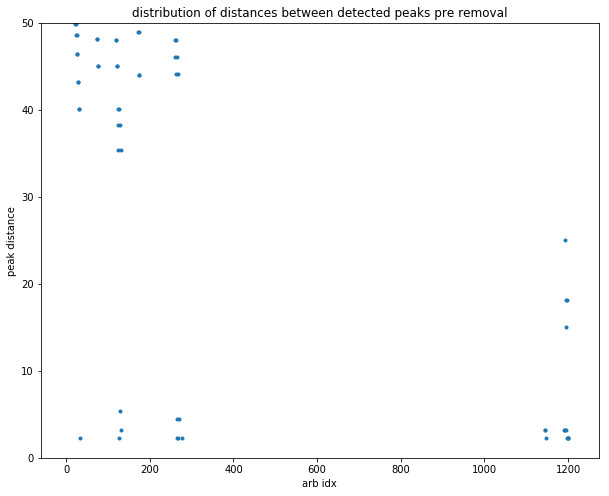

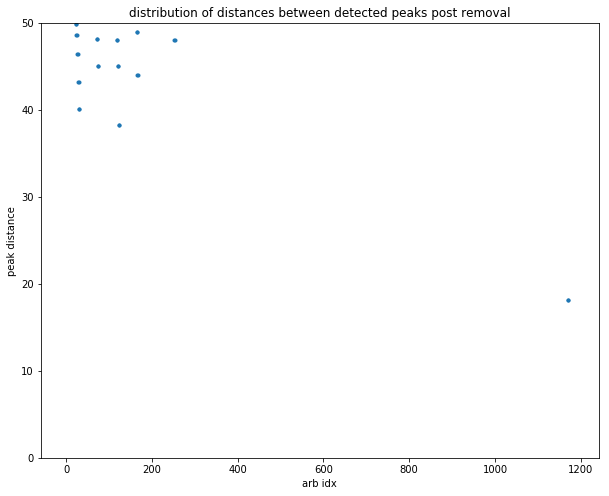

In [54]:
#trim similar peaks (that are within some range of each other and have peaks that are within some range)

minDist = 10 #in abs units of xvec, yvec
#minHeightDiff = 0.1 #in relevant units of Qfn. height probably would be in the range 1.0000xxxxx is permitted

peakDist= []
peakDistPost = []

packetsTrimmed = 0
peaksTrimmed = 0

for relevantInfo_i in relevantInfo:
    peaksTmp = []
    for coors, peak in zip(relevantInfo_i['coors'], relevantInfo_i['peaks']):
        peaksTmp.append((coors, peak))
        
    for coor1, peak1 in peaksTmp:
        for coor2, peak2 in peaksTmp:
            if coor1[0] != coor2[0] and coor1[1] != coor2[1]:
                dist = np.sqrt((coor1[0] - coor2[0])**2 + (coor1[1] - coor2[1])**2)
                peakDist.append(dist)
                if dist < minDist:
                    if peak1 >= peak2:                        
                        peaksTmp = [i for i in peaksTmp if i[0][0] != coor2[0] and i[0][1] != coor2[1] and i[1] != peak2]
                        peaksTrimmed += 1
                        #peaksTmp.remove((coor2, peak2))
                    else:
                        peaksTmp = [i for i in peaksTmp if i[0][0] != coor1[0] and i[0][1] != coor1[1] and i[1] != peak1]
                        peaksTrimmed += 1
                        #peaksTmp.remove((coor1, peak1))                
                        
            
    for coor1, peak1 in peaksTmp:
        for coor2, peak2 in peaksTmp:
            if coor1[0] != coor2[0] and coor1[1] != coor2[1]:
                dist = np.sqrt((coor1[0] - coor2[0])**2 + (coor1[1] - coor2[1])**2)
                peakDistPost.append(dist)
    
    newCoors = []
    newPeaks = []
    for coor, peak in peaksTmp:
        newCoors.append(coor)
        newPeaks.append(peak)
    if len(newPeaks) != len(relevantInfo_i['peaks']):
        relevantInfo_i['coors'] = newCoors
        relevantInfo_i['peaks'] = newPeaks
        packetsTrimmed += 1
    
                    
print('{} datapoints were trimmed.'.format(packetsTrimmed))    
print('{} peaks were trimmed'.format(peaksTrimmed))
            
plt.plot(peakDist, '.')
plt.title('distribution of distances between detected peaks pre removal')
plt.ylabel('peak distance')
plt.xlabel('arb idx')
plt.ylim(0, 50)
plt.show();

plt.plot(peakDistPost, '.')
plt.title('distribution of distances between detected peaks post removal')
plt.ylabel('peak distance')
plt.xlabel('arb idx')
plt.ylim(0, 50)
plt.show();

In [55]:
# doublePeaks = []

# for a_i in relevantInfo:
#     if len(a_i['peaks']) == 2:
#         for b in a_i['peaks']:
#             doublePeaks.append(b)
# c = [i['peaks'][0] for i in relevantInfo if len(i['peaks']) == 1]
# concacPeaks = np.sum([c, doublePeaks])

In [56]:
# plt.plot(concacPeaks, '.')
# plt.title('distribution of peak heights in data')
# plt.ylabel('candidate peak heights')
# plt.xlabel('arb index')
# plt.axvline(x=len(c), color='k')
# #plt.ylim(0.01,0.05)

In [57]:
# peaksTest = []
# for relevantInfo_i in relevantInfo:
#     for j in relevantInfo_i['peaks']:
#         peaksTest.append(j)
#     plt.plot(peaksTest, '.')
# print(np.sum([j for j in peaksTest]))

In [58]:
#todo1: play with peaktrimlimit to affect width of leaf
#todo2: if 1 peak r = nothing? that might be the grey region

numIgnored = 0
plotData = []
peakTrimLimit = 0
biPeakLimit = 0.05#0.046
siPeakLimit = 9999999
singlePeakVals = []
for relevantInfo_i in relevantInfo:
    
    trimmedPeaks = []
    foundPeaks = relevantInfo_i['peaks']
    for foundPeak_i in foundPeaks:
        #if foundPeak_i > peakTrimLimit:
        trimmedPeaks.append(foundPeak_i)
    
    if len(trimmedPeaks) == 1:
#         r = 0
#         #singlePeakVals.append(trimmedPeaks[0])
#         if trimmedPeaks[0] > siPeakLimit:
#             plotData.append((relevantInfo_i['E'], relevantInfo_i['wd'], r))
        continue
    elif len(trimmedPeaks) == 2:
        #peak0 = relevantInfo_i['peaks'][0]
        #peak1 = relevantInfo_i['peaks'][1]
        peak0 = trimmedPeaks[0]
        peak1 = trimmedPeaks[1]
        if peak0 > biPeakLimit and peak1 > biPeakLimit:
            r = 1 - (abs(peak0-peak1)/(peak0+peak1))
            plotData.append((relevantInfo_i['E'], relevantInfo_i['wd'], r))
#         if r < 0.01:
#             print(peak0)
#             print(peak1)
#             print('bbbb')
#             break
#         if relevantInfo_i['wd'] < 0:
#             print(relevantInfo_i['wd'])
#             #print('aaaa')
#             break
        
    else:
        numIgnored += 1
        #print(relevantInfo_i['E'])
        #print(relevantInfo_i['wd'])
    #ignoreif more than 2 peaks
print(len(plotData))
print(len(trimmedPeaks))
print(numIgnored)
if len(plotData) == 0:
    print('NO BISTABILITY')

491
1
9


In [59]:
plotDataScaled = []
kappa = 0.0012 # 0.0012     
wc = 10.5665 # Cavity frequency/detuning 10.5665
for i in plotData:
    item = []
    item.append(i[0]/kappa)  
    item.append((i[1] - wc)/kappa)    
    item.append(i[2])
    plotDataScaled.append(item)

In [60]:
allDataScaled = []
for relevantInfo_i in relevantInfo:
    item = []
    item.append(relevantInfo_i['E']/kappa)
    item.append((relevantInfo_i['wd'] - wc)/kappa)
    allDataScaled.append(item)

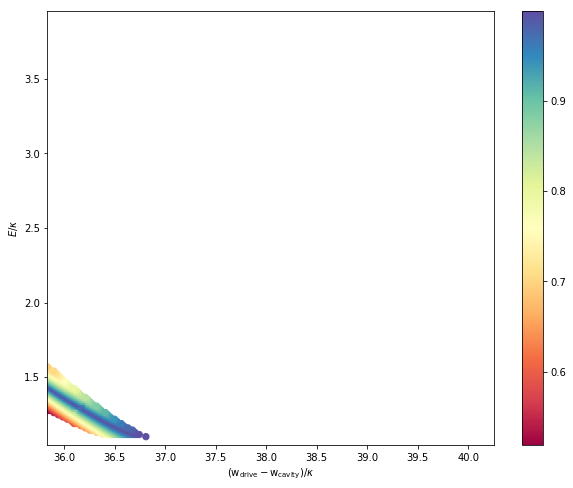

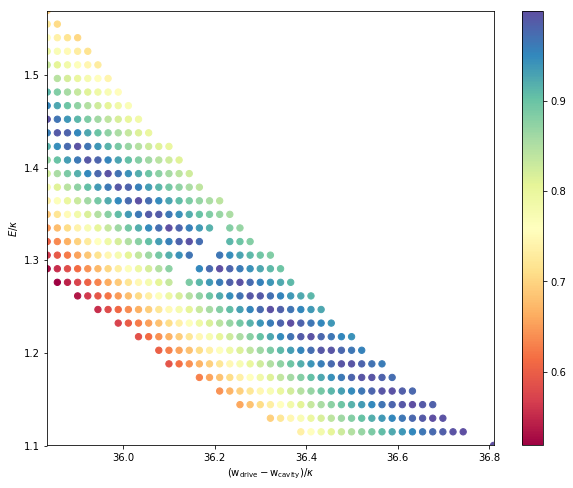

In [61]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

saveDir = 'peaks'
plt.scatter([i[1] for i in plotDataScaled], [i[0] for i in plotDataScaled], c=[i[2] for i in plotDataScaled], s=40, cmap=plt.cm.Spectral)
plt.ylabel(r"$E/\kappa$")
plt.xlabel(r"($\mathregular{w_{drive}}- \mathregular{w_{cavity}}) / \kappa$")
#plt.ylim(min([i[0] for i in plotData]), max([i[0] for i in plotData]))

plt.ylim((min([i[0] for i in allDataScaled])), (max([i[0] for i in allDataScaled])))
plt.xlim((min([i[1] for i in allDataScaled])), (max([i[1] for i in allDataScaled])))
#plt.ylim(0.00125,0.00150)
#plt.xlim(10.6095, 10.6109)
plt.colorbar()
plt.show();

plt.scatter([i[1] for i in plotDataScaled], [i[0] for i in plotDataScaled], c=[i[2] for i in plotDataScaled], s=40, cmap=plt.cm.Spectral)
plt.ylabel(r"$E/\kappa$")
plt.xlabel(r"($\mathregular{w_{drive}}- \mathregular{w_{cavity}}) / \kappa$")
plt.ylim((min([i[0] for i in plotDataScaled])), (max([i[0] for i in plotDataScaled])))
plt.xlim((min([i[1] for i in plotDataScaled])), (max([i[1] for i in plotDataScaled])))
plt.colorbar()
plt.show();


#print("EList = np.linspace(0.0,0.004,40)")
#print("wdList = np.linspace(10.6,10.62,40)")

In [ ]:
# savedInfoTest = pickle.load(open(os.path.join(saveDir,'3.qpeak'), 'rb'))
# print(savedInfoTest.keys())
# print(savedInfoTest)

In [ ]:
# print(routine(savedInfoTest['E_i'],savedInfoTest['wd_i']))

In [7]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
